# ArcFace + Swin
- dataset, label, arcface parameter, modify
- train, val, test, dfinitely split
- W&B logging
- pretrain = False, learning rates
- bounding
- ArcMarginProduct learned
- Search Result
- Aug

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [2]:
import timm
import math
import random
from PIL import ImageFilter

In [3]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
os.environ["WANDB_NOTEBOOK_NAME"] = "20230110_ArcFace-DPat-Swin_v38_384Center"

In [4]:
import wandb
wandb.login()
wandb.init(project="ArcFace-Swin")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 20230110_ArcFace-DPat-Swin_v38_384Center.
wandb: Currently logged in as: l4clippers. Use `wandb login --relogin` to force relogin


In [5]:
######################
### from MoCo repo ガウスぼかし，特許図面には精度落ちるので弱め
######################
class GaussianBlur(object):
    """ガウスぼかしの補強 in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 1.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [6]:
### p=4 に修正

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
#         self.p = nn.Parameter(torch.ones(1)*p)
        self.p = nn.Parameter(data=torch.ones(1)*p, requires_grad=False) # 勾配停止
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

gem_pool = GeM()

In [7]:
app_count = 33364 # 出力クラス数

In [8]:
class PatentNet(nn.Module):
    def __init__(self, model_name: str, pretrained: bool, embedding_size: int):
        super().__init__()
        
#         self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=1, global_pool="")
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=1)

        
#         in_features = 1280 # efnet
#         in_features = 2048 # resnet50
#         in_features = 768 # vit_b_16
        in_features = 1024 # swin_base

#         self.pool = gem_pool
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(in_features),
            nn.Dropout(),
            nn.Linear(in_features, embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.PReLU(),
        )
#         self.arcface = ArcMarginProduct(embedding_size,class_num)
    def forward(self, x):
        x = self.backbone(x)
#         x = self.pool(x) # 2D
        x = self.head(x)

        return x

device = torch.device("cuda")

model = PatentNet(model_name="swinv2_base_window12to24_192to384_22kft1k", pretrained="True", embedding_size=512).to(device) # 実験でfalse変更
# model = PatentNet(model_name="resnet50", pretrained="True", embedding_size=1000).to(device)
model = nn.DataParallel(model)

/home/yanai-lab/higuchi-k/.local/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# print(model)

In [10]:
batch_size = 128

In [11]:
log_interval = 5

In [12]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, metric, loss_func, device, train_loader, optimizer, metric_optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device) # labels
        optimizer.zero_grad()
        metric_optimizer.zero_grad()
        embeddings = model(data)
        output = metric(embeddings,labels)
        #print(embeddings.size())
        #print(labels.min(), labels.max())
        loss = loss_func(output, labels)
        loss.backward()

        optimizer.step()
        metric_optimizer.step()
        total_loss += loss
        
#         if scheduler is not None:
#             scheduler.step()
        
        if batch_idx % 50 == 0:
            print("Epoch {} Iteration {}: Train Loss = {}".format(epoch, batch_idx, loss))
        if batch_idx % log_interval == 0:
            wandb.log({'epoch': epoch, 'train-iter': batch_idx, 'train-loss': loss})
    
    total_loss = total_loss/len(train_loader)
    wandb.log({'epoch': epoch, 'train-epoch-loss':total_loss})

In [13]:
### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [14]:
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}, (mAP) = {}".format(accuracies["precision_at_1"], accuracies["mean_average_precision"]))
    wandb.log({'Prec@1': accuracies["precision_at_1"], 'mAP': accuracies["mean_average_precision"]})


In [15]:
# テスト損失の計算
def test_calc(model, metric, loss_func, device, test_query_loader, epoch):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(test_query_loader):
            data, labels = data.to(device), labels.to(device) # labels
            embeddings = model(data)
            output = metric(embeddings,labels)
            loss = loss_func(output, labels)
            total_loss += loss
            
            if batch_idx % 50 == 0:
                print("Epoch {} Iteration {}: Test Loss = {}".format(epoch, batch_idx, loss))
            if batch_idx % log_interval == 0:
                wandb.log({'epoch': epoch, 'test-iter': batch_idx, 'test-loss': loss})
    
        total_loss = total_loss/len(test_query_loader)
        wandb.log({'epoch': epoch, 'test-epoch-loss':total_loss})
    

In [16]:
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def valuation(val_db_set, val_query_set, model, accuracy_calculator):
    model.eval()
    val_db_embeddings, val_db_labels = get_all_embeddings(val_db_set, model)
    val_query_embeddings, val_query_labels = get_all_embeddings(val_query_set, model)
    val_db_labels = val_db_labels.squeeze(1)
    val_query_labels = val_query_labels.squeeze(1)
#     print("Val accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        val_query_embeddings, val_db_embeddings, val_query_labels, val_db_labels, False
    )
    print("Val set accuracy, (Precision@1) = {}, (mAP) = {}".format(accuracies["precision_at_1"], accuracies["mean_average_precision"]))

In [17]:
# val損失の計算
def valuation_calc(model, metric, loss_func, device, val_query_loader, epoch):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(val_query_loader):
            data, labels = data.to(device), labels.to(device) # labels
            embeddings = model(data)
            output = metric(embeddings,labels)
            loss = loss_func(output, labels)
            total_loss += loss
            
            if batch_idx % 50 == 0:
                print("Epoch {} Iteration {}: Test Loss = {}".format(epoch, batch_idx, loss))
            if batch_idx % log_interval == 0:
                wandb.log({'epoch': epoch, 'val-iter': batch_idx, 'validation-loss': loss})
        
        total_loss = total_loss/len(val_query_loader)
        wandb.log({'epoch': epoch, 'validation-epoch-loss':total_loss})

## transform, dataset, dataloader

In [18]:
data_transform = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=384), # 短辺384
        transforms.RandomCrop((384), pad_if_needed=True, fill=255),
        #transforms.CenterCrop(384),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([GaussianBlur()], p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.22, 0.33), ratio=(0.3, 3.3), value=1, inplace=False), # ToTensorの後
        transforms.Normalize((0.5), (0.5)),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=384),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ])
}

## Datasetを作成

In [19]:
import os.path as osp
import glob
def make_datapath_list(phase):
    """
    phase: train or val
    path_list: データパスのリスト
    """
    
    rootpath = "/host/ssd2/higuchi-k/dpatent_dataset/patent_data/"
#     rootpath = "/host/space0/higuchi-k/dpatent_dataset/patent_data/"

    if phase == "train":
        with open('./patlist/train_patent_trn.txt') as f:
            lines = f.readlines()
    elif phase == "test_query":
        with open('./patlist/test_query_patent.txt') as f:
            lines = f.readlines()
    elif phase == "test_db":
        with open('./patlist/test_db_patent.txt') as f:
            lines = f.readlines()
    elif phase == "val_query":
        with open('./patlist/val_query_patent.txt') as f:
            lines = f.readlines()
    elif phase == "val_db":
        with open('./patlist/val_db_patent.txt') as f:
            lines = f.readlines()
            
    path_list = [] # ここに格納
    for path in lines:
        path = path.split()[0] # 0:path only, 1: label
        path_list.append(rootpath+path)
        
    return path_list

train_list = make_datapath_list(phase="train")

test_query_list = make_datapath_list(phase="test_query")
test_db_list = make_datapath_list(phase="test_db")

val_query_list = make_datapath_list(phase="val_query")
val_db_list = make_datapath_list(phase="val_db")

print(train_list[0:3])
print()
print("train_list:", len(train_list))
print()
print("test_query_list:", len(test_query_list))
print("test_db_list:", len(test_db_list))
print()
print("val_query_list:", len(val_query_list))
print("val_db_list", len(val_db_list))

['/host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190514/USD0848652-20190514/USD0848652-20190514-D00001.png', '/host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190514/USD0848652-20190514/USD0848652-20190514-D00000.png', '/host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190514/USD0848652-20190514/USD0848652-20190514-D00002.png']

train_list: 254787

test_query_list: 13133
test_db_list: 38834

val_query_list: 11271
val_db_list 33544


In [20]:
def make_label_list(phase):
    """
    phase: train or val
    label_list: データラベルのリスト
    """
    
    rootpath = "/host/ssd2/higuchi-k/dpatent_dataset/patent_data/"
#     rootpath = "/host/space0/higuchi-k/dpatent_dataset/patent_data/"

    if phase == "train":
        with open('./patlist/train_patent_trn.txt') as f:
            lines = f.readlines()
    elif phase == "test_query":
        with open('./patlist/test_query_patent.txt') as f:
            lines = f.readlines()
    elif phase == "test_db":
        with open('./patlist/test_db_patent.txt') as f:
            lines = f.readlines()
    elif phase == "val_query":
        with open('./patlist/val_query_patent.txt') as f:
            lines = f.readlines()
    elif phase == "val_db":
        with open('./patlist/val_db_patent.txt') as f:
            lines = f.readlines()
        
    label_list = [] # ここに格納
    for label in lines:
        label = label.split()[1] # 0:path only, 1: label
        label = int(label)
        label_list.append(label)
        
    return label_list

train_label_list = make_label_list(phase="train")

test_query_label_list = make_label_list(phase="test_query")
test_db_label_list = make_label_list(phase="test_db")

val_query_label_list = make_label_list(phase="val_query")
val_db_label_list = make_label_list(phase="val_db")

print(train_label_list[0:3])
print(type(train_label_list[0]))

[1, 1, 1]
<class 'int'>


In [21]:
import copy
import torch.utils.data as data
from PIL import Image
import cv2

def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image

class PatentDataset(data.Dataset):
    def __init__(self, file_list, label_list, transform):
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # open
        _, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY) # 閾値処理で二値化
        
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 輪郭を取得
        cnt = contours[0]
        
        x,y,w,h = cv2.boundingRect(cnt) # 外接矩形を取得
        img = img[y:y+h, x:x+w] # 外接矩形を切り出し
        
        img = cv2pil(img)
        img = self.transform(img)
        
        label = self.label_list[index]
        label = label-1 # 0-indexed [0, nclass-1]のラベルに変換するため
        
        return img, label

In [22]:
import os
num_workers = os.cpu_count() - 1
print(num_workers)

31


In [23]:
train_data = PatentDataset(file_list=train_list, label_list=train_label_list, transform=data_transform['train'])

test_query_data = PatentDataset(file_list=test_query_list, label_list=test_query_label_list, transform=data_transform['val'])
test_db_data = PatentDataset(file_list=test_db_list, label_list=test_db_label_list, transform=data_transform['val'])

val_query_data = PatentDataset(file_list=val_query_list, label_list=val_query_label_list, transform=data_transform['val'])
val_db_data = PatentDataset(file_list=val_db_list, label_list=val_db_label_list, transform=data_transform['val'])

In [24]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_query_loader = torch.utils.data.DataLoader(test_query_data, batch_size=batch_size, num_workers=num_workers)
test_db_loader = torch.utils.data.DataLoader(test_db_data, batch_size=batch_size, num_workers=num_workers)

val_query_loader = torch.utils.data.DataLoader(val_query_data, batch_size=batch_size, num_workers=num_workers)
val_db_loader = torch.utils.data.DataLoader(val_db_data, batch_size=batch_size, num_workers=num_workers)

## dataset動作確認

In [25]:
idx = 0
print(train_data.__getitem__(idx)[0].size())
print(train_data.__getitem__(idx)[1])
print(len(train_data))

torch.Size([1, 384, 384])
0
254787


## dataloader動作確認

In [26]:
dataloaders_dict = {"train": train_loader, "test_query": test_query_loader, "val_query": val_query_loader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([128, 1, 384, 384])
tensor([ 9824,  2021,  5673,  6820,  5018,  5994, 24214, 21891, 33271,  2523,
        10423,  6195, 20078, 20845,   538,  4854, 27709, 32767,  4569,  2332,
         3728, 14990, 32866, 21563, 23460, 26948,  4846,  3326, 15009,  4524,
        22878,  6171, 30827, 18911, 11175, 21158, 33351, 20955, 14203, 18002,
        29702, 32279, 19618, 19654, 29171, 15888, 18527, 13390, 19379, 16877,
         7353, 23754, 28677, 22319, 16307,  3141, 16124, 28736, 28192, 25200,
        15597, 23760, 14660, 33158, 19937, 23437, 22700,  7780, 15553,  3153,
        25250, 31765, 12572, 14864, 14489,  6176, 23120, 15557, 15073, 21445,
        22290, 22799, 11142, 12755,  5012,  8993,  2196, 20656, 14400, 16441,
        25326, 25542,  6473, 31646,  5261, 21718,  2754, 15569,  2368,  9347,
        22845, 14144, 17418, 25917,  1203,  2578,  1293,  2488, 11636, 31781,
        20317,  8204,  6373,  8589, 24819, 21463, 12431, 31638,  5576, 27360,
         1336,  2084, 10441,  649

torch.Size([384, 384])


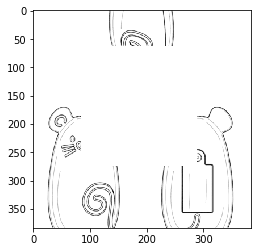

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data[0][0][0].size())
plt.imshow(train_data[0][0][0].squeeze(), cmap="gray")

torch.Size([384, 384])


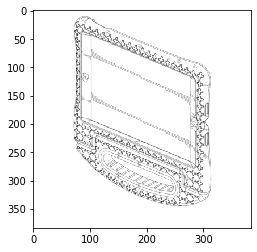

In [28]:
print(test_query_data[0][0][0].size())
plt.imshow(test_query_data[0][0][0], cmap="gray")

torch.Size([384, 384])


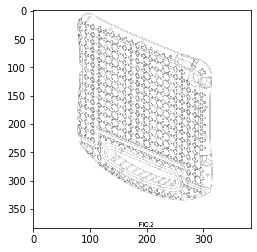

In [29]:
print(test_db_data[0][0][0].size())
plt.imshow(test_db_data[0][0][0], cmap="gray")

torch.Size([384, 384])


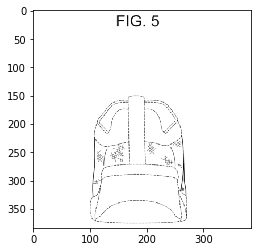

In [30]:
print(val_query_data[0][0][0].size())
plt.imshow(val_query_data[0][0][0], cmap="gray")

torch.Size([384, 384])


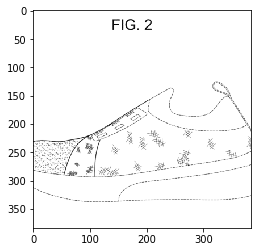

In [31]:
print(val_db_data[0][0][0].size())
plt.imshow(val_db_data[0][0][0], cmap="gray")

## 設定

In [32]:
from pytorch_metric_learning import losses, distances, regularizers

# distance = distances.CosineSimilarity()
# regularizer = regularizers.RegularFaceRegularizer()
# sampler = None

## ArcFace

In [33]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

## loss, optimizer, accuracy設定

In [34]:
# model optimizer
# optimizer = optim.Adam(model.parameters(), lr=scheduler_params['lr_start'])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Defining LR SCheduler
# scheduler = JPOScheduler(optimizer, **scheduler_params)

In [35]:
# gamma = 2.0 変更
class FocalLoss(nn.Module):

    def __init__(self, gamma=1.5, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [36]:
### pytorch-metric-learning stuff ###

# loss_func = losses.ArcFaceLoss(num_classes=app_count, embedding_size=1000, margin=28.6, scale=64, weight_regularizer=regularizer, distance=distance).to(device)
# loss_func = losses.ArcFaceLoss(num_classes=app_count, embedding_size=1000, margin=0.1, scale=8, weight_regularizer=regularizer, distance=distance).to(device)
# loss_func = losses.SubCenterArcFaceLoss(num_classes=app_count, embedding_size=1000, margin=28.6, scale=64, sub_centers=3, weight_regularizer=regularizer, distance=distance).to(device)
# loss_func = nn.CrossEntropyLoss()
loss_func = FocalLoss()

# loss_optimizer = optim.Adam(loss_func.parameters(), lr=1e-5) # from 1e-4


accuracy_calculator = AccuracyCalculator(include=("precision_at_1", "mean_average_precision"), k="max_bin_count")
### pytorch-metric-learning stuff ###

## Train the model

In [ ]:
num_epochs = 25

metric = ArcMarginProduct(512, app_count, s=30.0, m=0.5, easy_margin=True).to(device)
metric_optimizer = optim.Adam(metric.parameters(), lr=5e-3)
    
for epoch in range(1, num_epochs + 1):
#     margin = 0.45*(epoch/num_epochs)+0.05
#     wandb.log({'epoch': epoch, 'margin':margin})
    
    
#     train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
#     train(model, metric, loss_func, device, train_loader, optimizer, metric_optimizer, epoch, scheduler)
    train(model, metric, loss_func, device, train_loader, optimizer, metric_optimizer, epoch)
    
    # 古くて低い性能のモデルは，こまめに削除してディスク容量対策する
    torch.save(model.state_dict(), './saved_models_v38/swin-arcface-test_epoch{}.pth'.format(epoch))
    
    test(test_db_data, test_query_data, model, accuracy_calculator)
    test_calc(model, metric, loss_func, device, test_query_loader, epoch)
    
    valuation(val_db_data, val_query_data, model, accuracy_calculator)
    valuation_calc(model, metric, loss_func, device, val_query_loader, epoch)


Epoch 1 Iteration 0: Train Loss = 19.26102638244629
Epoch 1 Iteration 50: Train Loss = 10.90262508392334
Epoch 1 Iteration 100: Train Loss = 10.91161823272705
Epoch 1 Iteration 150: Train Loss = 10.818578720092773
Epoch 1 Iteration 200: Train Loss = 10.946352005004883
Epoch 1 Iteration 250: Train Loss = 11.60126781463623
Epoch 1 Iteration 300: Train Loss = 11.275225639343262
Epoch 1 Iteration 350: Train Loss = 10.890799522399902
Epoch 1 Iteration 400: Train Loss = 10.762434005737305
Epoch 1 Iteration 450: Train Loss = 11.19400405883789
Epoch 1 Iteration 500: Train Loss = 10.785926818847656
Epoch 1 Iteration 550: Train Loss = 11.175472259521484
Epoch 1 Iteration 600: Train Loss = 10.172463417053223
Epoch 1 Iteration 650: Train Loss = 11.665387153625488
Epoch 1 Iteration 700: Train Loss = 10.812003135681152
Epoch 1 Iteration 750: Train Loss = 10.691577911376953
Epoch 1 Iteration 800: Train Loss = 10.766998291015625
Epoch 1 Iteration 850: Train Loss = 10.683969497680664
Epoch 1 Iteration 

100%|██████████| 411/411 [04:26<00:00,  1.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.820528439808117, (mAP) = 0.6894045526778253
Epoch 1 Iteration 0: Test Loss = 18.701744079589844
Epoch 1 Iteration 50: Test Loss = 19.287811279296875
Epoch 1 Iteration 100: Test Loss = 19.480609893798828


100%|██████████| 353/353 [03:57<00:00,  1.49it/s]


Val set accuracy, (Precision@1) = 0.8320468458876763, (mAP) = 0.6874173544747612
Epoch 1 Iteration 0: Test Loss = 18.58642578125
Epoch 1 Iteration 50: Test Loss = 20.210468292236328
Epoch 2 Iteration 0: Train Loss = 14.619318962097168
Epoch 2 Iteration 50: Train Loss = 15.673257827758789
Epoch 2 Iteration 100: Train Loss = 15.64766788482666
Epoch 2 Iteration 150: Train Loss = 15.885415077209473
Epoch 2 Iteration 200: Train Loss = 15.375345230102539
Epoch 2 Iteration 250: Train Loss = 15.936676979064941
Epoch 2 Iteration 300: Train Loss = 15.61349868774414
Epoch 2 Iteration 350: Train Loss = 15.429771423339844
Epoch 2 Iteration 400: Train Loss = 15.494229316711426
Epoch 2 Iteration 450: Train Loss = 15.258831977844238
Epoch 2 Iteration 500: Train Loss = 16.163442611694336
Epoch 2 Iteration 550: Train Loss = 15.48607349395752
Epoch 2 Iteration 600: Train Loss = 15.164045333862305
Epoch 2 Iteration 650: Train Loss = 15.780348777770996
Epoch 2 Iteration 700: Train Loss = 15.521293640136719

100%|██████████| 411/411 [02:25<00:00,  2.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.883118860884794, (mAP) = 0.7751141697270401
Epoch 2 Iteration 0: Test Loss = 25.896041870117188
Epoch 2 Iteration 50: Test Loss = 27.642536163330078
Epoch 2 Iteration 100: Test Loss = 27.217525482177734


100%|██████████| 353/353 [01:59<00:00,  2.96it/s]


Val set accuracy, (Precision@1) = 0.8937982432792121, (mAP) = 0.7778928561856484
Epoch 2 Iteration 0: Test Loss = 27.944421768188477
Epoch 2 Iteration 50: Test Loss = 27.663936614990234
Epoch 3 Iteration 0: Train Loss = 12.920197486877441
Epoch 3 Iteration 50: Train Loss = 12.45841121673584
Epoch 3 Iteration 100: Train Loss = 12.787066459655762
Epoch 3 Iteration 150: Train Loss = 12.58761978149414
Epoch 3 Iteration 200: Train Loss = 12.348603248596191
Epoch 3 Iteration 250: Train Loss = 13.41307544708252
Epoch 3 Iteration 300: Train Loss = 13.619126319885254
Epoch 3 Iteration 350: Train Loss = 13.11806583404541
Epoch 3 Iteration 400: Train Loss = 12.320773124694824
Epoch 3 Iteration 450: Train Loss = 12.67670726776123
Epoch 3 Iteration 500: Train Loss = 12.715858459472656
Epoch 3 Iteration 550: Train Loss = 12.193968772888184
Epoch 3 Iteration 600: Train Loss = 13.348620414733887
Epoch 3 Iteration 650: Train Loss = 12.032032012939453
Epoch 3 Iteration 700: Train Loss = 13.0131139755249

100%|██████████| 411/411 [02:29<00:00,  2.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9004035635422218, (mAP) = 0.8028775607143293
Epoch 3 Iteration 0: Test Loss = 27.582317352294922
Epoch 3 Iteration 50: Test Loss = 27.80738639831543
Epoch 3 Iteration 100: Test Loss = 27.311561584472656


100%|██████████| 353/353 [02:07<00:00,  2.77it/s]


Val set accuracy, (Precision@1) = 0.9142045958654954, (mAP) = 0.8089867676908042
Epoch 3 Iteration 0: Test Loss = 28.393762588500977
Epoch 3 Iteration 50: Test Loss = 27.988601684570312
Epoch 4 Iteration 0: Train Loss = 9.8923921585083
Epoch 4 Iteration 50: Train Loss = 10.506526947021484
Epoch 4 Iteration 100: Train Loss = 10.615144729614258
Epoch 4 Iteration 150: Train Loss = 10.087227821350098
Epoch 4 Iteration 200: Train Loss = 10.33732795715332
Epoch 4 Iteration 250: Train Loss = 11.08926773071289
Epoch 4 Iteration 300: Train Loss = 10.313226699829102
Epoch 4 Iteration 350: Train Loss = 10.179136276245117
Epoch 4 Iteration 400: Train Loss = 10.419817924499512
Epoch 4 Iteration 450: Train Loss = 10.57448673248291
Epoch 4 Iteration 500: Train Loss = 10.933347702026367
Epoch 4 Iteration 550: Train Loss = 10.827812194824219
Epoch 4 Iteration 600: Train Loss = 10.63017463684082
Epoch 4 Iteration 650: Train Loss = 10.516899108886719
Epoch 4 Iteration 700: Train Loss = 11.471973419189453

100%|██████████| 411/411 [02:18<00:00,  2.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9092362750323612, (mAP) = 0.8189015986026704
Epoch 4 Iteration 0: Test Loss = 27.198307037353516
Epoch 4 Iteration 50: Test Loss = 27.40361785888672
Epoch 4 Iteration 100: Test Loss = 27.12748146057129


100%|██████████| 353/353 [01:59<00:00,  2.95it/s]


Val set accuracy, (Precision@1) = 0.9207701180019519, (mAP) = 0.8251335171326603
Epoch 4 Iteration 0: Test Loss = 27.85682487487793
Epoch 4 Iteration 50: Test Loss = 27.179208755493164
Epoch 5 Iteration 0: Train Loss = 9.507301330566406
Epoch 5 Iteration 50: Train Loss = 9.09208869934082
Epoch 5 Iteration 100: Train Loss = 9.338288307189941
Epoch 5 Iteration 150: Train Loss = 9.38469123840332
Epoch 5 Iteration 200: Train Loss = 9.172378540039062
Epoch 5 Iteration 250: Train Loss = 9.833227157592773
Epoch 5 Iteration 300: Train Loss = 9.229475021362305
Epoch 5 Iteration 350: Train Loss = 10.034093856811523
Epoch 5 Iteration 400: Train Loss = 8.960418701171875
Epoch 5 Iteration 450: Train Loss = 9.496725082397461
Epoch 5 Iteration 500: Train Loss = 10.169013023376465
Epoch 5 Iteration 550: Train Loss = 9.422001838684082
Epoch 5 Iteration 600: Train Loss = 9.859514236450195
Epoch 5 Iteration 650: Train Loss = 8.793217658996582
Epoch 5 Iteration 700: Train Loss = 9.366023063659668
Epoch 5 

100%|██████████| 411/411 [02:21<00:00,  2.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.915556232391685, (mAP) = 0.827771318033466
Epoch 5 Iteration 0: Test Loss = 27.15947914123535
Epoch 5 Iteration 50: Test Loss = 26.94121551513672
Epoch 5 Iteration 100: Test Loss = 26.5377254486084


100%|██████████| 353/353 [01:57<00:00,  3.00it/s]


Val set accuracy, (Precision@1) = 0.9260935143288084, (mAP) = 0.8351061518420165
Epoch 5 Iteration 0: Test Loss = 27.286067962646484
Epoch 5 Iteration 50: Test Loss = 26.142866134643555
Epoch 6 Iteration 0: Train Loss = 8.045588493347168
Epoch 6 Iteration 50: Train Loss = 8.811606407165527
Epoch 6 Iteration 100: Train Loss = 8.78062915802002
Epoch 6 Iteration 150: Train Loss = 8.72551155090332
Epoch 6 Iteration 200: Train Loss = 8.573969841003418
Epoch 6 Iteration 250: Train Loss = 8.752385139465332
Epoch 6 Iteration 300: Train Loss = 8.29909610748291
Epoch 6 Iteration 350: Train Loss = 8.317554473876953
Epoch 6 Iteration 400: Train Loss = 8.716696739196777
Epoch 6 Iteration 450: Train Loss = 9.047941207885742
Epoch 6 Iteration 500: Train Loss = 8.64931869506836
Epoch 6 Iteration 550: Train Loss = 9.327559471130371
Epoch 6 Iteration 600: Train Loss = 9.012622833251953
Epoch 6 Iteration 650: Train Loss = 8.7439546585083
Epoch 6 Iteration 700: Train Loss = 8.58737850189209
Epoch 6 Iterat

100%|██████████| 411/411 [02:28<00:00,  2.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9186019949744917, (mAP) = 0.8334059944855899
Epoch 6 Iteration 0: Test Loss = 26.657398223876953
Epoch 6 Iteration 50: Test Loss = 26.690650939941406
Epoch 6 Iteration 100: Test Loss = 25.59722328186035


100%|██████████| 353/353 [01:57<00:00,  3.01it/s]


Val set accuracy, (Precision@1) = 0.9303522313902935, (mAP) = 0.8421074366304917
Epoch 6 Iteration 0: Test Loss = 27.395299911499023
Epoch 6 Iteration 50: Test Loss = 26.291149139404297
Epoch 7 Iteration 0: Train Loss = 7.719193458557129
Epoch 7 Iteration 50: Train Loss = 8.000887870788574
Epoch 7 Iteration 100: Train Loss = 7.581263065338135
Epoch 7 Iteration 150: Train Loss = 8.100309371948242
Epoch 7 Iteration 200: Train Loss = 7.538030624389648
Epoch 7 Iteration 250: Train Loss = 8.453953742980957
Epoch 7 Iteration 300: Train Loss = 7.676112651824951
Epoch 7 Iteration 350: Train Loss = 8.374616622924805
Epoch 7 Iteration 400: Train Loss = 7.2764482498168945
Epoch 7 Iteration 450: Train Loss = 8.534283638000488
Epoch 7 Iteration 500: Train Loss = 8.495227813720703
Epoch 7 Iteration 550: Train Loss = 8.51115608215332
Epoch 7 Iteration 600: Train Loss = 8.778252601623535
Epoch 7 Iteration 650: Train Loss = 8.22231674194336
Epoch 7 Iteration 700: Train Loss = 7.874269485473633
Epoch 7 

100%|██████████| 411/411 [02:20<00:00,  2.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9224853422675702, (mAP) = 0.8392155583546018
Epoch 7 Iteration 0: Test Loss = 27.120574951171875
Epoch 7 Iteration 50: Test Loss = 26.373523712158203
Epoch 7 Iteration 100: Test Loss = 25.849809646606445


100%|██████████| 353/353 [02:05<00:00,  2.82it/s]


Val set accuracy, (Precision@1) = 0.9329252062816076, (mAP) = 0.8483211247563809
Epoch 7 Iteration 0: Test Loss = 26.397544860839844
Epoch 7 Iteration 50: Test Loss = 26.2088680267334
Epoch 8 Iteration 0: Train Loss = 6.8725080490112305
Epoch 8 Iteration 50: Train Loss = 7.056519985198975
Epoch 8 Iteration 100: Train Loss = 8.070694923400879
Epoch 8 Iteration 150: Train Loss = 6.539844989776611
Epoch 8 Iteration 200: Train Loss = 7.384788513183594
Epoch 8 Iteration 250: Train Loss = 7.568420886993408
Epoch 8 Iteration 300: Train Loss = 7.637240886688232
Epoch 8 Iteration 350: Train Loss = 6.938808441162109
Epoch 8 Iteration 400: Train Loss = 7.351407527923584
Epoch 8 Iteration 450: Train Loss = 7.287914276123047
Epoch 8 Iteration 500: Train Loss = 7.8958234786987305
Epoch 8 Iteration 550: Train Loss = 7.465038299560547
Epoch 8 Iteration 600: Train Loss = 7.676105976104736
Epoch 8 Iteration 650: Train Loss = 7.440488815307617
Epoch 8 Iteration 700: Train Loss = 7.3831915855407715
Epoch 

  5%|▌         | 64/1214 [00:25<07:24,  2.59it/s]

## モデル保存

In [31]:
# torch.save(model.state_dict(), './ef-arcface-test_final.pth')

## モデルをロード

In [37]:
model.load_state_dict(torch.load('./saved_models_v38/swin-arcface-test_epoch19.pth'))

<All keys matched successfully>

## test, val関数の最終値確認（試験），ラベル破損確認

In [41]:
metric = ArcMarginProduct(512, app_count, s=30.0, m=0.5, easy_margin=True).to(device)
metric_optimizer = optim.Adam(metric.parameters(), lr=5e-3)

num_epochs = 1
for epoch in range(1, num_epochs + 1):
#     train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
#     train(model, loss_func, device, train_loader, optimizer, metric_optimizer, epoch)

#     Test set accuracy, (Precision@1) = 0.7765171704865605, (mAP) = 0.5321175917554289
#      test(test_db_data, test_query_data, model, accuracy_calculator)
#      test_calc(model, loss_func, device, test_query_loader, epoch)

#     Val set accuracy, (Precision@1) = 0.7927424363410522, (mAP) = 0.5419492973671735
#     valuation(val_db_data, val_query_data, model, accuracy_calculator)
    valuation_calc(model, metric, loss_func, device, val_query_loader, epoch)
    

Epoch 1 Iteration 0: Test Loss = 18.58183479309082


## 検索試行

In [38]:
import faiss
# print(OUT_FEATURES) # 1000
d = 512 # モデル出力の定数，調節しないとエラー
faiss_index = faiss.IndexFlatL2(d)   # build the index
print(faiss_index.is_trained)

True


## インデキシング，件数に応じて時間が掛かる．

In [39]:
import glob
import os
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm as trange

model.eval()
im_indices = []
with torch.no_grad():
    for f in trange(test_db_list):
        im = Image.open(f)
        #im = im.resize((224,224))
        im = torch.tensor([data_transform['val'](im).numpy()]).cuda()
    
        preds = model(im)
        preds = np.array([preds[0].cpu().numpy()])
        faiss_index.add(preds) #add the representation to index
        im_indices.append(f)   #store the image name to find it later on

  0%|          | 0/38834 [00:00<?, ?it/s]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


## インデキシング済みの特徴量を保存．

In [41]:
faiss.write_index(faiss_index, "./saved_models_v38/swin-arcface-test_epoch19.faiss")

## ロード

In [42]:
faiss_index = faiss.read_index("./saved_models_v38/swin-arcface-test_epoch19.faiss")

In [43]:
im_indices = test_db_list

In [48]:
print(faiss_index.is_trained)
print(faiss_index.ntotal)

True
38834


## 検索メソッド faiss_index.searchの試験

In [49]:
# with torch.no_grad():
#     for f in trange(test_query_list):
#         im = Image.open(f)
#         #print(f)
#         #im = im.resize((224,224))
#         im = torch.tensor([data_transform['val'](im).numpy()]).cuda()
    
#         test_embed = model(im).cpu().numpy()
#         _, I = faiss_index.search(test_embed, 5) # 上位5件
        
#         print("Retrieved Image: {}".format(im_indices[I[0][0]]))

## 検索結果の表示

In [50]:
# 短辺を入力値で，アスペクト比固定でリサイズ
# imgは開いてあるもの
def resizeImg(img, shortEdge):
    x = img.size[0]
    y = img.size[1]
    SHORT_EDGE = shortEdge

    if x>y:
        ratio = x/y
        y = SHORT_EDGE
        x = int(SHORT_EDGE * ratio)
    else:
        ratio = y/x
        x = SHORT_EDGE
        y = int(SHORT_EDGE * ratio)
    img = img.resize((x,y))

    return img

In [51]:
import cv2
# cv2
# center Crop
def cv2CenterCrop(cv2_img, crop_x, crop_y):
    x = cv2_img.shape[0]
    y = cv2_img.shape[1]

    return cv2_img[(x - crop_x) // 2:
                   (x + crop_x) // 2,
                   (y - crop_y) // 2:
                   (y + crop_y) // 2]

# 短辺を入力値で，アスペクト比固定でリサイズ
# imgは開いてあるもの
def cv2ResizeImg(cv2_img, shortEdge):
    x = cv2_img.shape[0]
    y = cv2_img.shape[1]
    SHORT_EDGE = shortEdge

    if x>y:
        ratio = x/y
        y = SHORT_EDGE
        x = int(SHORT_EDGE * ratio)
    else:
        ratio = y/x
        x = SHORT_EDGE
        y = int(SHORT_EDGE * ratio)
    cv2_img = cv2.resize(cv2_img, dsize=(x,y))

    return cv2_img

In [52]:
# imshow()メソッドで，画像を呼び出せるようにする
from IPython.display import Image, display
def imshow(img):
    '''画像を Notebook 上にインラインで縮小して表示'''
    img = cv2ResizeImg(img, 384)
    img = cv2CenterCrop(img, 224, 224)
    #dst = cv2.resize(img, dsize=(224, 224))
    _, encimg = cv2.imencode('.png', img)
    display(Image(encimg))
    
#import libraries
import cv2
from matplotlib import pyplot as plt

def showQueryRetrievalImage(query, ret1, ret2, ret3, ret4, ret5) -> None:    
    # code for displaying multiple images in one figure
    # query, ret are path.

    # create figure
    fig = plt.figure(figsize=(20, 14))

    # setting values to rows and column variables
    rows = 2
    columns = 3

    # reading images
    Image0 = cv2.imread(query)
    Image1 = cv2.imread(ret1)
    Image2 = cv2.imread(ret2)
    Image3 = cv2.imread(ret3)
    Image4 = cv2.imread(ret4)
    Image5 = cv2.imread(ret5)

   # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(Image0)
    plt.axis('off')
    plt.title("Query", color="red")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(Image1)
    plt.axis('off')
    plt.title("Rank1", color="blue")

    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)

    # showing image
    plt.imshow(Image2)
    plt.axis('off')
    plt.title("Rank2", color="blue")

    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)

    # showing image
    plt.imshow(Image3)
    plt.axis('off')
    plt.title("Rank3", color="blue")
    
    # Adds a subplot at the 5th position
    fig.add_subplot(rows, columns, 5)

    # showing image
    plt.imshow(Image4)
    plt.axis('off')
    plt.title("Rank4", color="blue")

    # Adds a subplot at the 6th position
    fig.add_subplot(rows, columns, 6)

    # showing image
    plt.imshow(Image5)
    plt.axis('off')
    plt.title("Rank5", color="blue")
    
    print("Query: {}\nRetrieved:\n rank1: {}\n rank2: {}\n rank3: {}\n rank4: {}\n rank5: {}\n".format(f, im_indices[I[0][0]], im_indices[I[0][1]], im_indices[I[0][2]], im_indices[I[0][3]], im_indices[I[0][4]]))

  0%|          | 0/500 [00:00<?, ?it/s]

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181023/USD0831710-20181023/USD0831710-20181023-D00005.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180703/USD0821780-20180703/USD0821780-20180703-D00001.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180703/USD0822247-20180703/USD0822247-20180703-D00003.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190430/USD0847254-20190430/USD0847254-20190430-D00011.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180626/USD0821310-20180626/USD0821310-20180626-D00004.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180717/USD0823569-20180717/USD0823569-20180717-D00003.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181127/USD0834459-20181127/USD0834459-20181127-D00003.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180220/USD0810642-20180220/USD0810642-20180220-D00000.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180313/USD0812455-20180313/USD0812455-20180313-D00004.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190319/USD0843648-20190319/USD0843648-20190319-D00005.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0871781-20200107/USD0871781-20200107-D00000.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0872288-20200107/USD0872288-20200107-D00007.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180814/USD0825822-20180814/USD0825822-20180814-D00006.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180814/USD0825657-20180814/USD0825657-20180814-D00004.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181009/USD0830640-20181009/USD0830640-20181009-D00000.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181009/USD0830640-20181009/USD0830640-20181009-D00001.png
 rank2: /host/ssd2/higuchi-k/dpaten

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181113/USD0833356-20181113/USD0833356-20181113-D00000.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0871978-20200107/USD0871978-20200107-D00000.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180227/USD0811293-20180227/USD0811293-20180227-D00006.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180227/USD0811293-20180227/USD0811293-20180227-D00005.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181009/USD0830483-20181009/USD0830483-20181009-D00003.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0871978-20200107/USD0871978-20200107-D00007.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837265-20190101/USD0837265-20190101-D00002.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180403/USD0814557-20180403/USD0814557-20180403-D00003.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181002/USD0830027-20181002/USD0830027-20181002-D00001.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190108/USD0837503-20190108/USD0837503-20190108-D00002.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181002/USD0830027-20181002/USD0830027-20181002-D00000.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180508/USD0817450-20180508/USD0817450-20180508-D00005.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180508/USD0817450-20180508/USD0817450-20180508-D00001.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190108/USD0837498-20190108/USD0837498-20190108-D00008.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190319/USD0843151-20190319/USD0843151-20190319-D00000.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190402/USD0844926-20190402/USD0844926-20190402-D00001.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190319/USD0843386-20190319/USD0843386-20190319-D00001.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180626/USD0821423-20180626/USD0821423-20180626-D00001.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190129/USD0839298-20190129/USD0839298-20190129-D00000.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180814/USD0825580-20180814/USD0825580-20180814-D00001.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180911/USD0828391-20180911/USD0828391-20180911-D00000.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180814/USD0825580-20180814/USD0825580-20180814-D00000.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837466-20190101/USD0837466-20190101-D00002.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190618/USD0851447-20190618/USD0851447-20190618-D00004.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837228-20190101/USD0837228-20190101-D00002.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190122/USD0838873-20190122/USD0838873-20190122-D00006.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837228-20190101/USD0837228-20190101-D00001.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190521/USD0849068-20190521/USD0849068-20190521-D00003.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837228-20190101/USD0837228-20190101-D00000.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190521/USD0849068-20190521/USD0849068-20190521-D00002.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837089-20190101/USD0837089-20190101-D00001.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181030/USD0831936-20181030/USD0831936-20181030-D00009.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190521/USD0848783-20190521/USD0848783-20190521-D00006.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180123/USD0808521-20180123/USD0808521-20180123-D00017.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180123/USD0808521-20180123/USD0808521-20180123-D00018.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190219/USD0840987-20190219/USD0840987-20190219-D00002.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0871757-20200107/USD0871757-20200107-D00005.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20200107/USD0872361-20200107/USD0872361-20200107-D00005.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180710/USD0822566-20180710/USD0822566-20180710-D00000.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180710/USD0822566-20180710/USD0822566-20180710-D00001.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190219/USD0840964-20190219/USD0840964-20190219-D00008.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190402/USD0844304-20190402/USD0844304-20190402-D00006.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190604/USD0850452-20190604/USD0850452-20190604-D00008.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20181016/USD0830983-20181016/USD0830983-20181016-D00003.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180116/USD0807845-20180116/USD0807845-20180116-D00003.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180306/USD0811759-20180306/USD0811759-20180306-D00004.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0836956-20190101/USD0836956-20190101-D00007.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180814/USD0825650-20180814/USD0825650-20180814-D00007.png
 rank2: /host/ssd2/higuchi-k/dpaten

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180522/USD0818598-20180522/USD0818598-20180522-D00001.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180522/USD0818598-20180522/USD0818598-20180522-D00003.png
 rank2: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180522/USD0818598-20180522/USD0818598-20180522-D00000.png
 rank3: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190101/USD0837012-20190101/USD0837012-20190101-D00007.png
 rank4: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190604/USD0850113-20190604/USD0850113-20190604-D00005.png
 rank5: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180410/USD0815282-20180410/USD0815282-20180410-D00004.png

Query: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20190226/USD0841698-20190226/USD0841698-20190226-D00003.png
Retrieved:
 rank1: /host/ssd2/higuchi-k/dpatent_dataset/patent_data/I20180529/USD0819037-20180529/USD0819037-20180529-D00006.png
 rank2: /host/ssd2/higuchi-k/dpaten

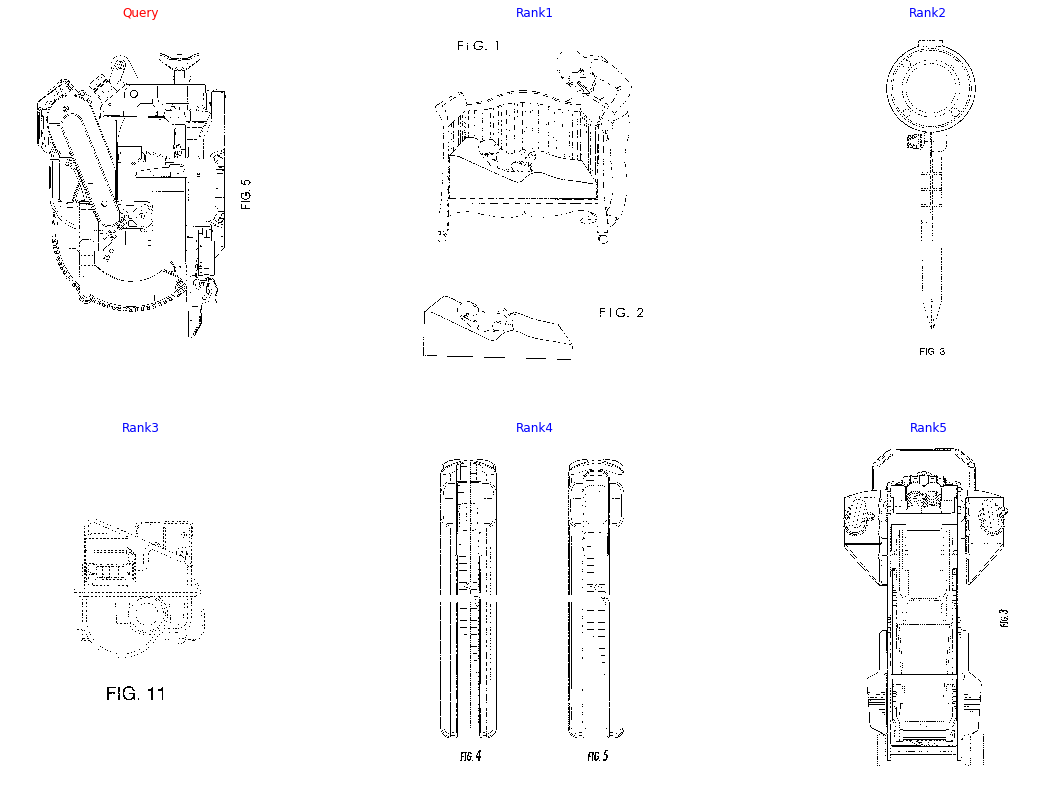

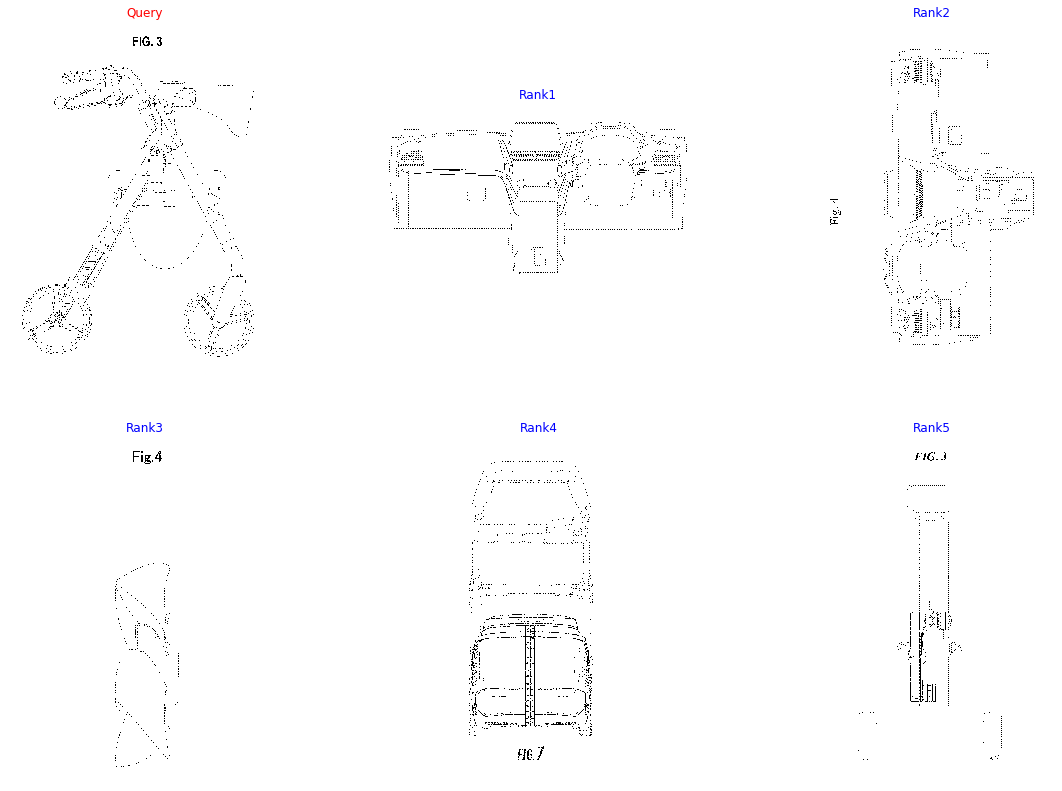

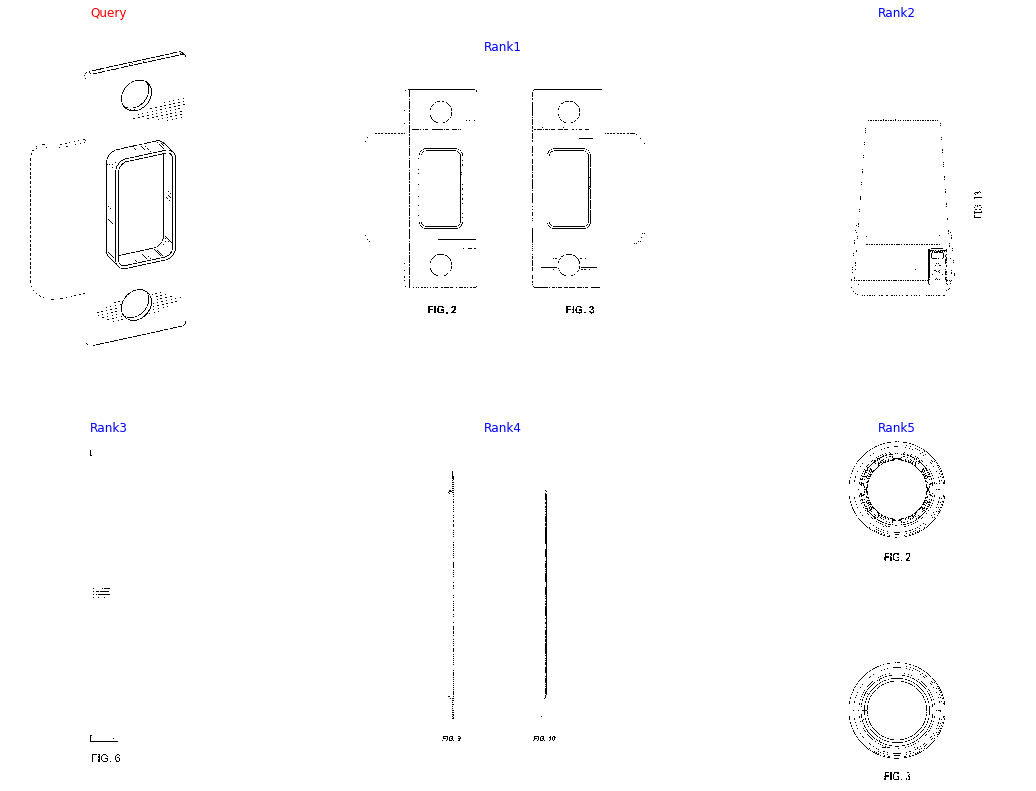

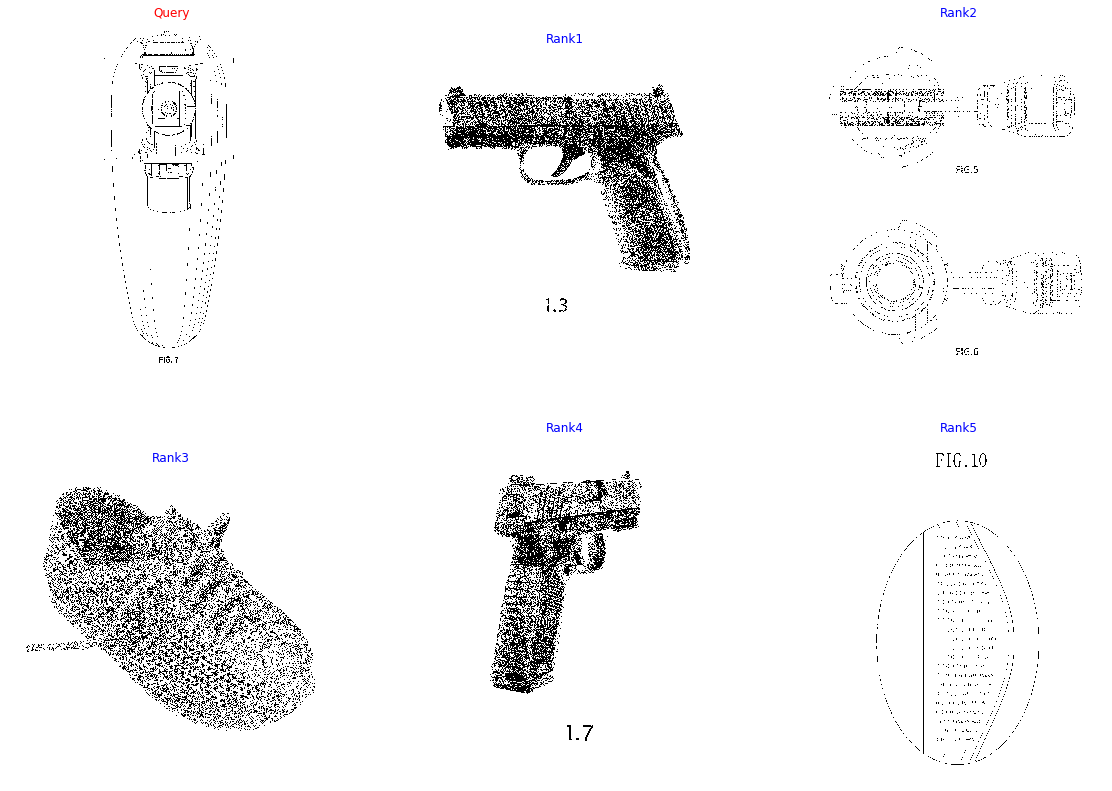

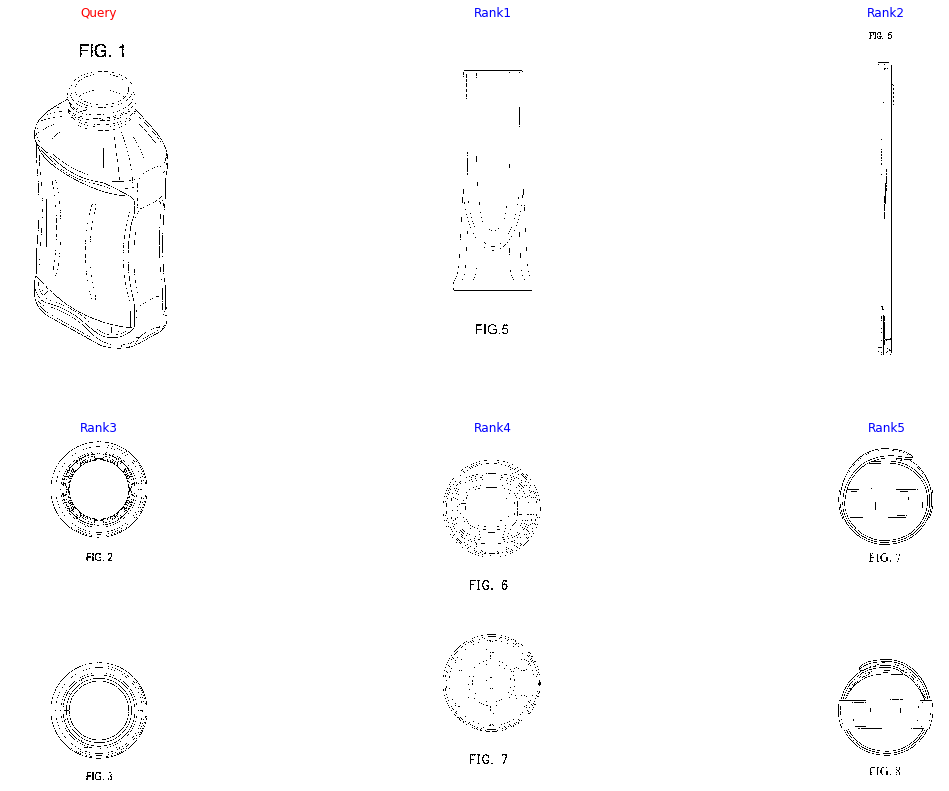

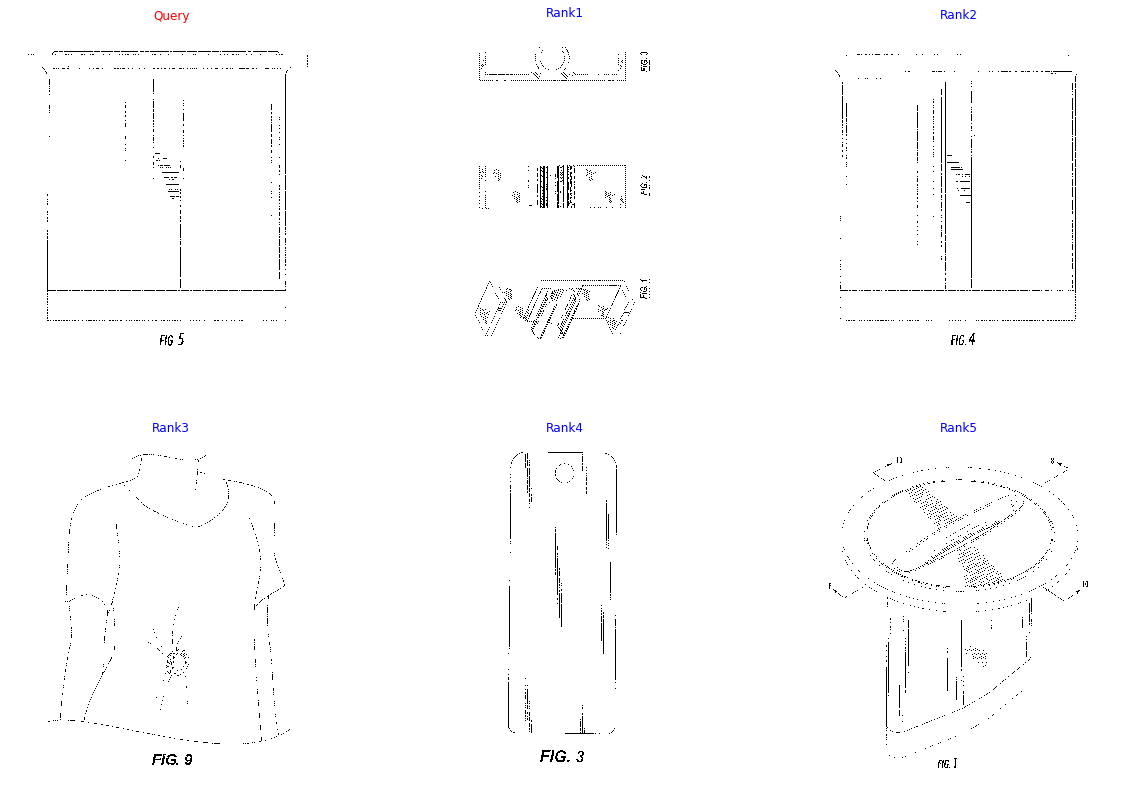

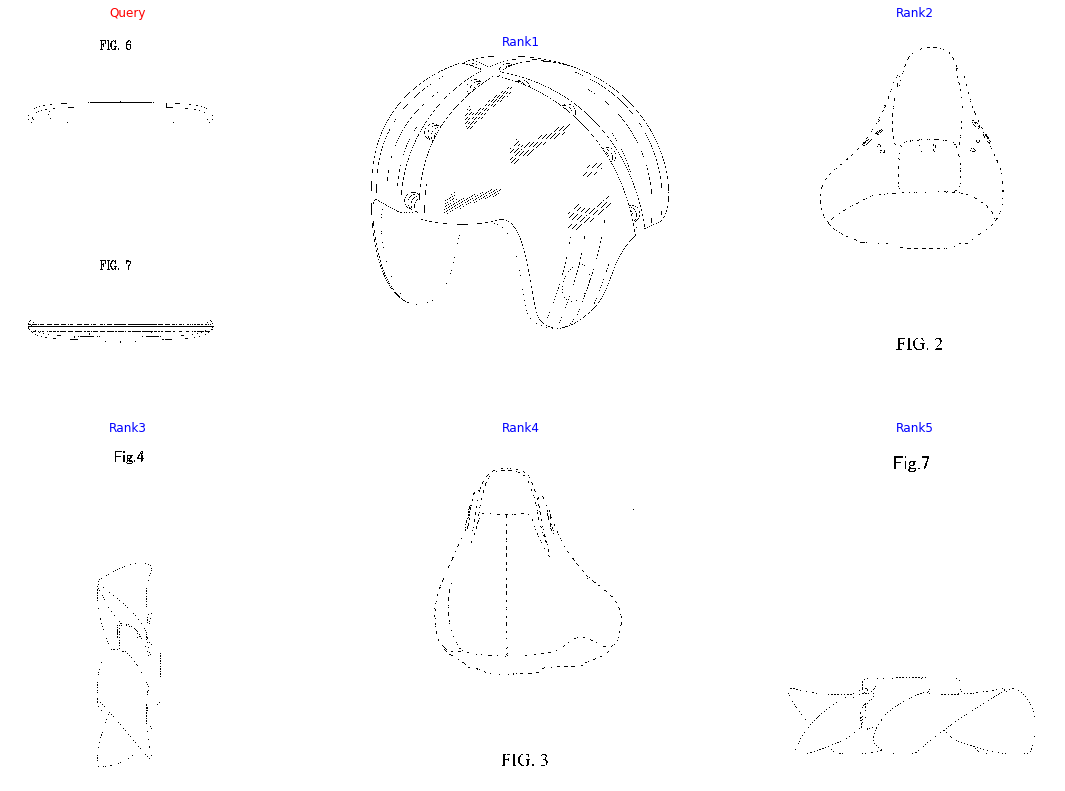

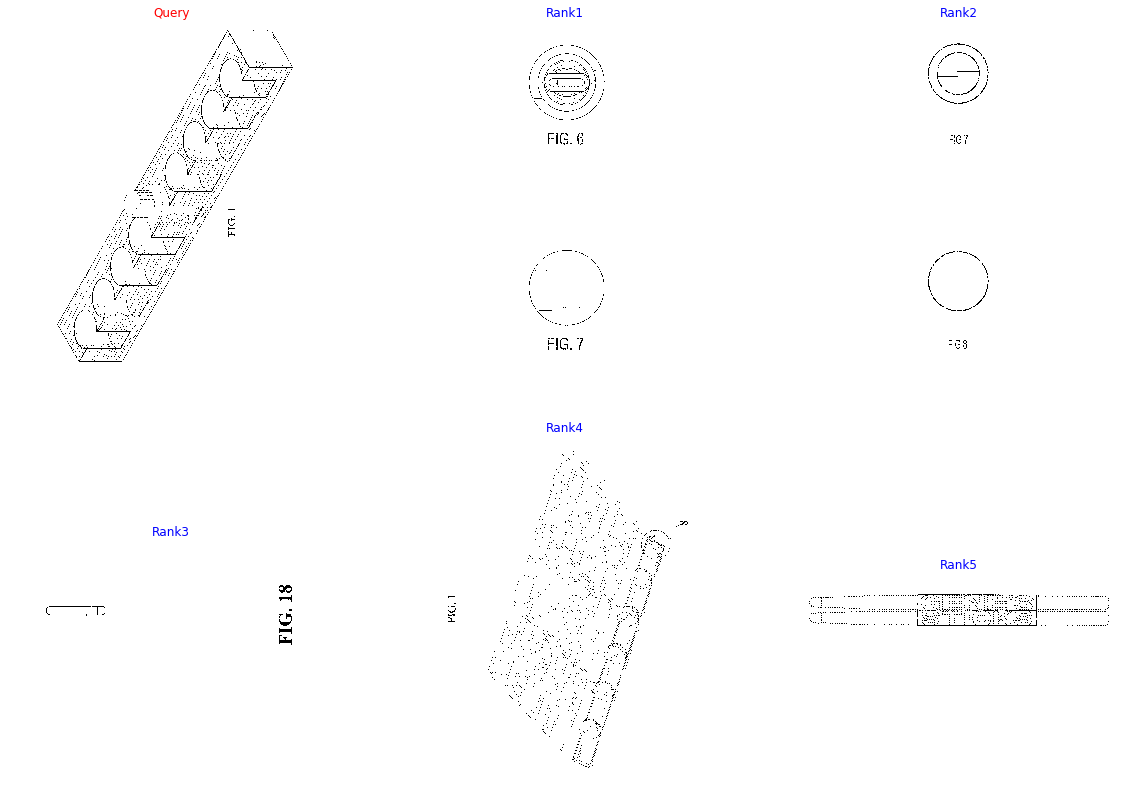

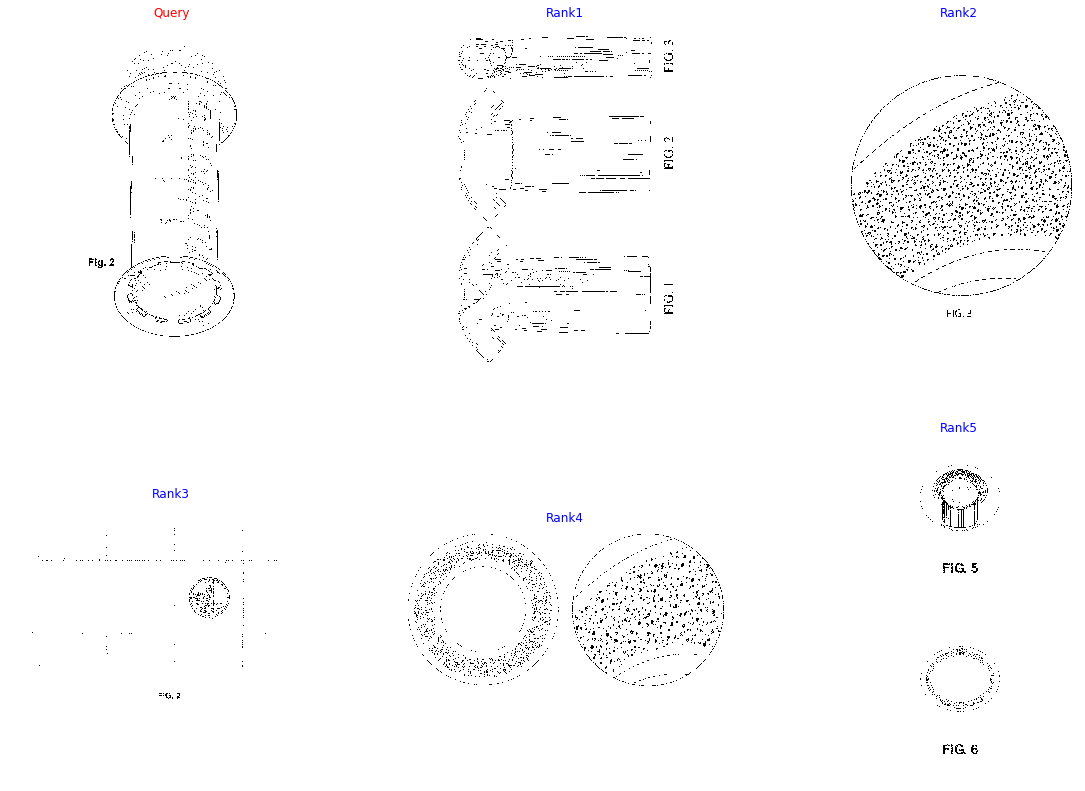

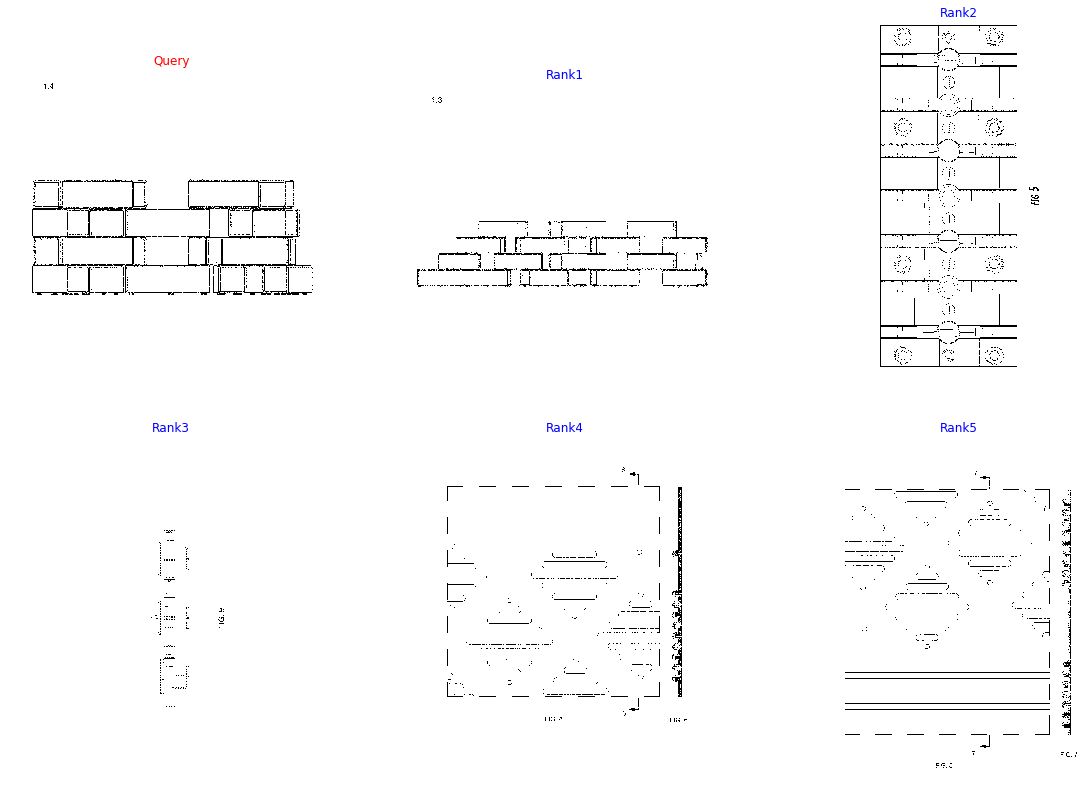

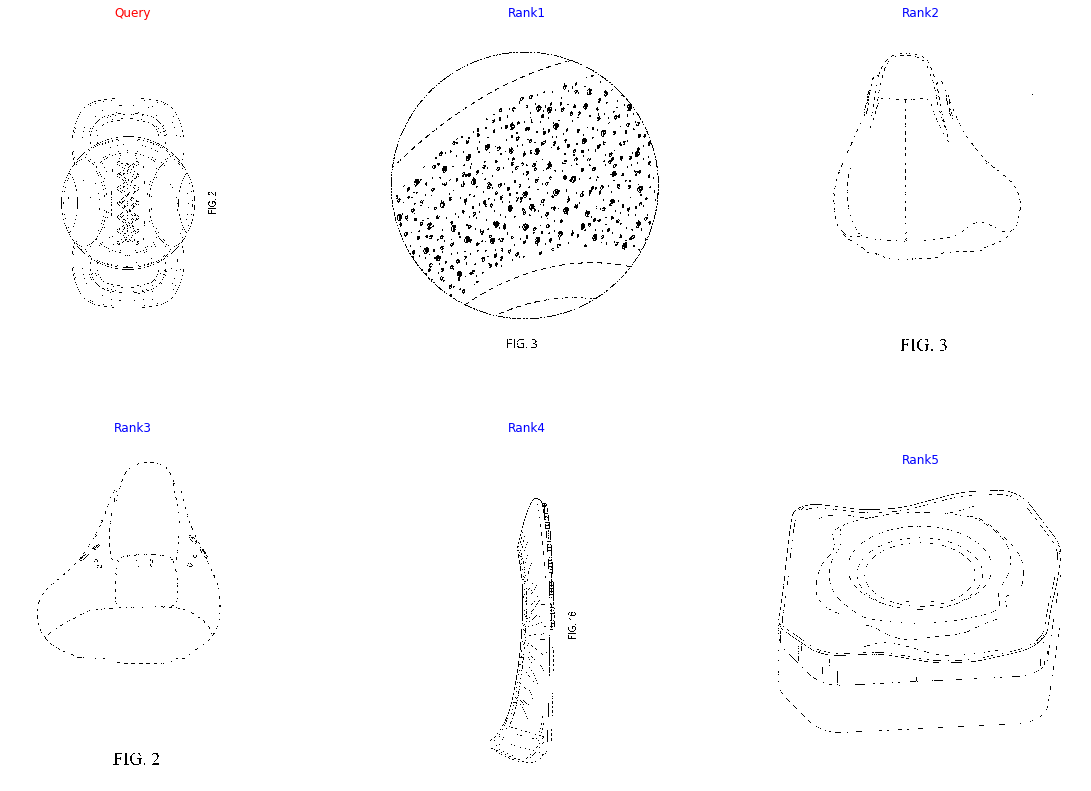

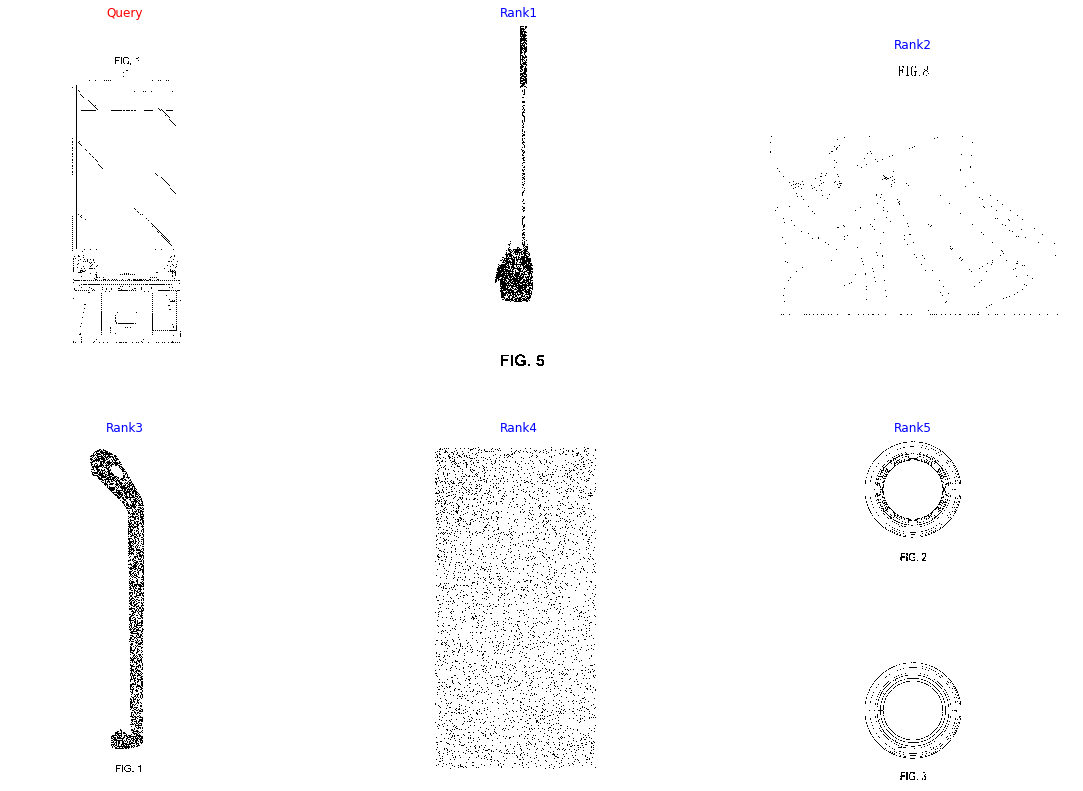

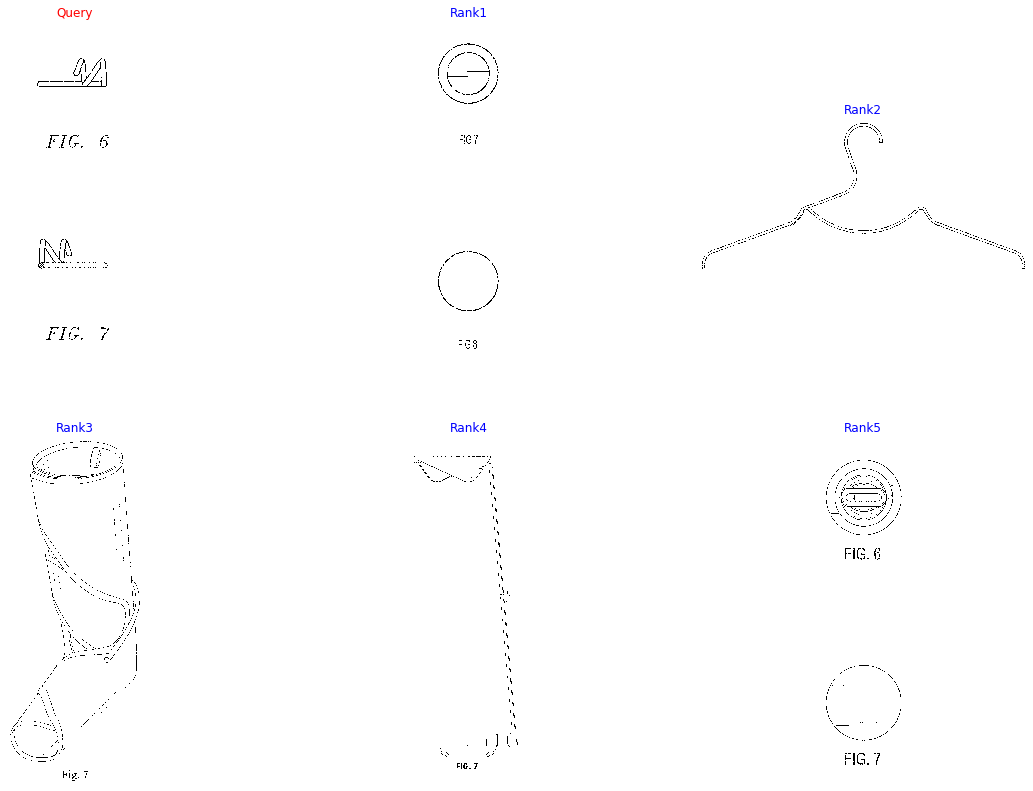

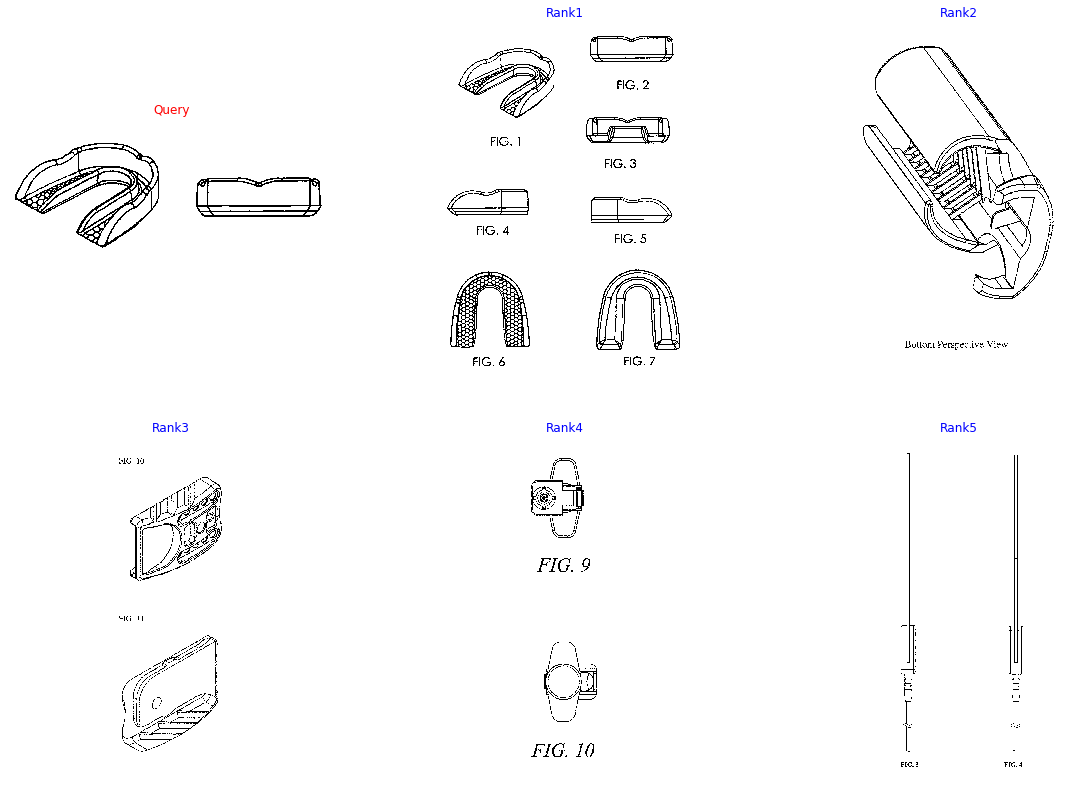

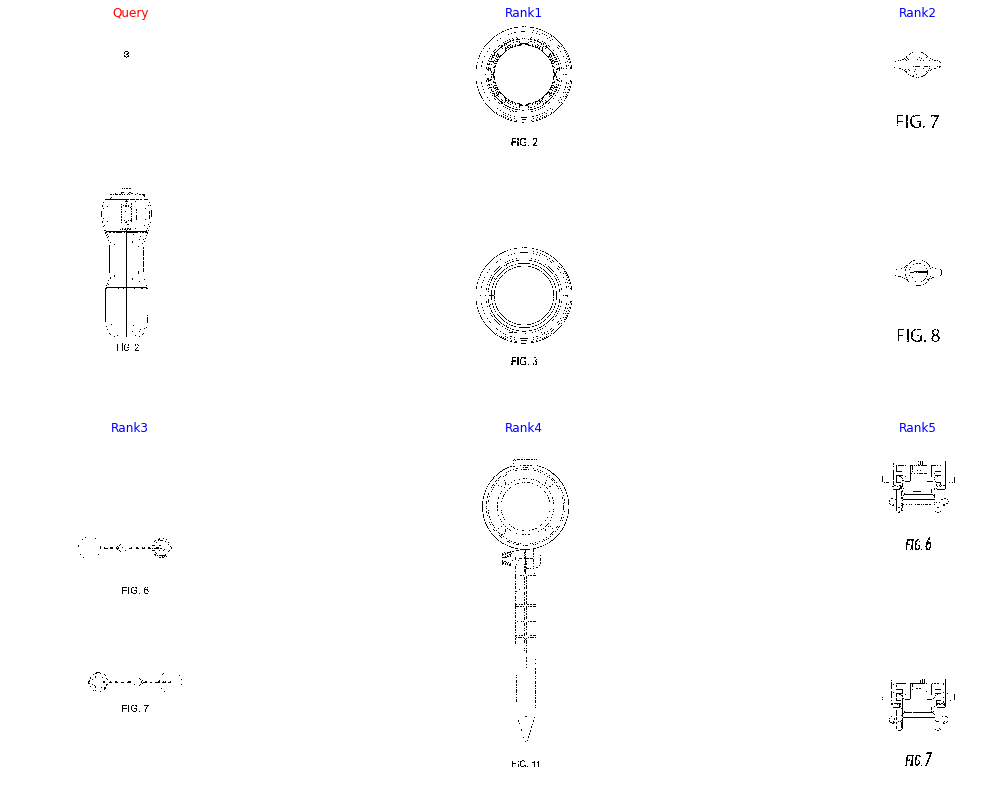

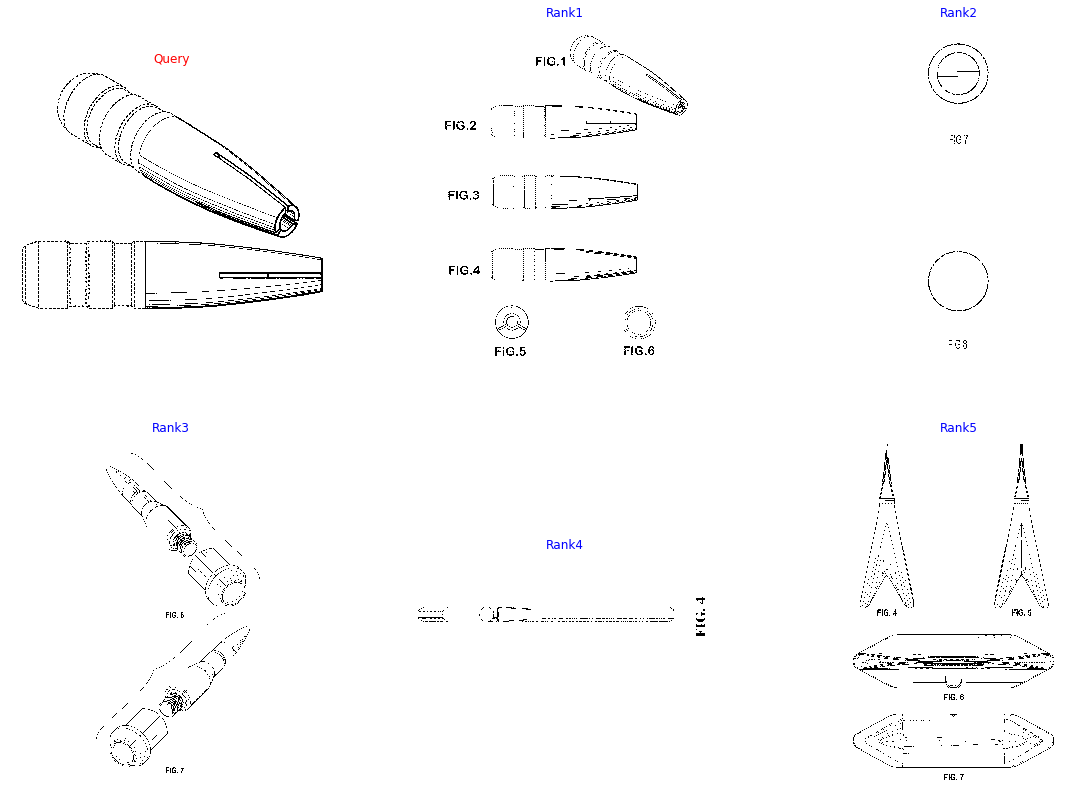

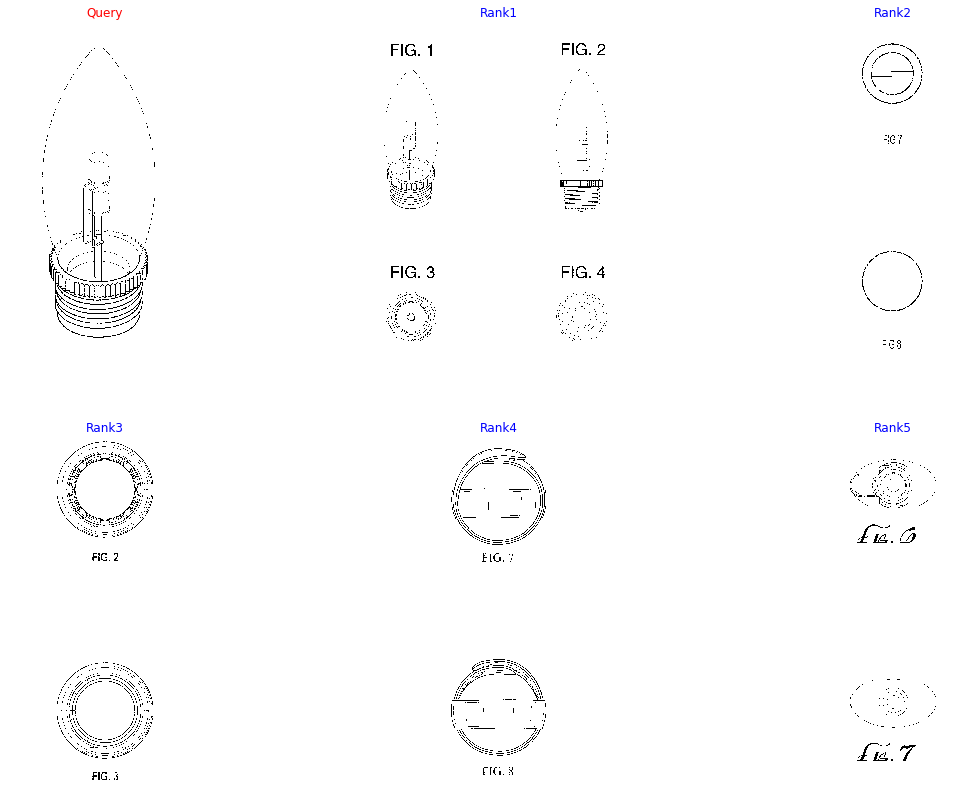

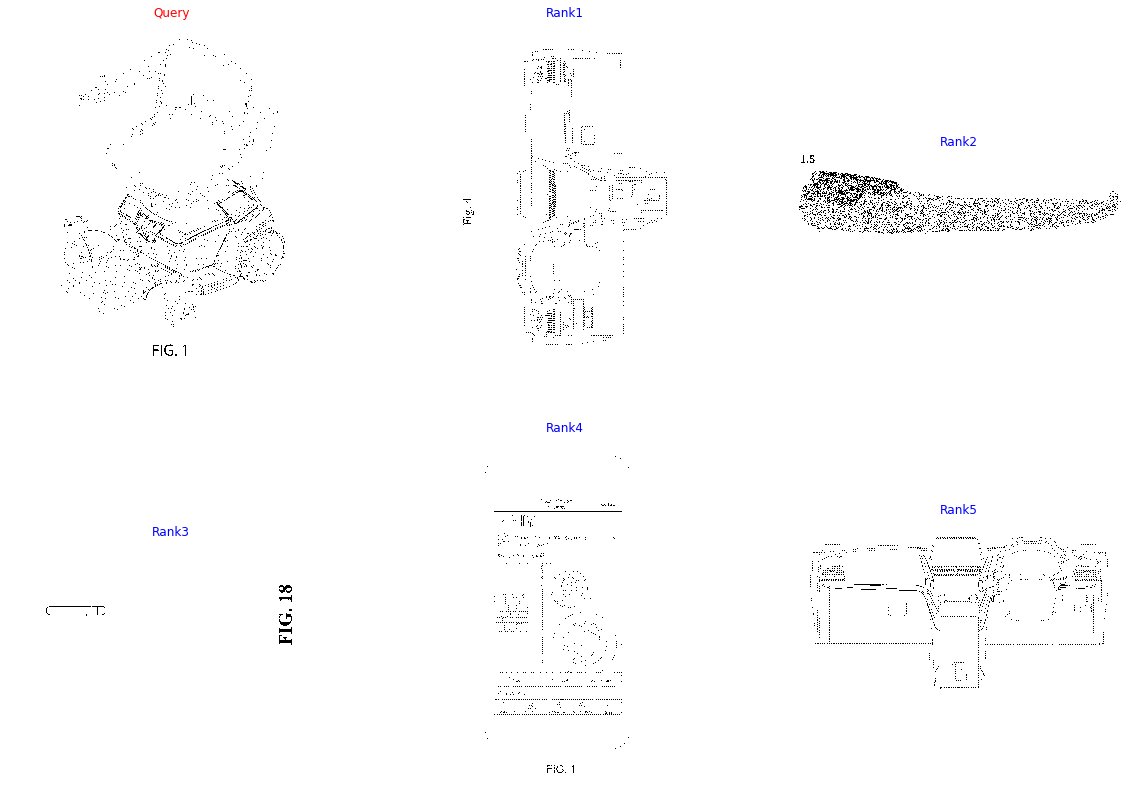

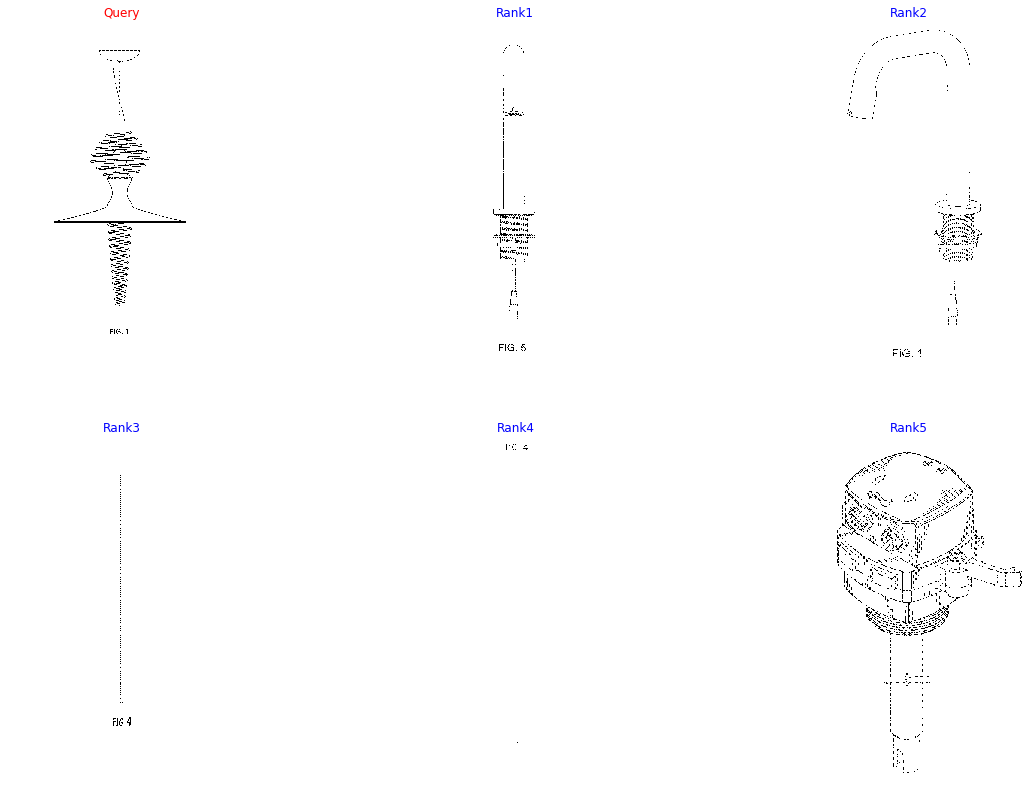

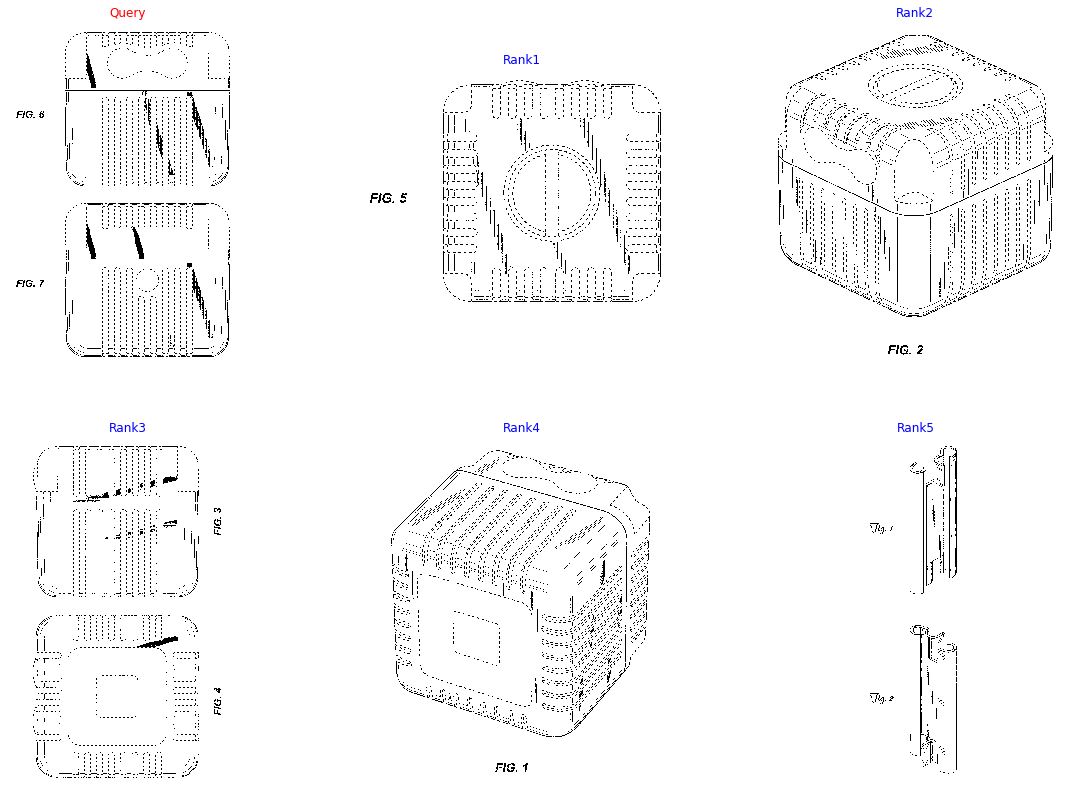

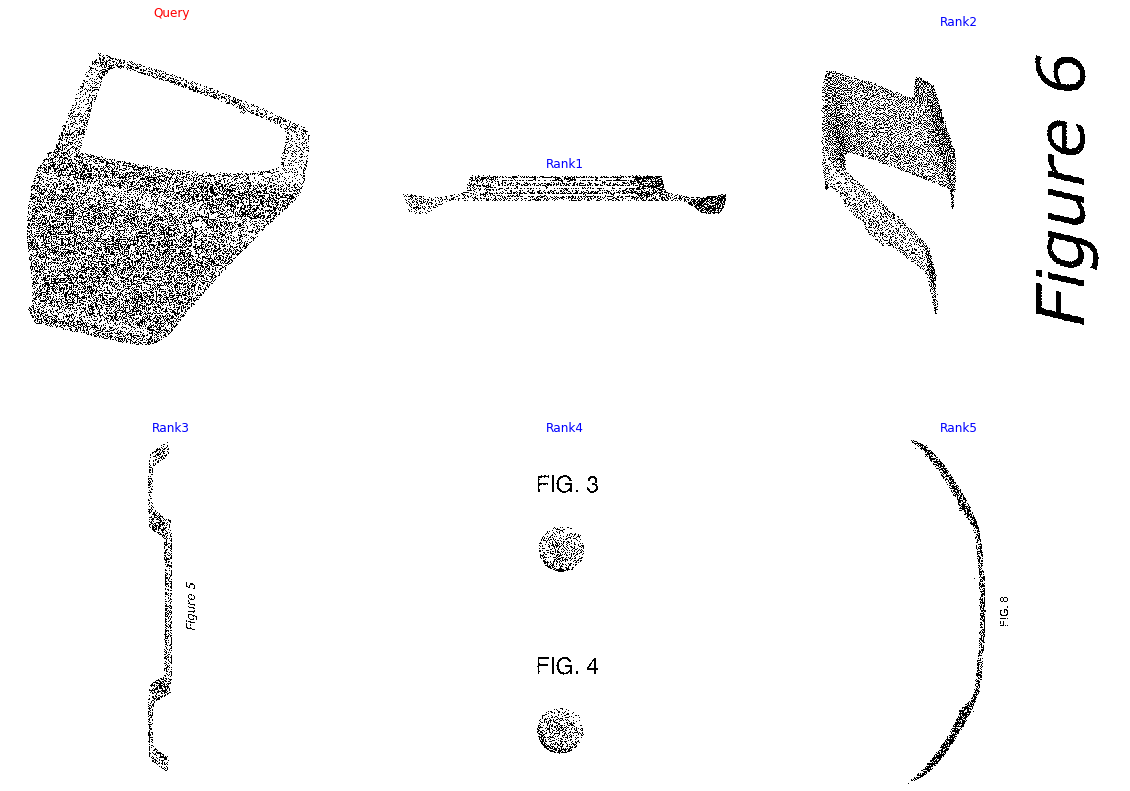

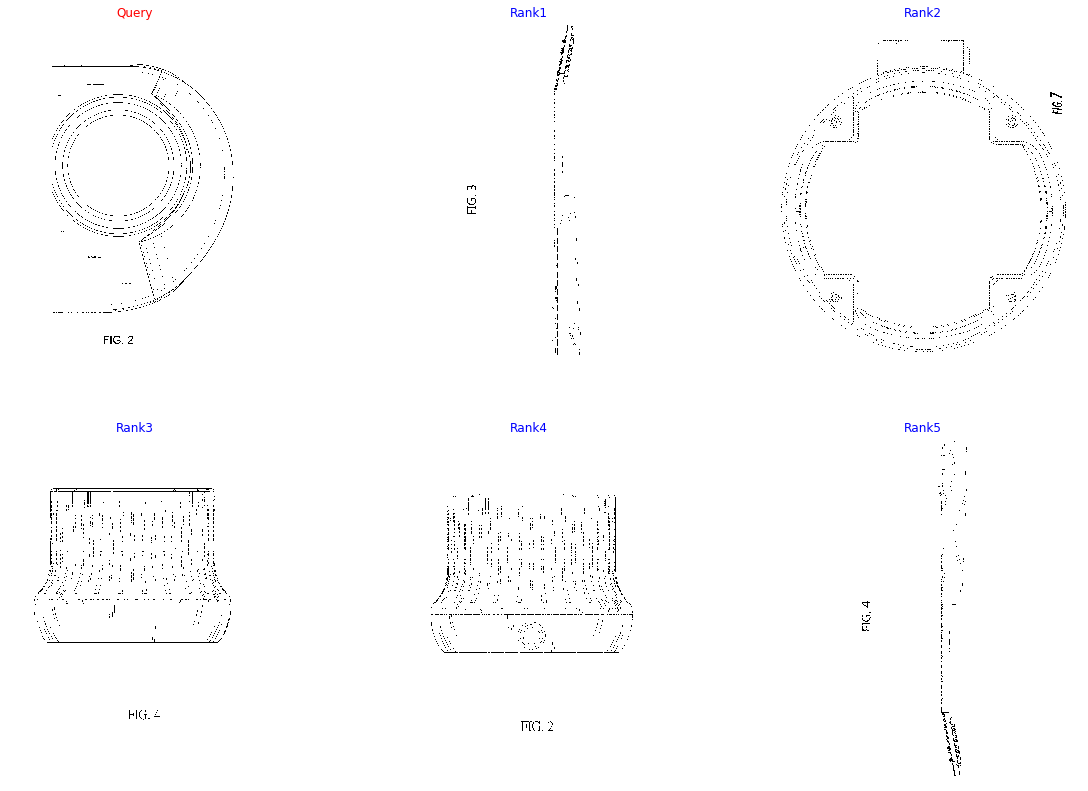

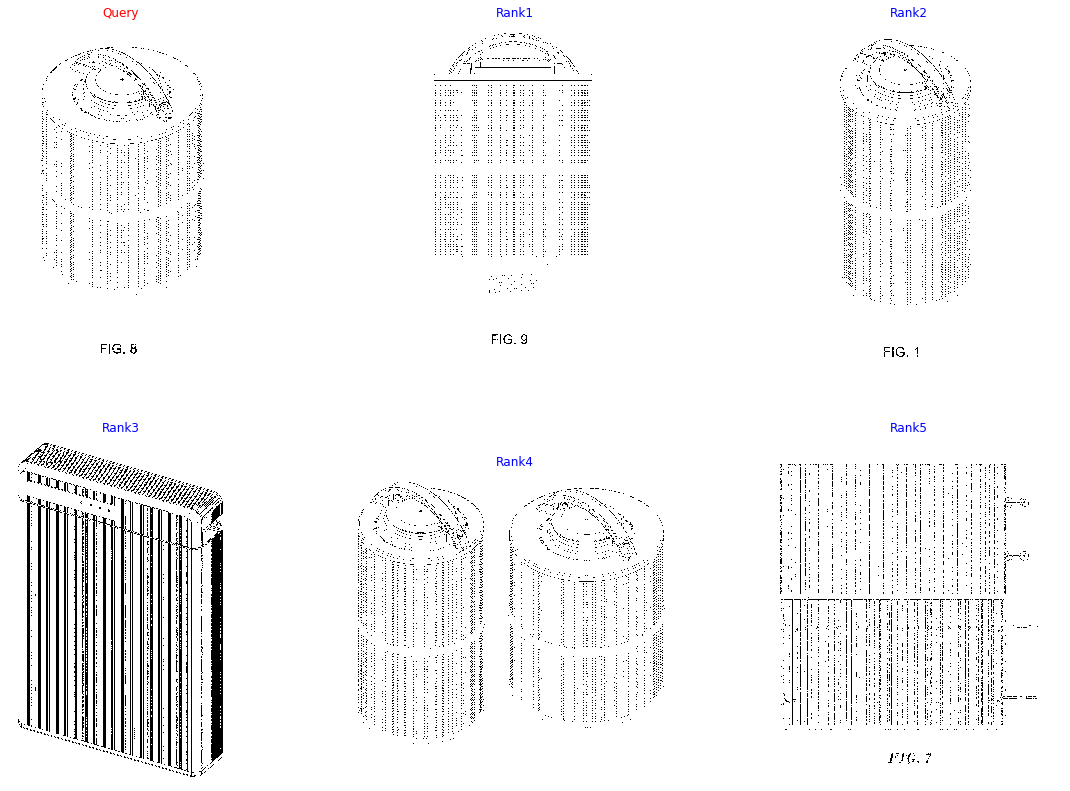

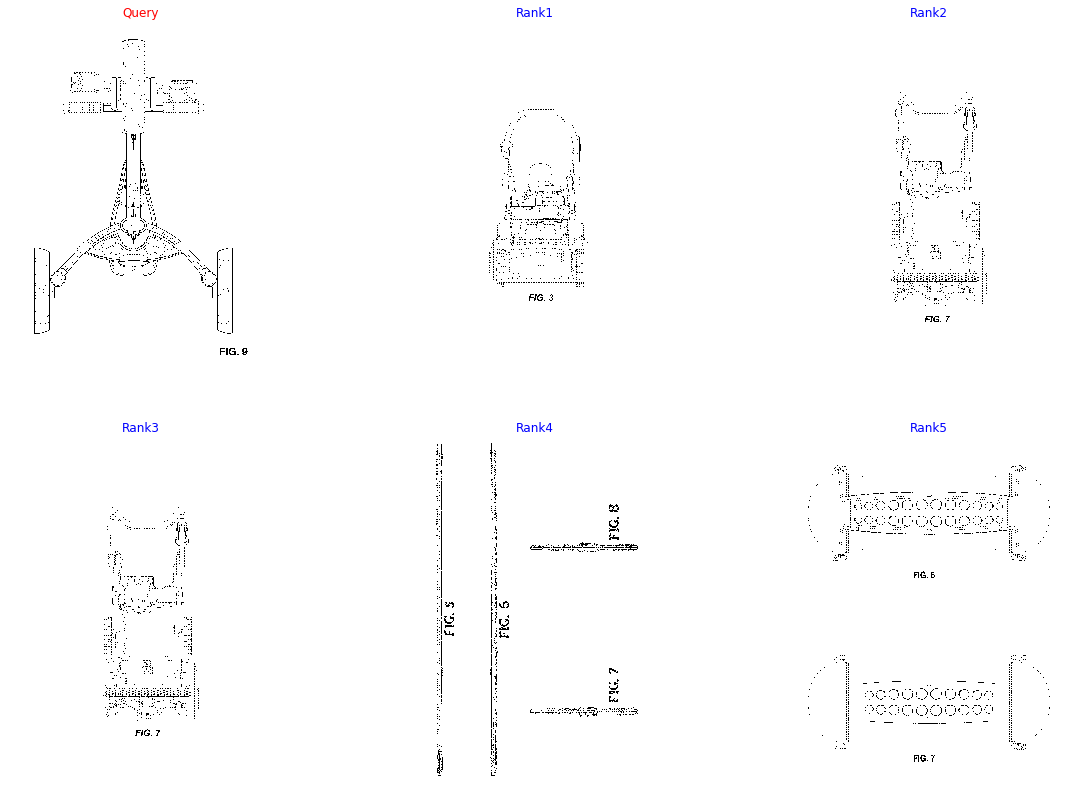

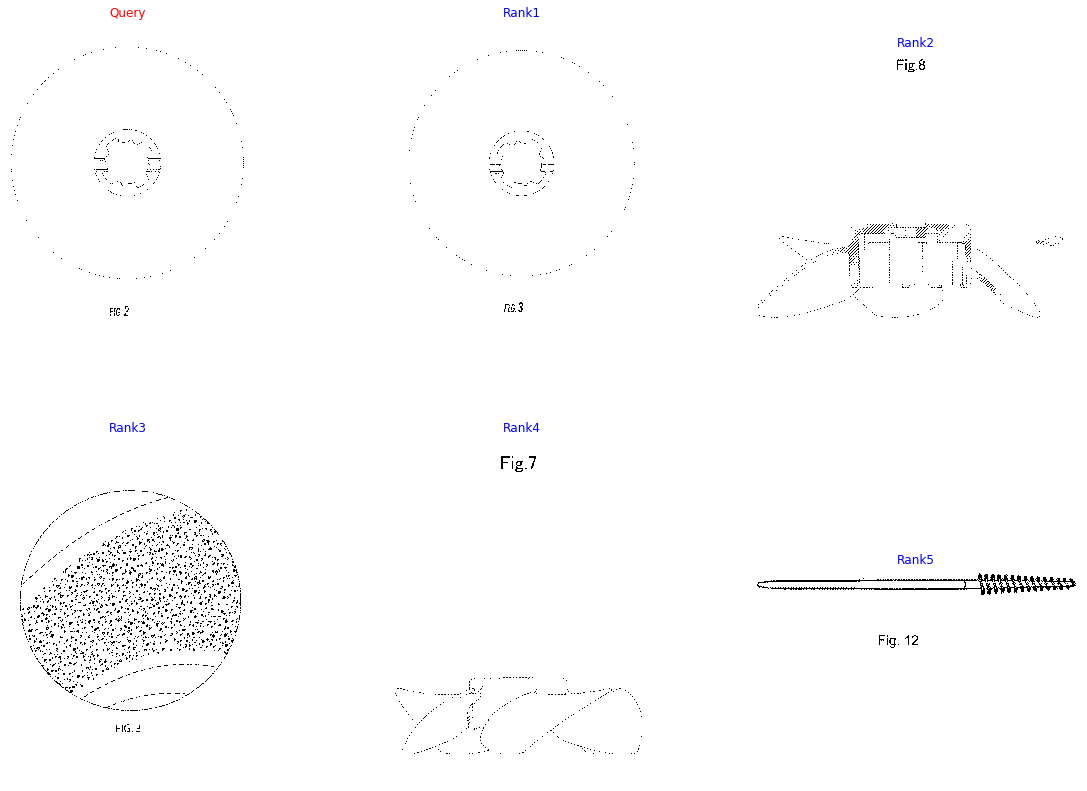

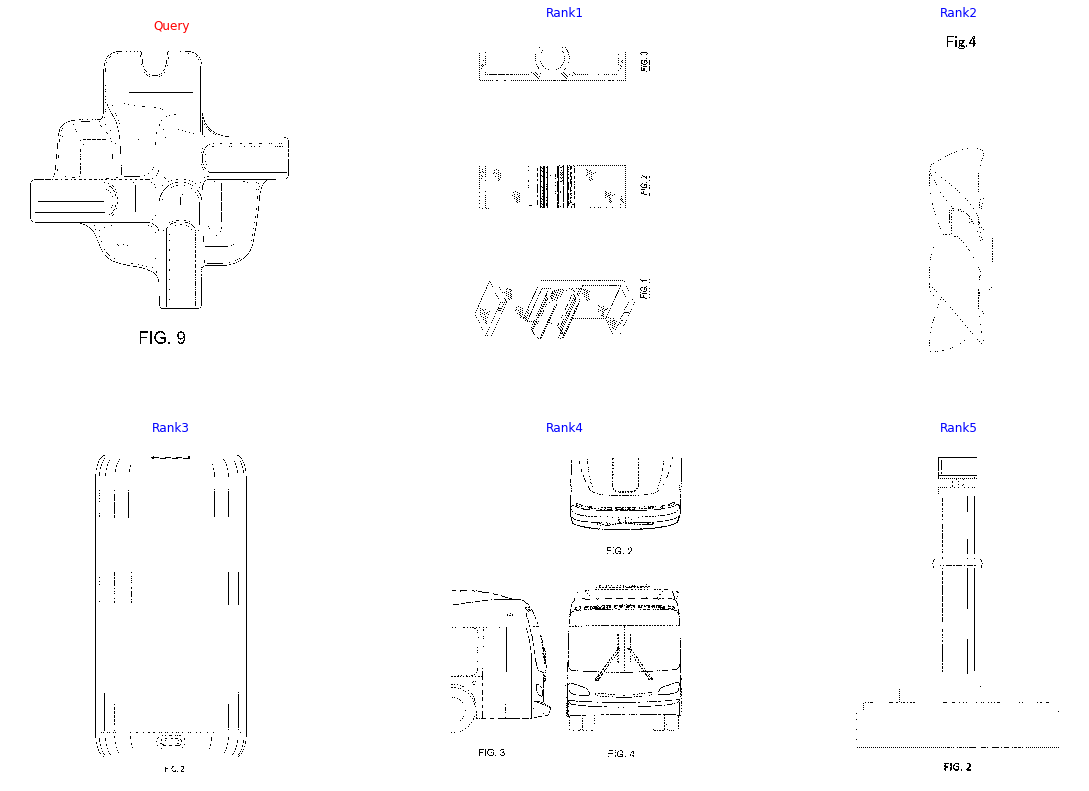

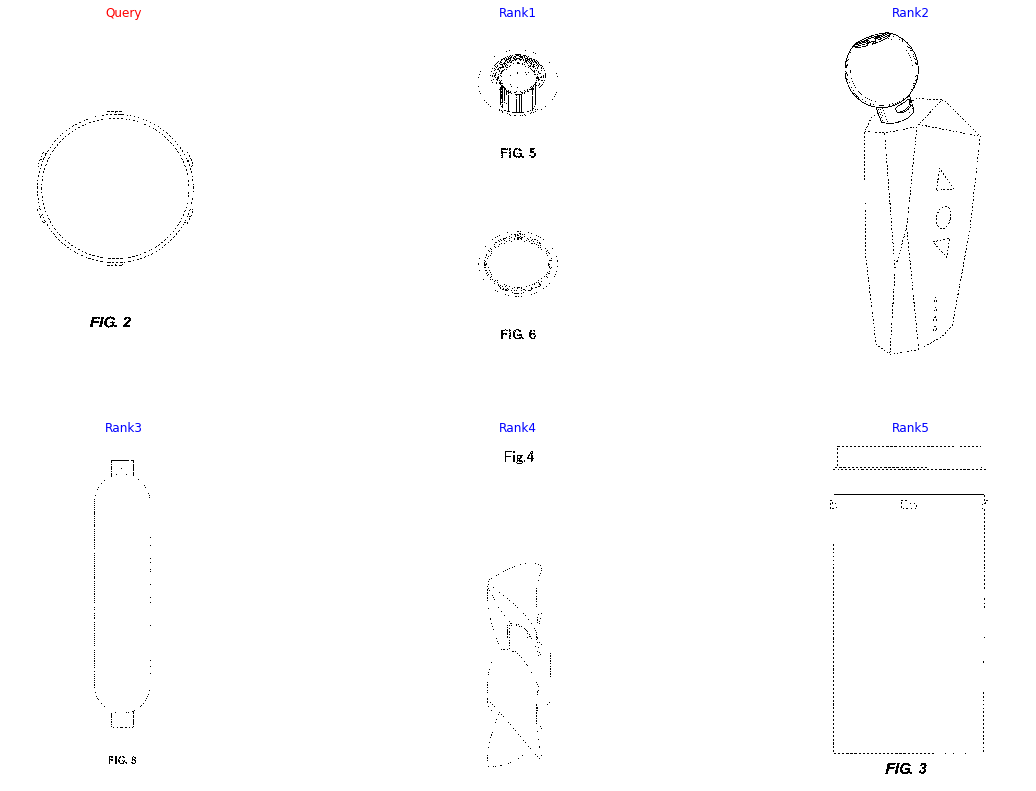

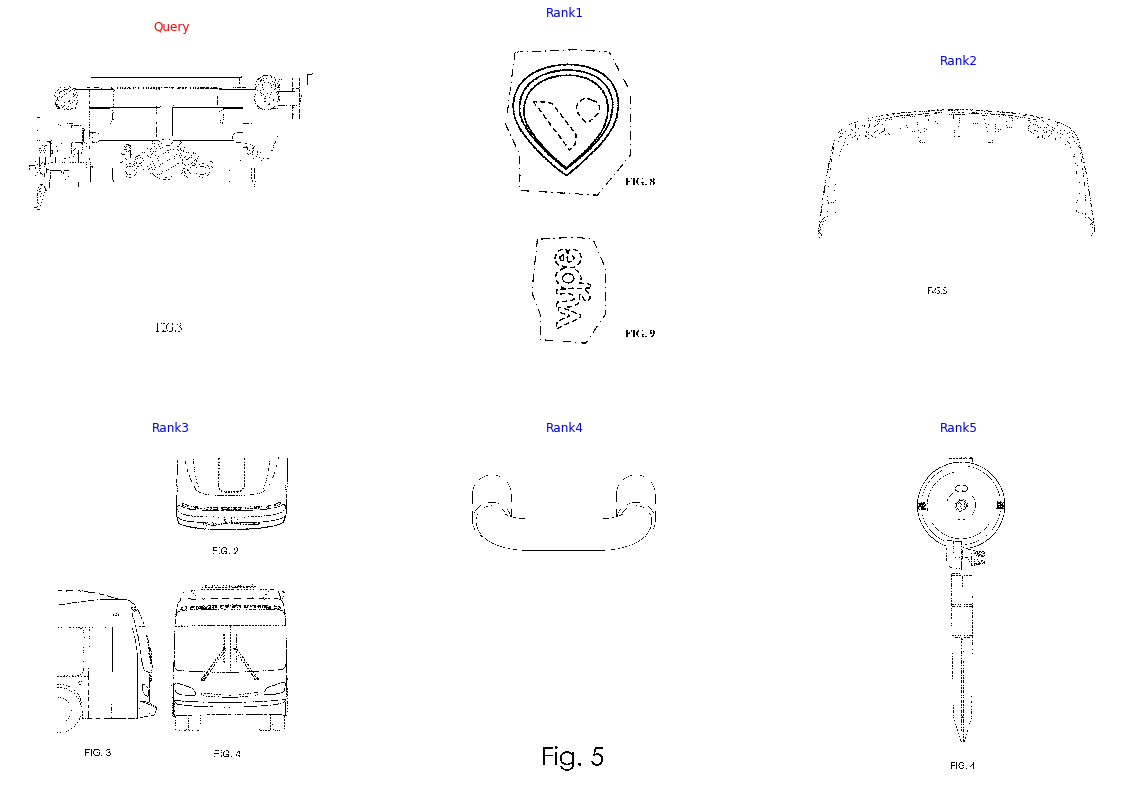

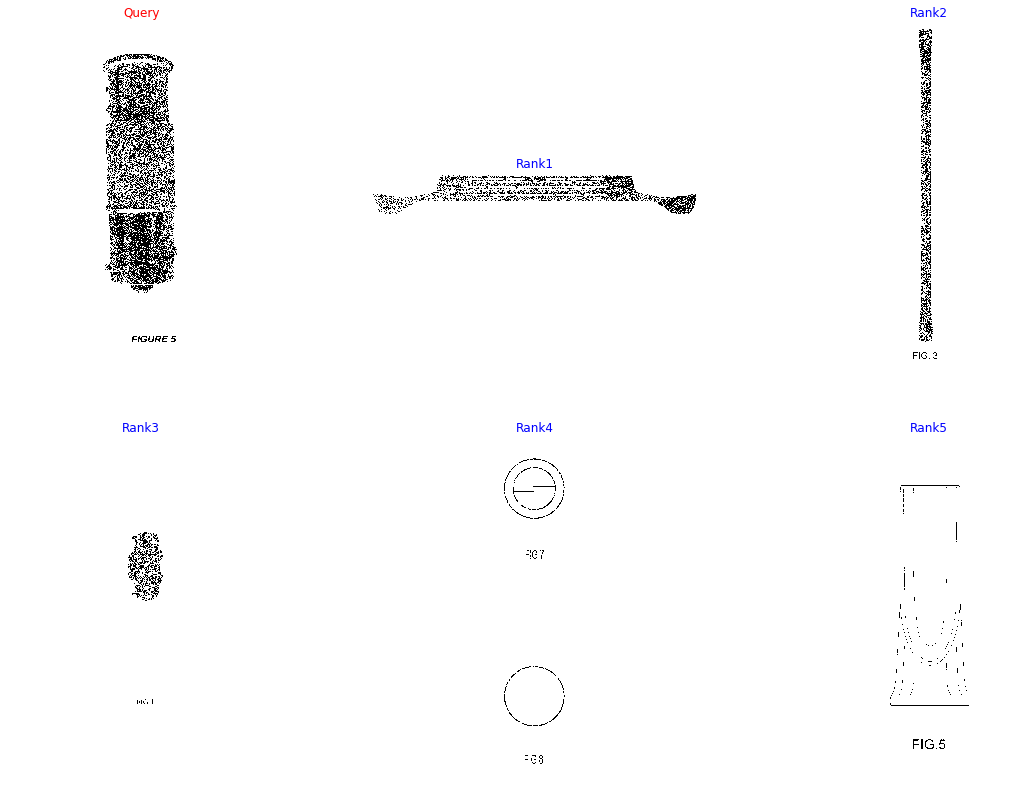

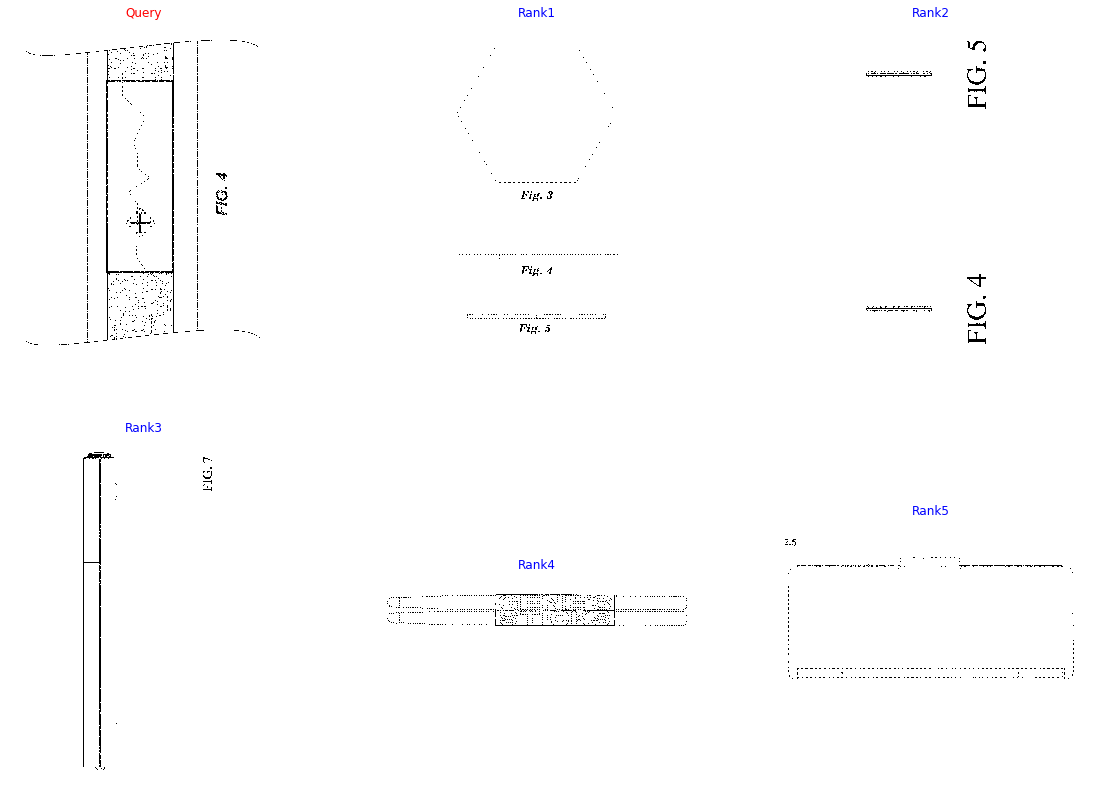

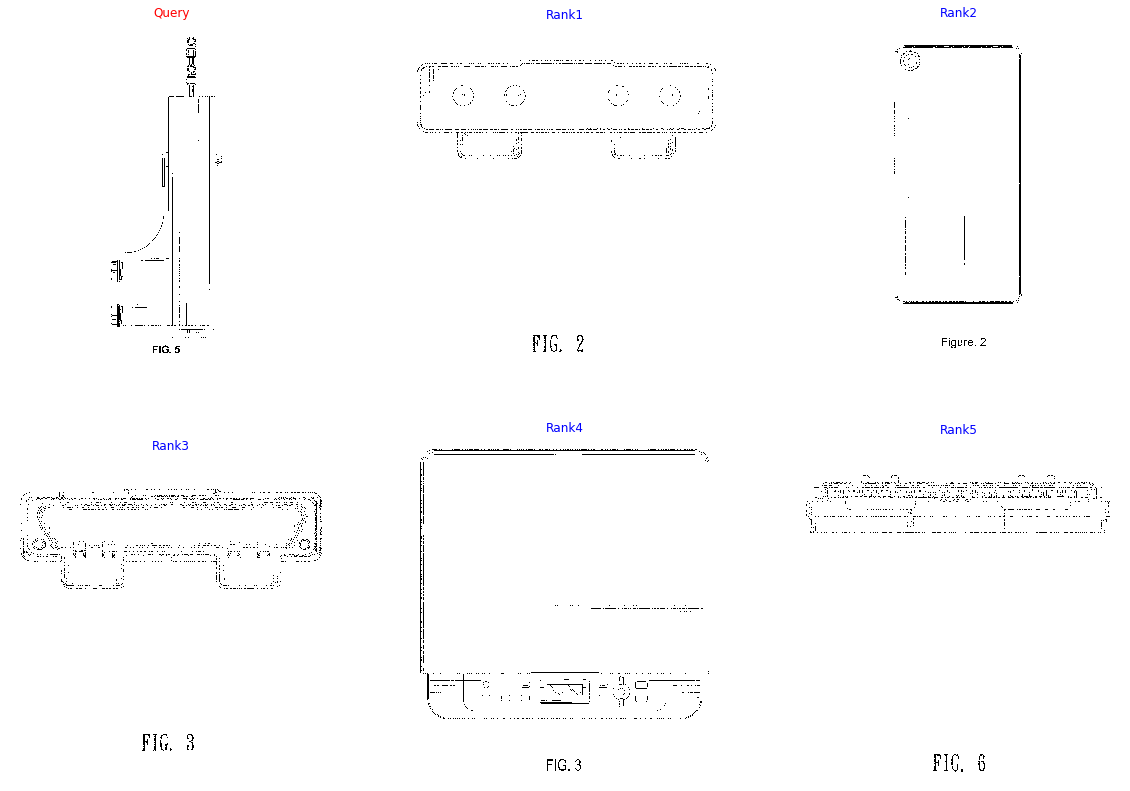

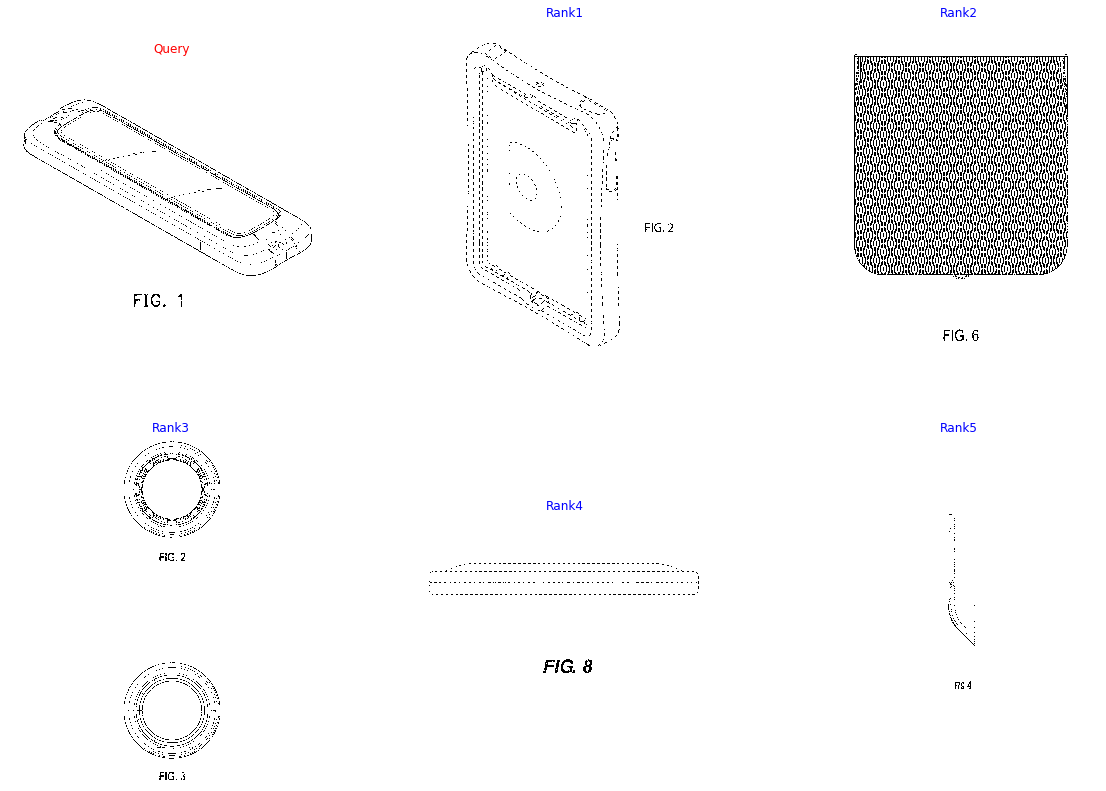

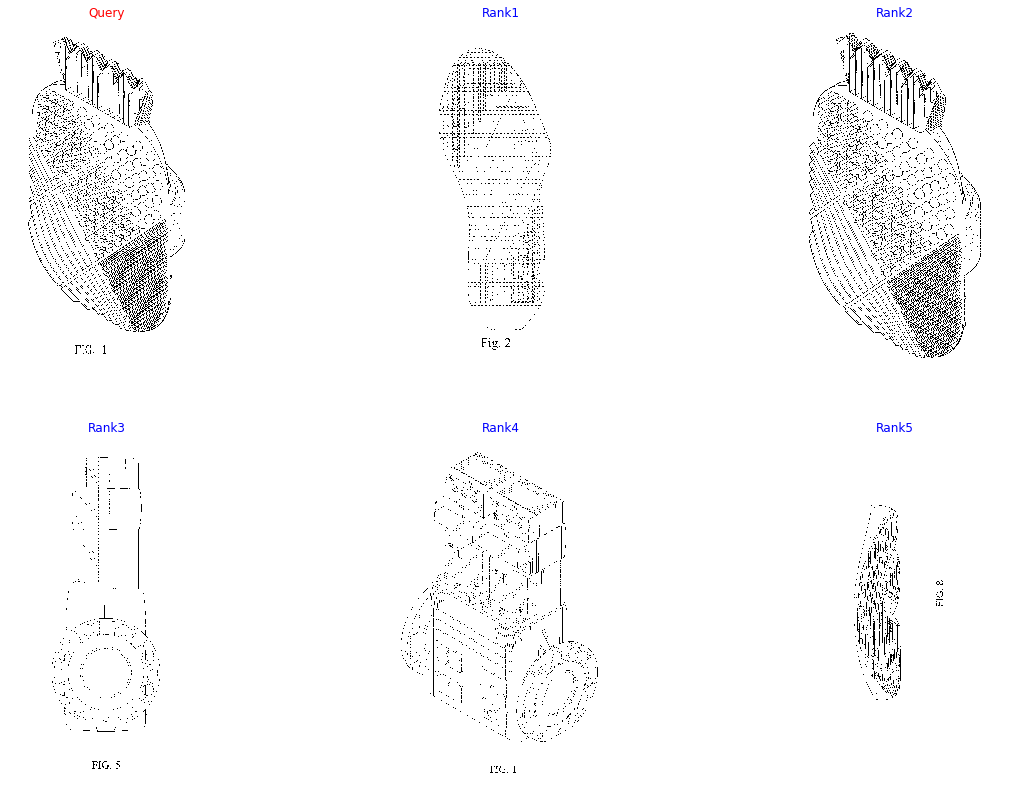

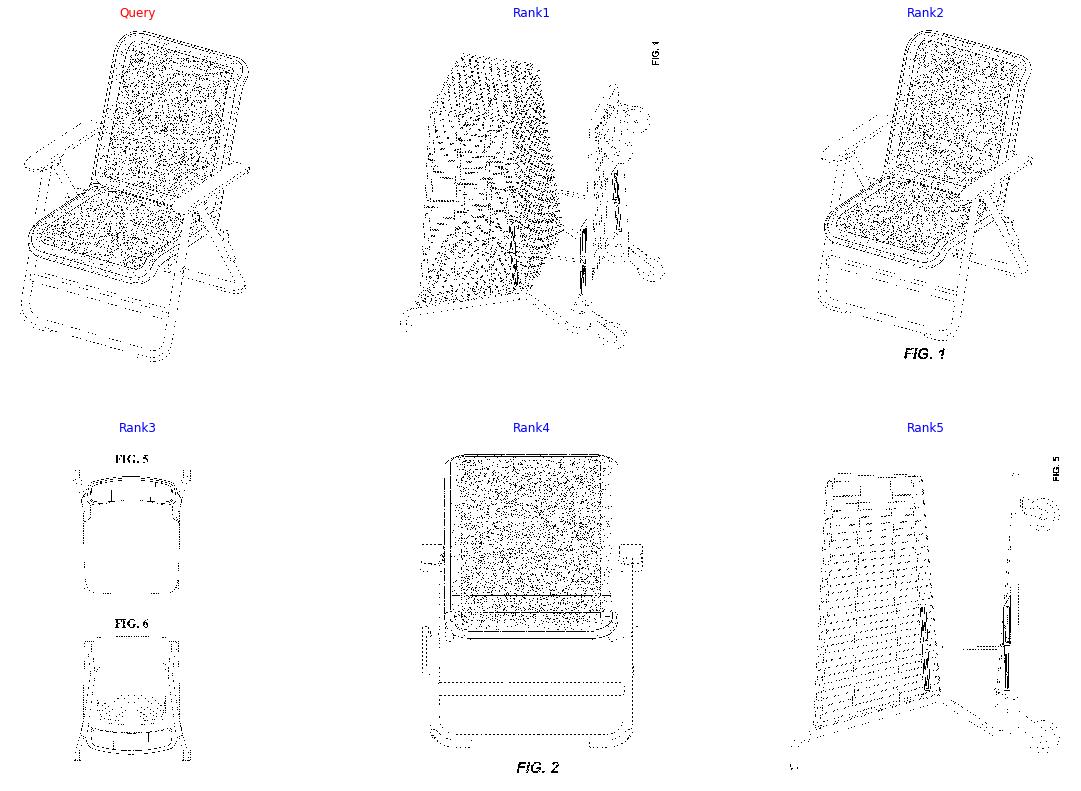

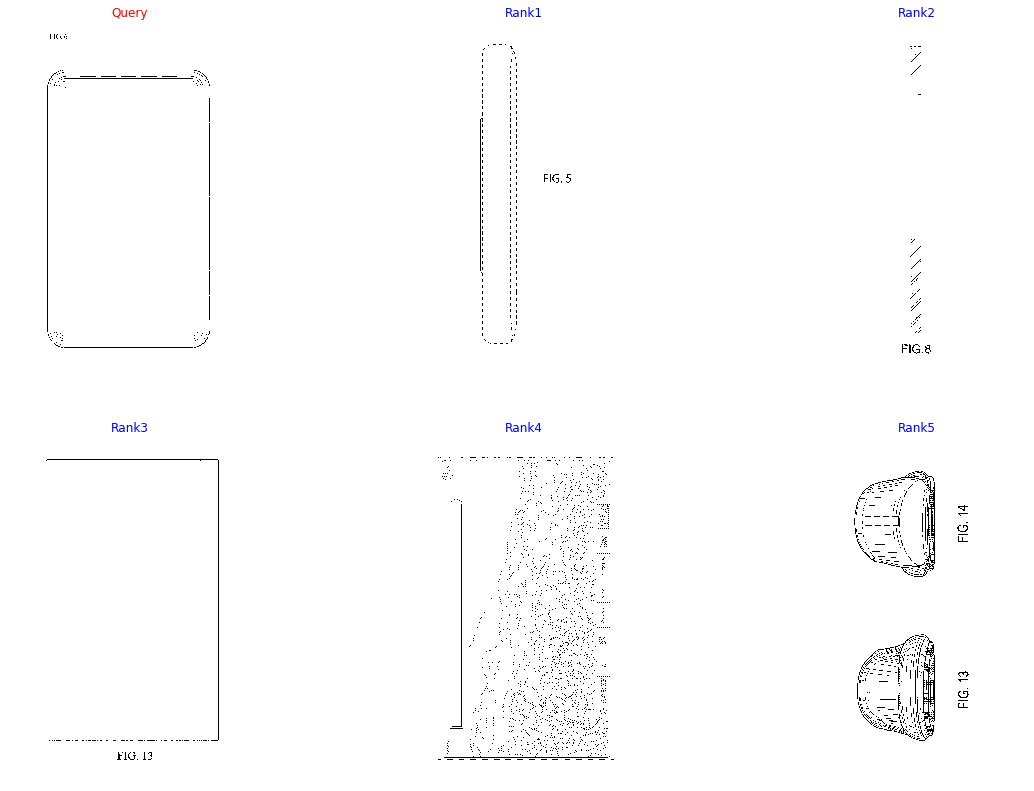

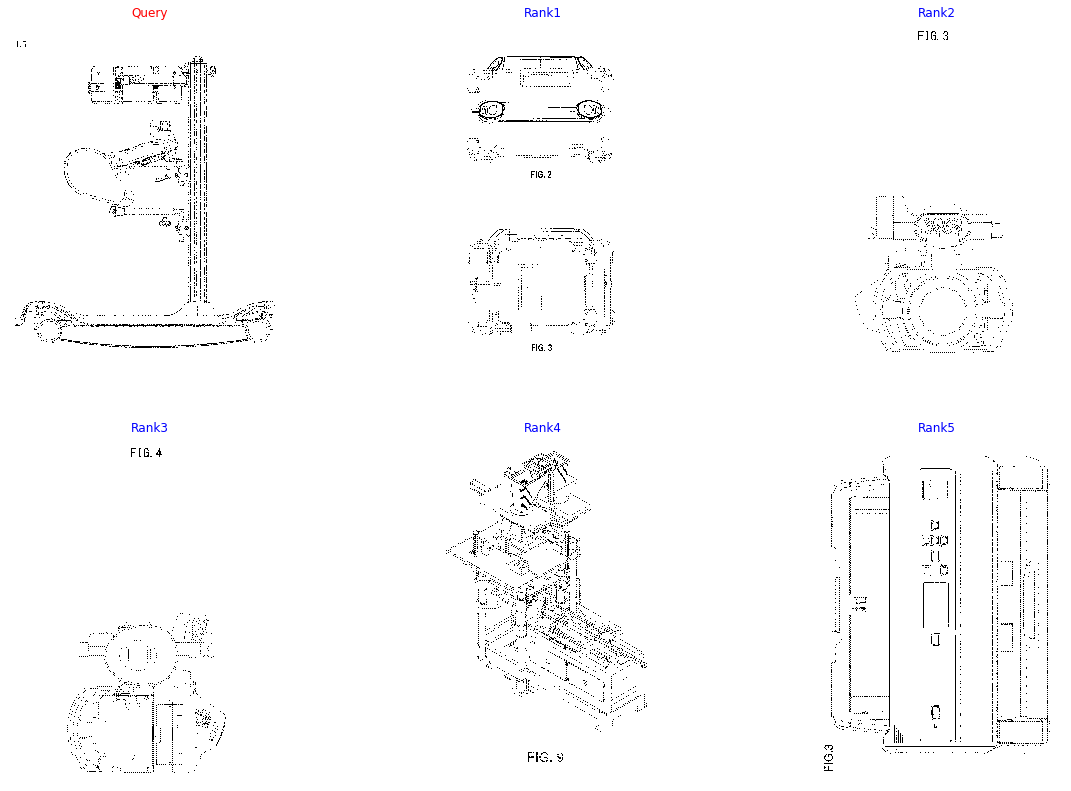

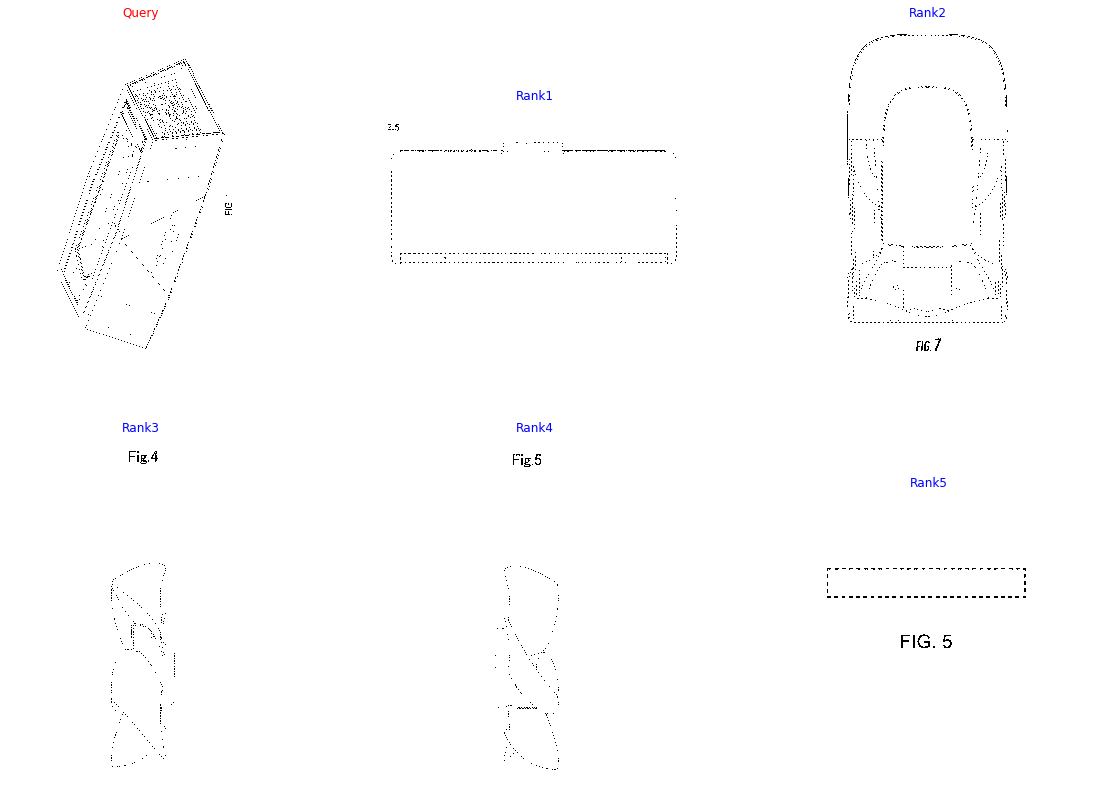

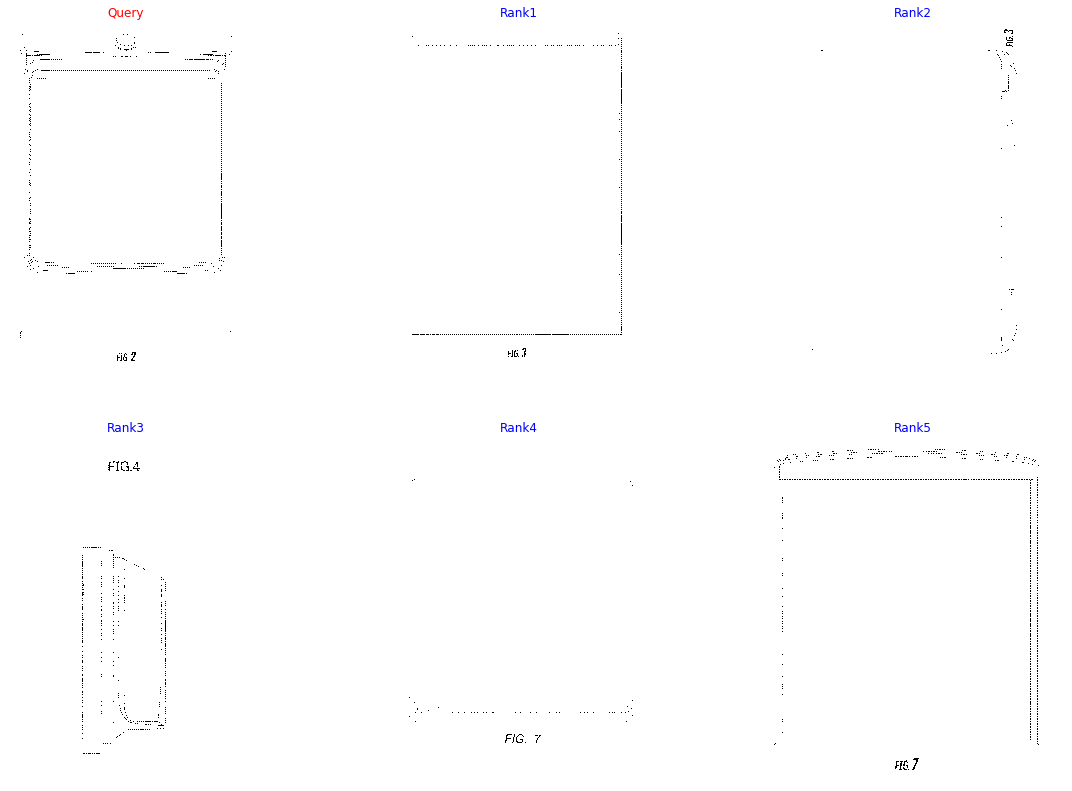

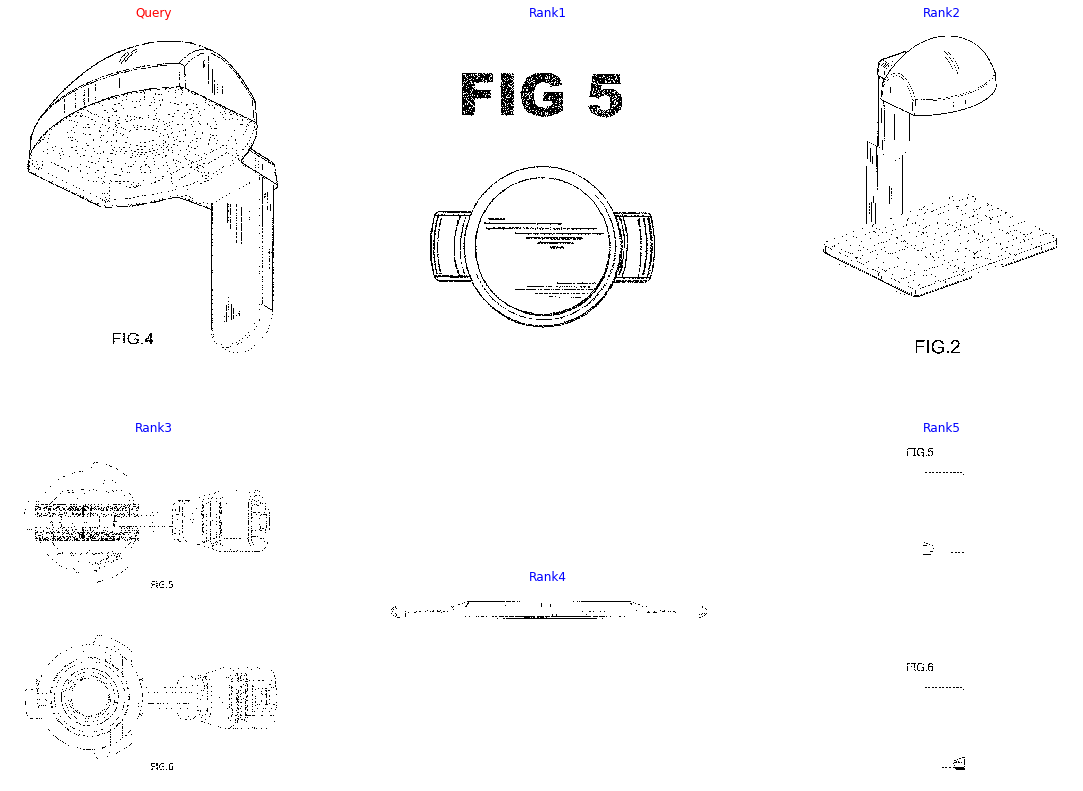

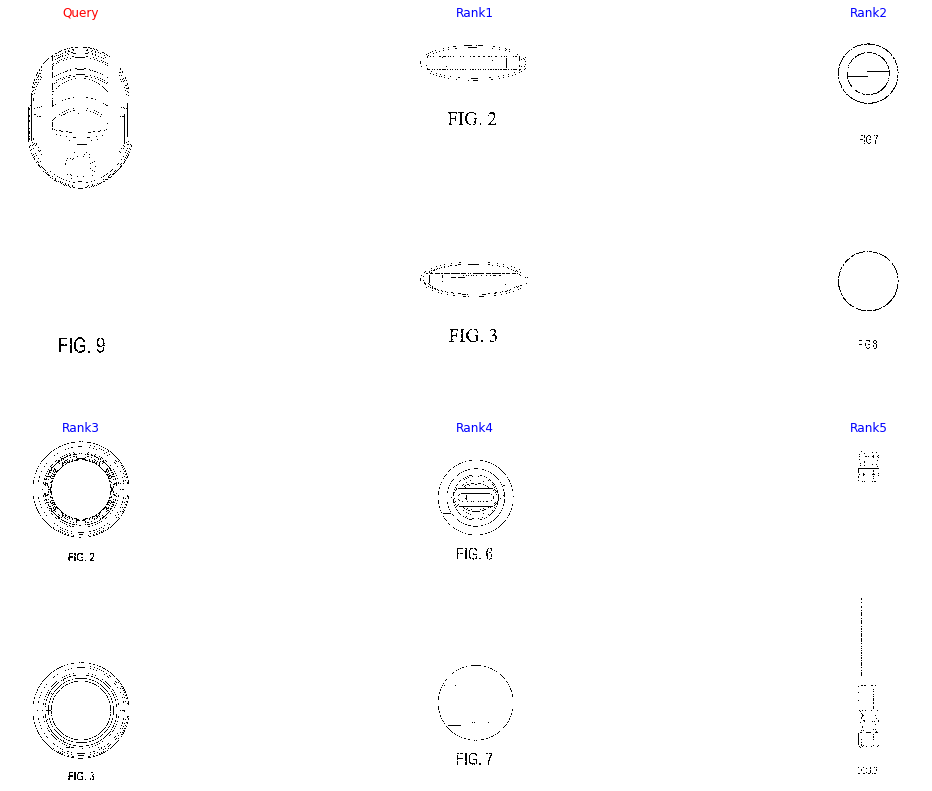

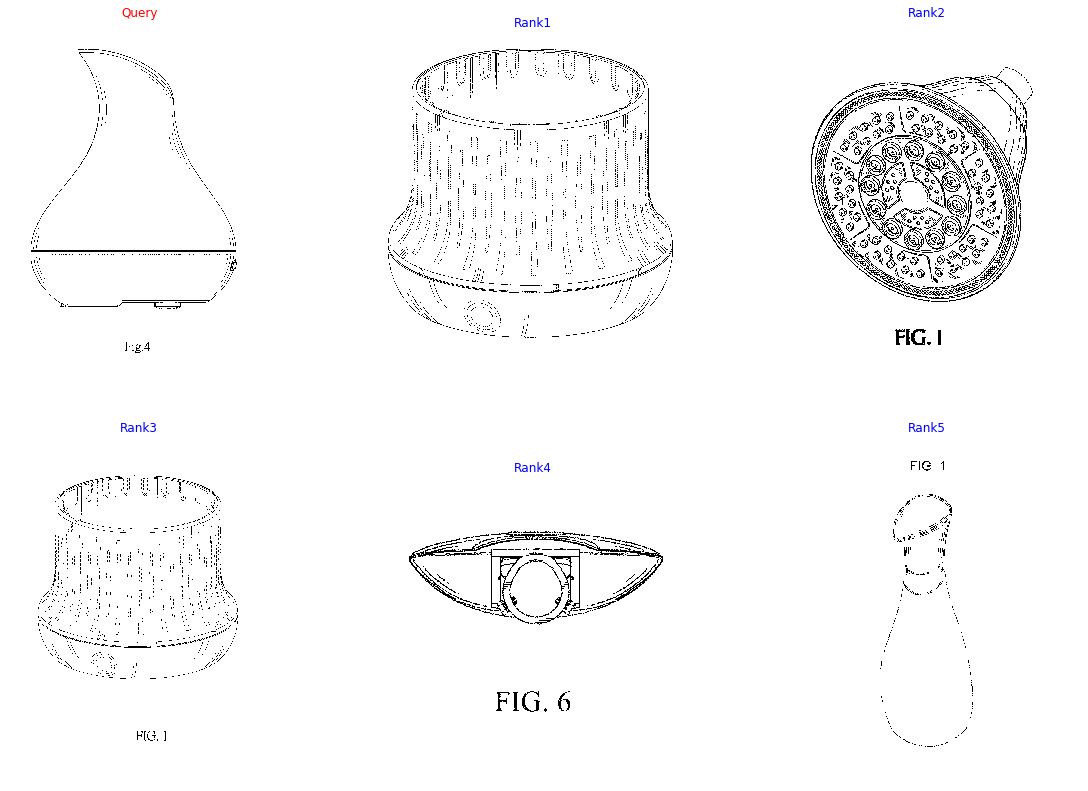

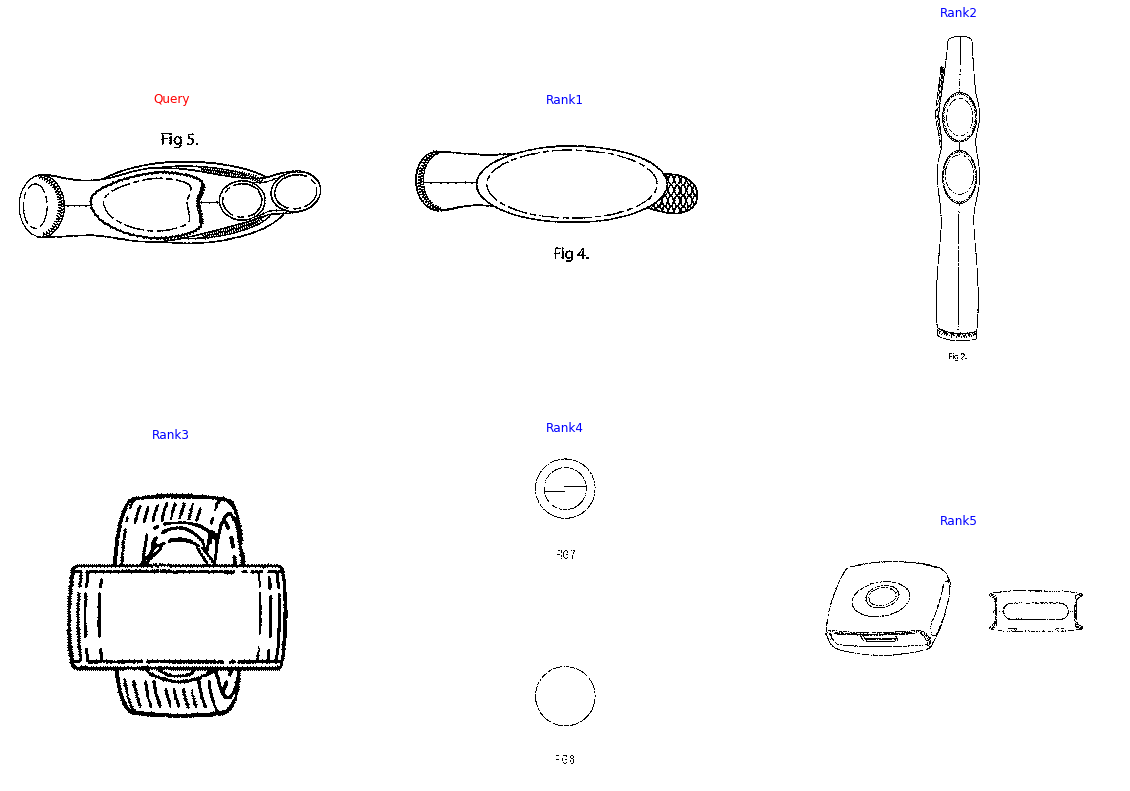

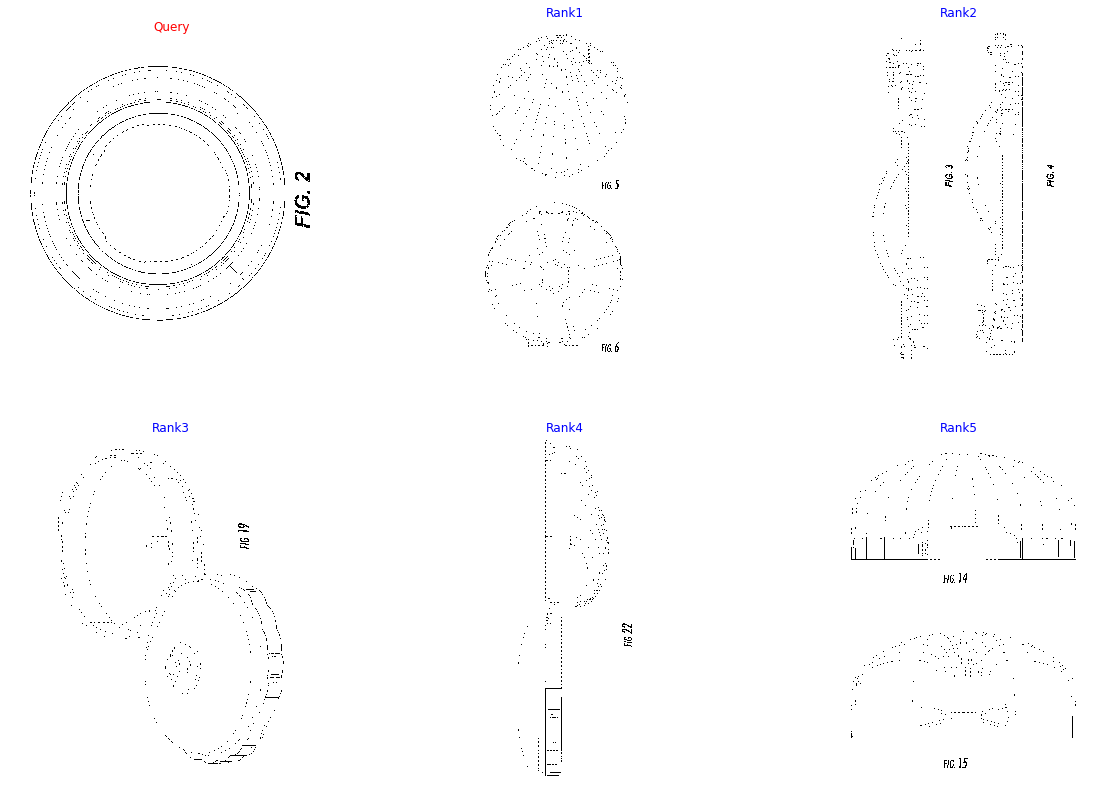

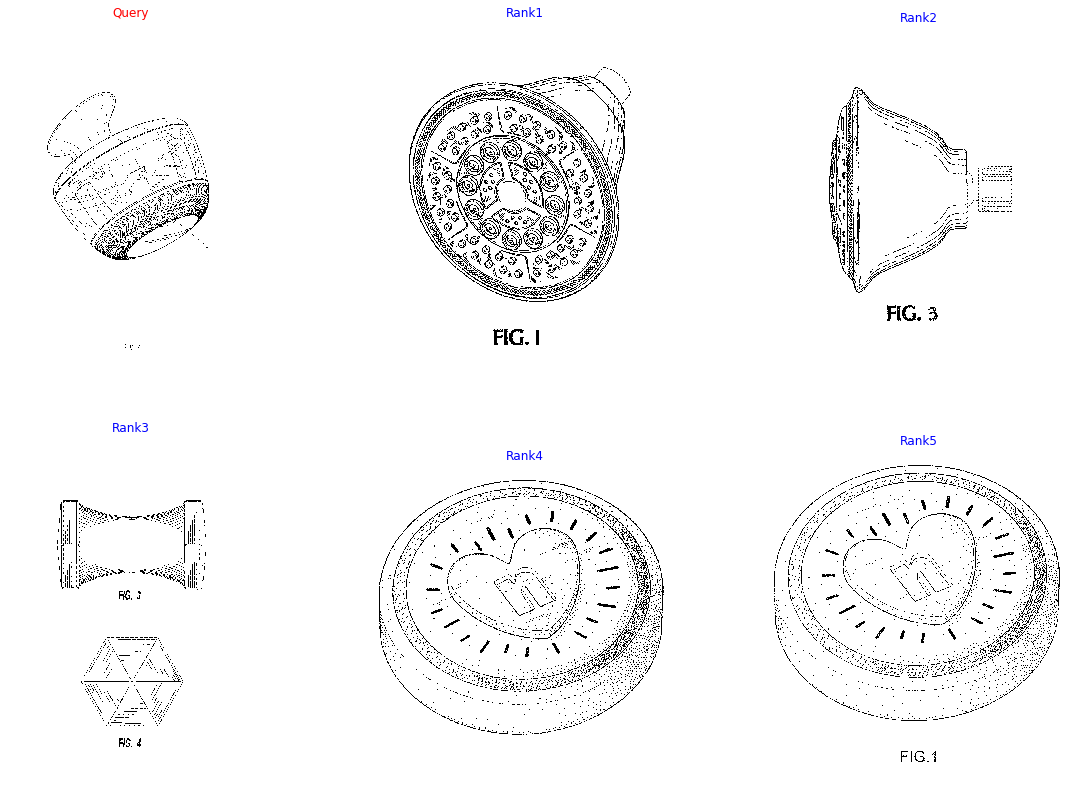

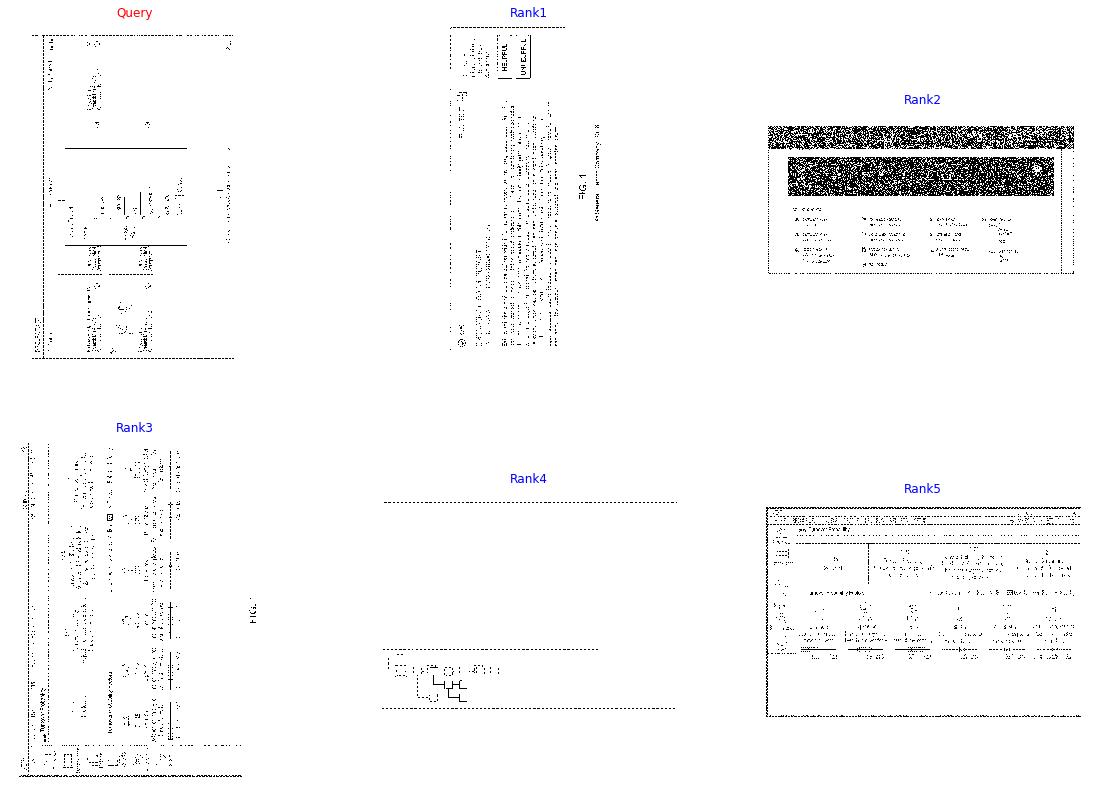

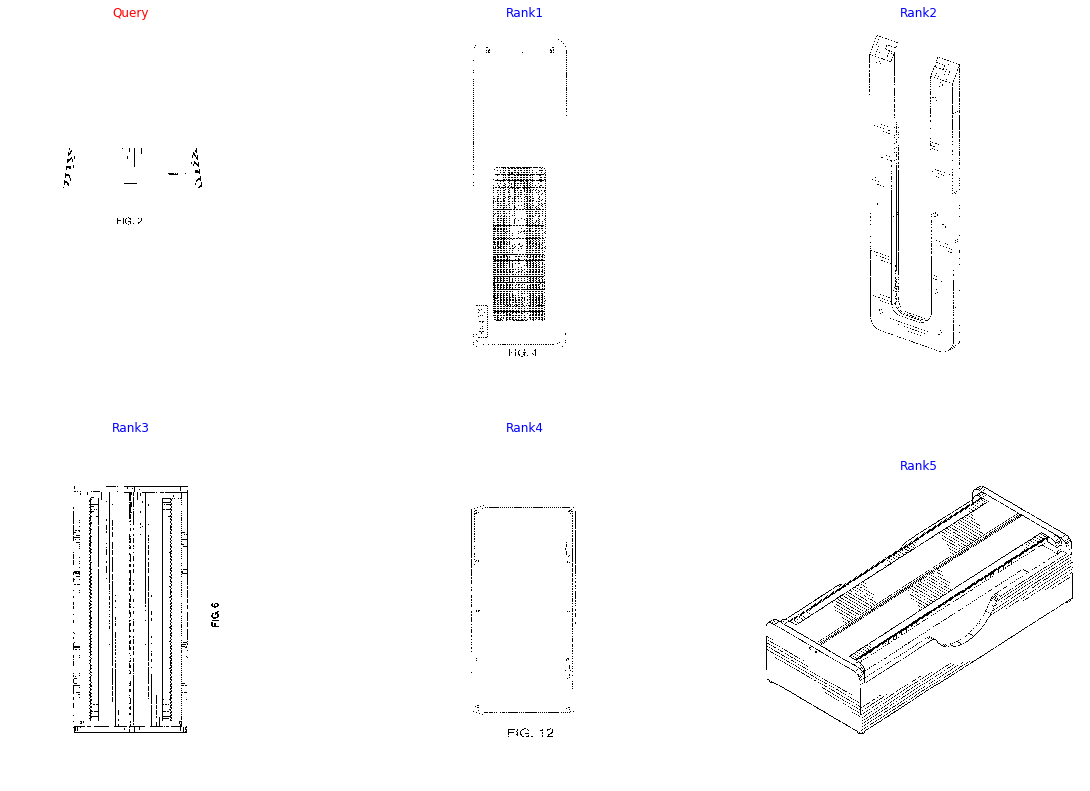

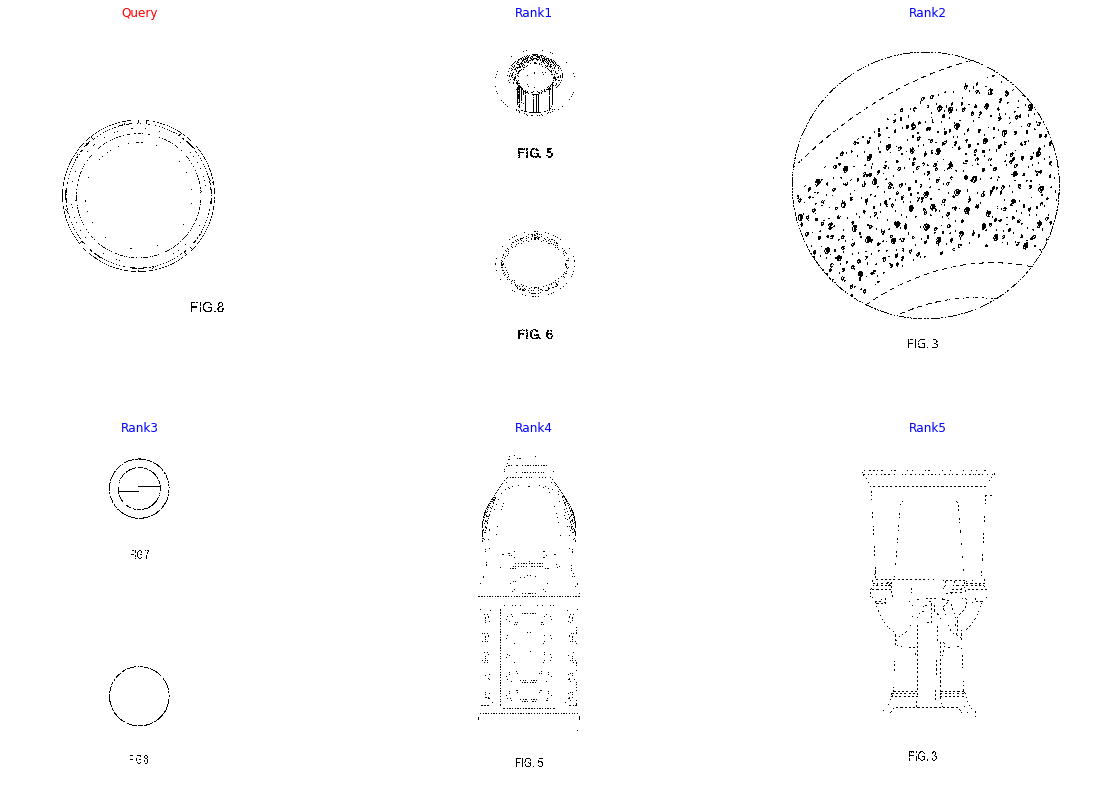

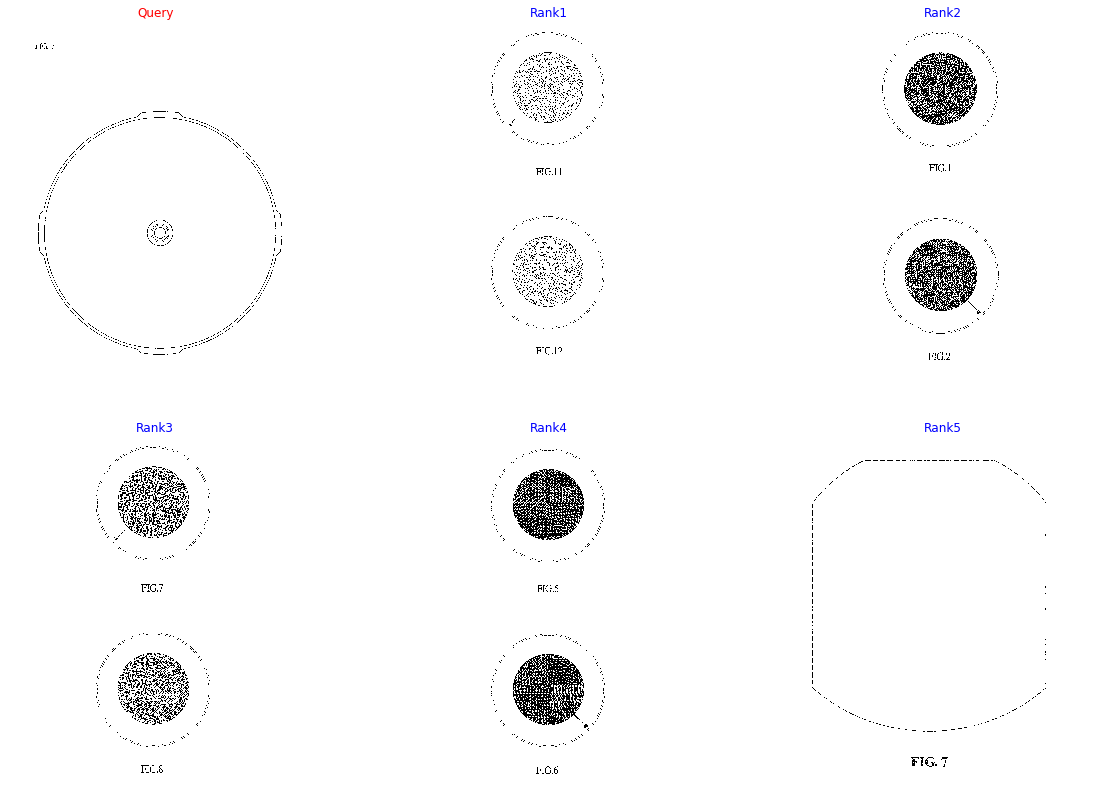

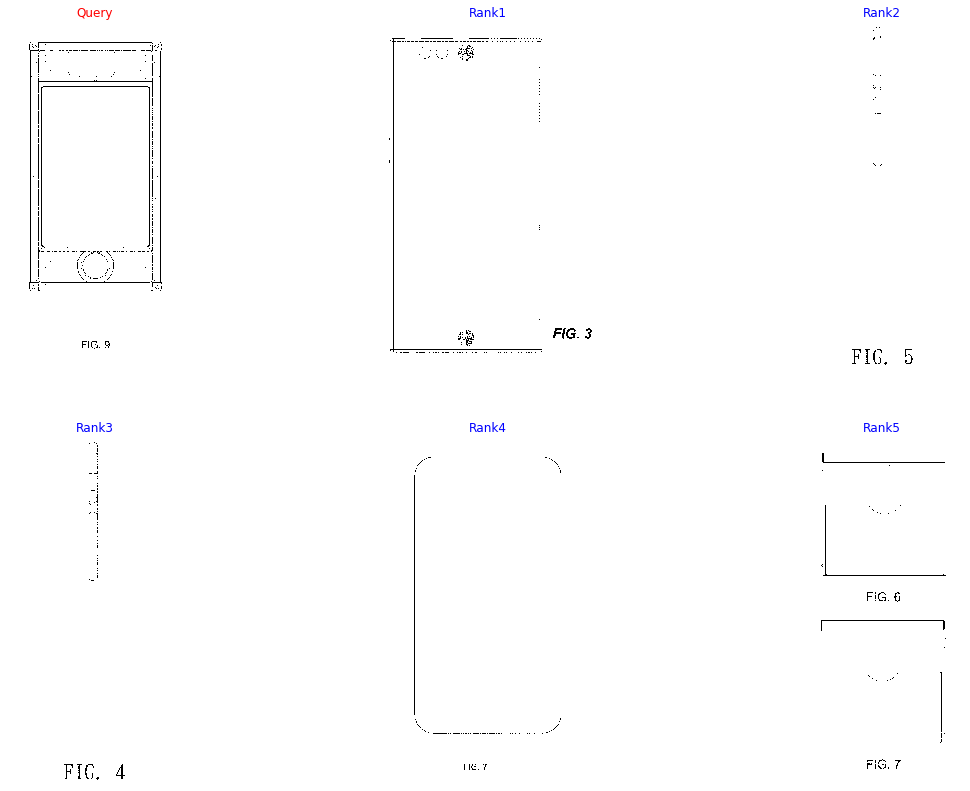

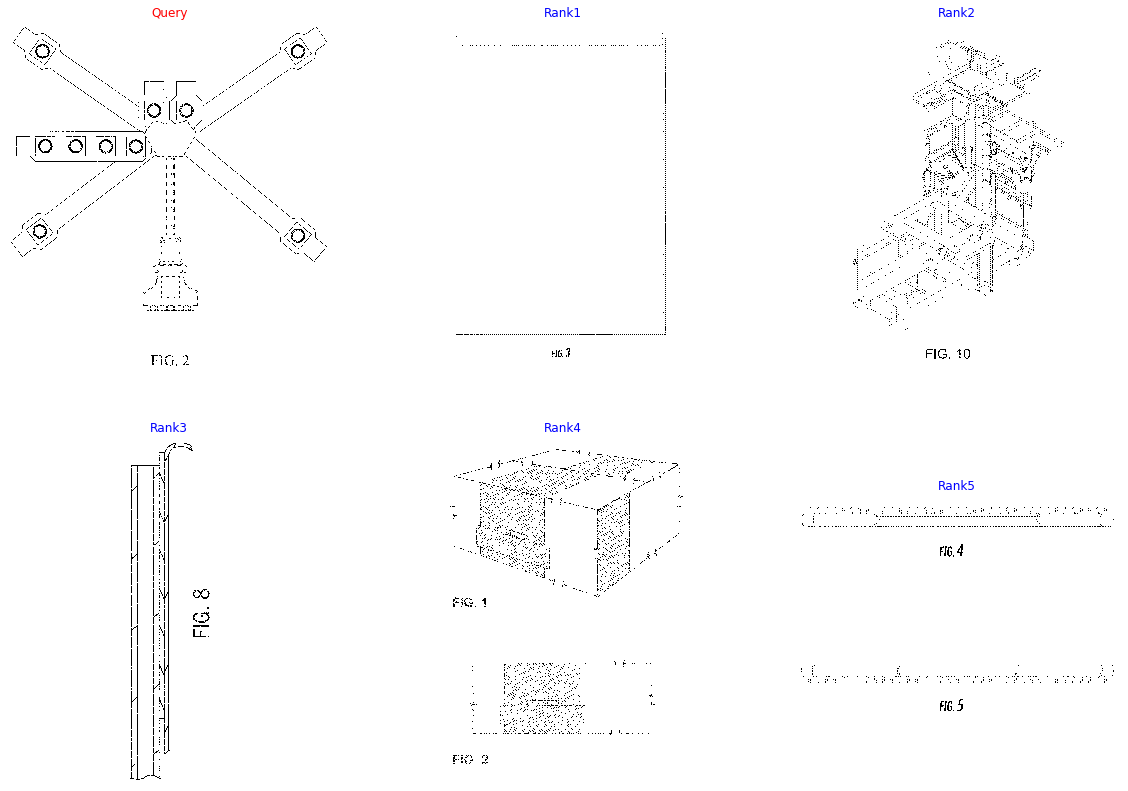

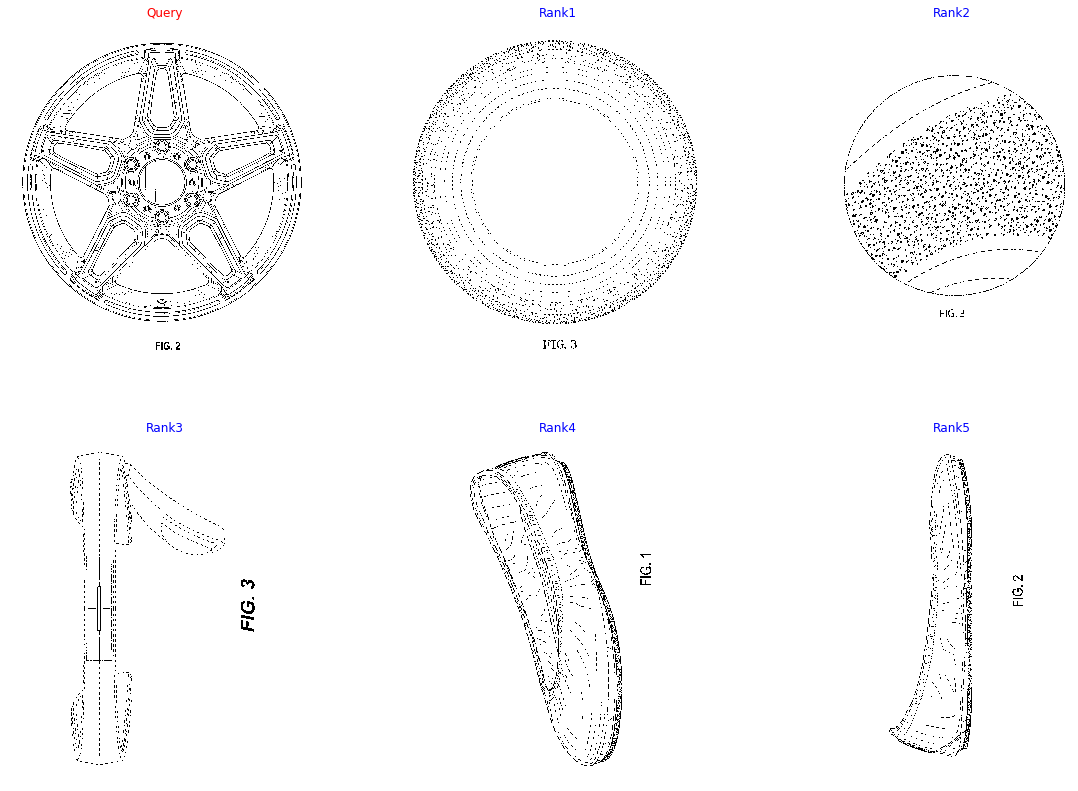

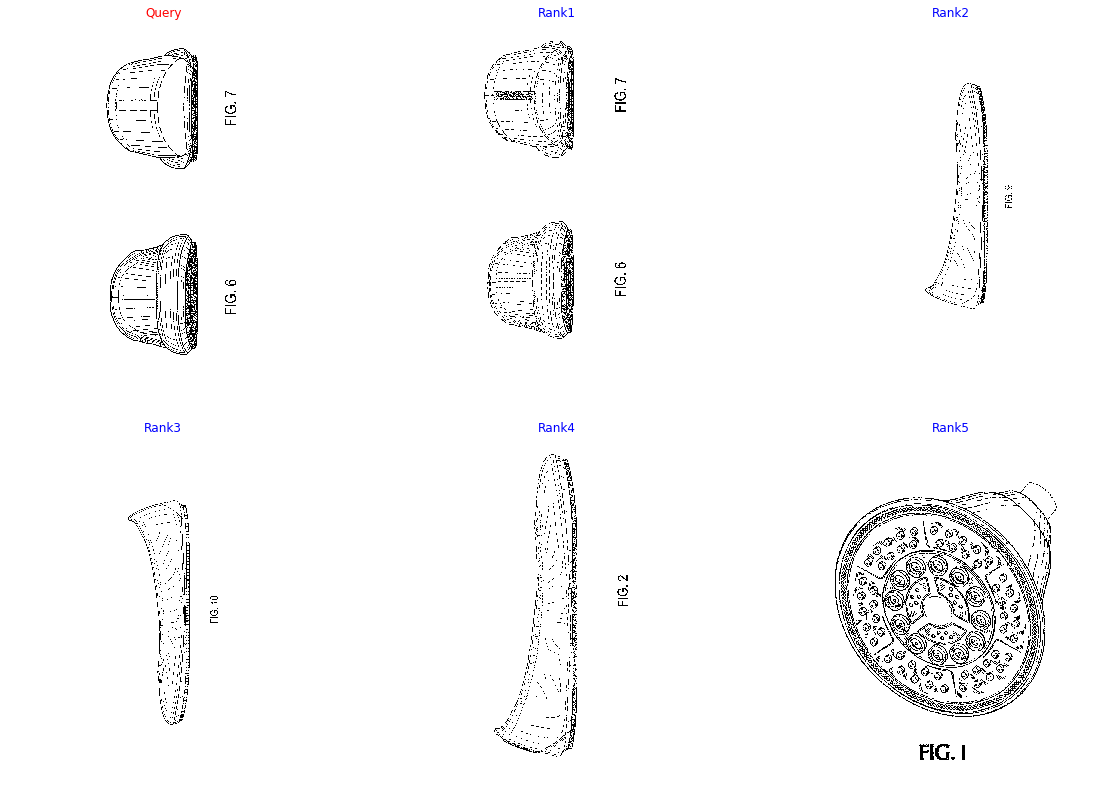

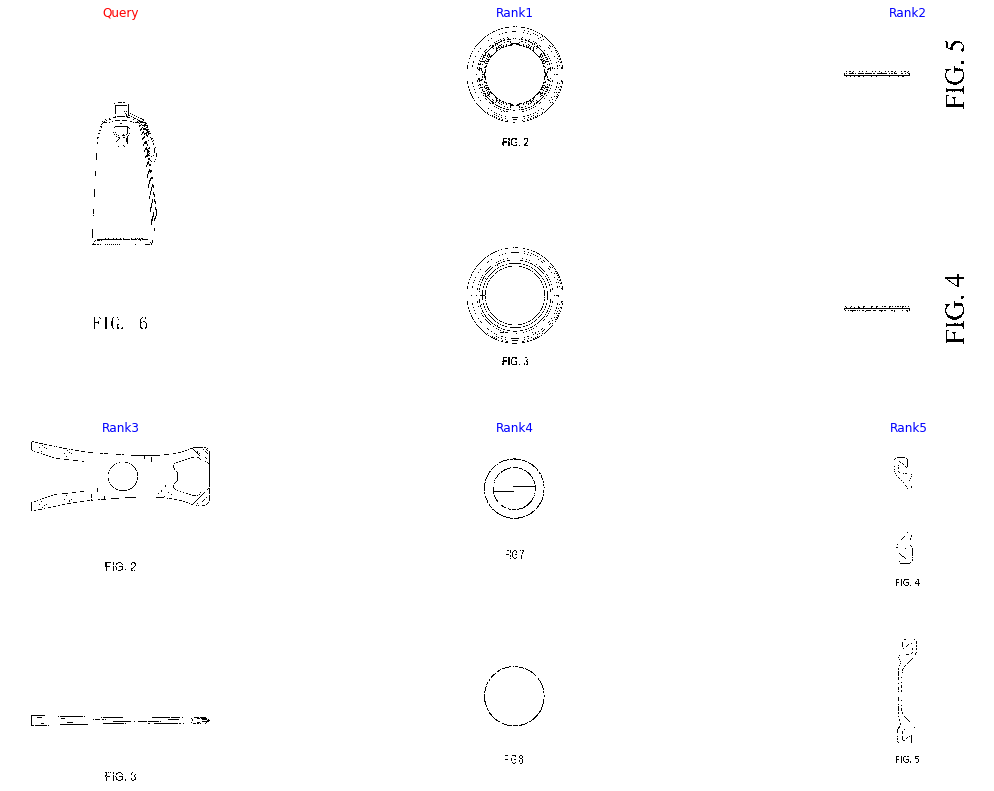

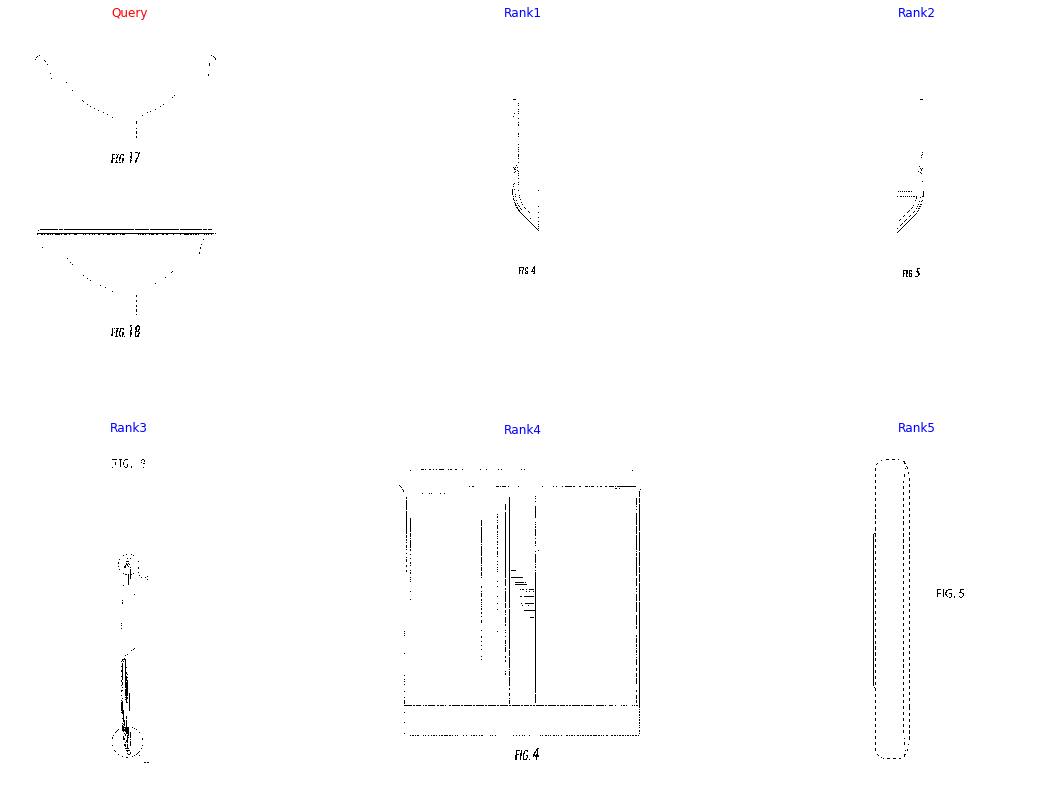

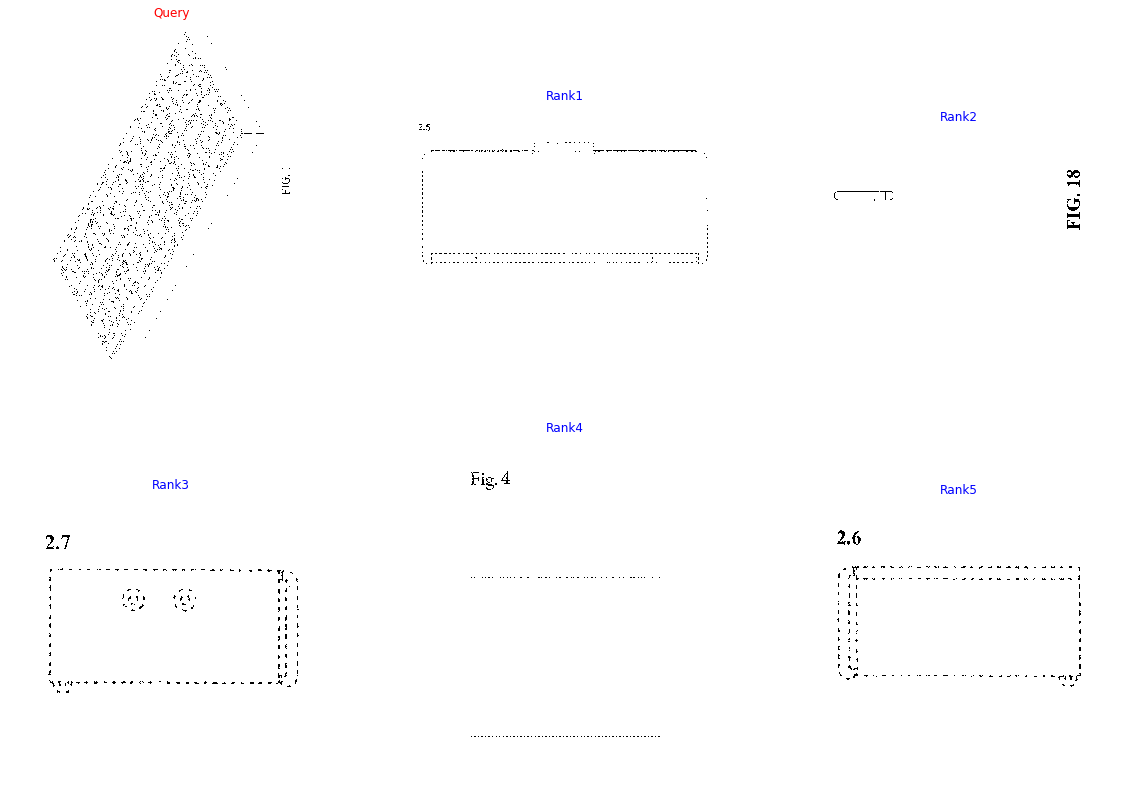

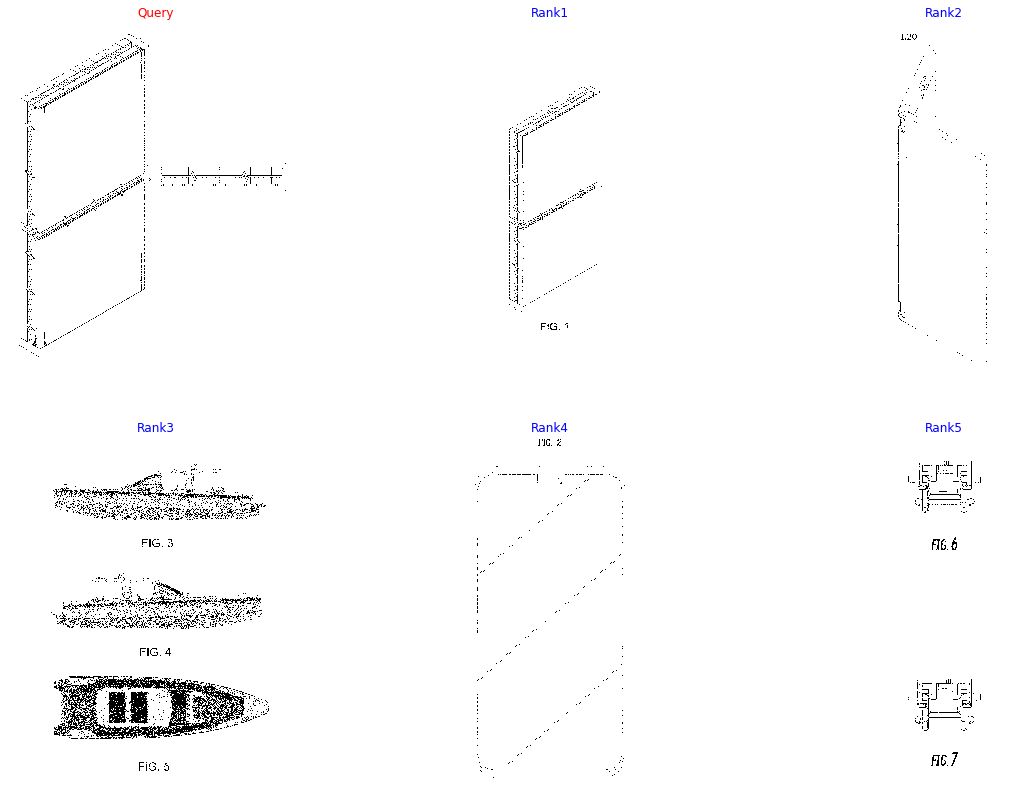

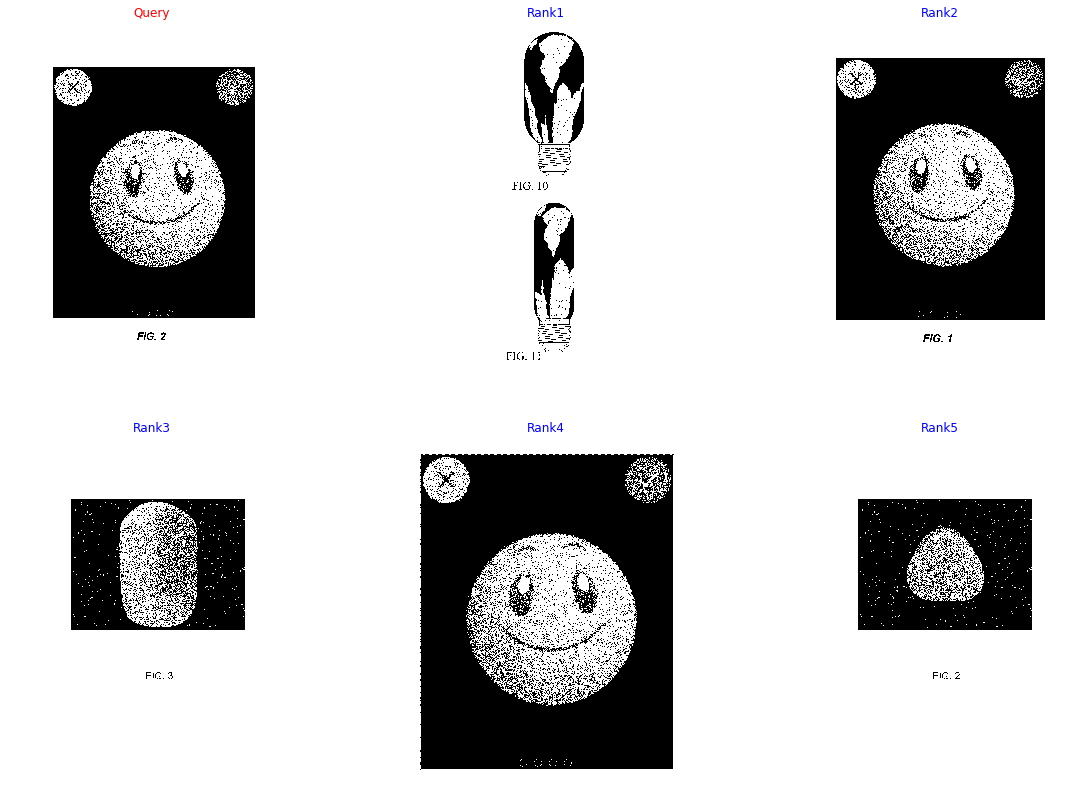

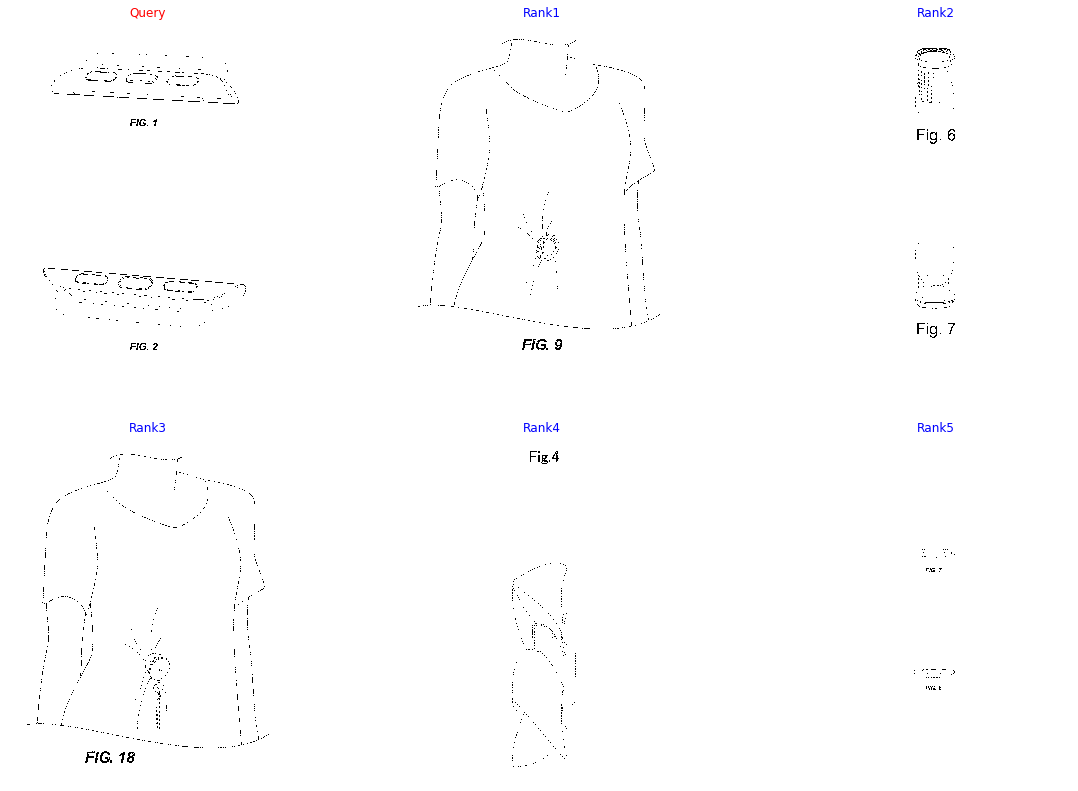

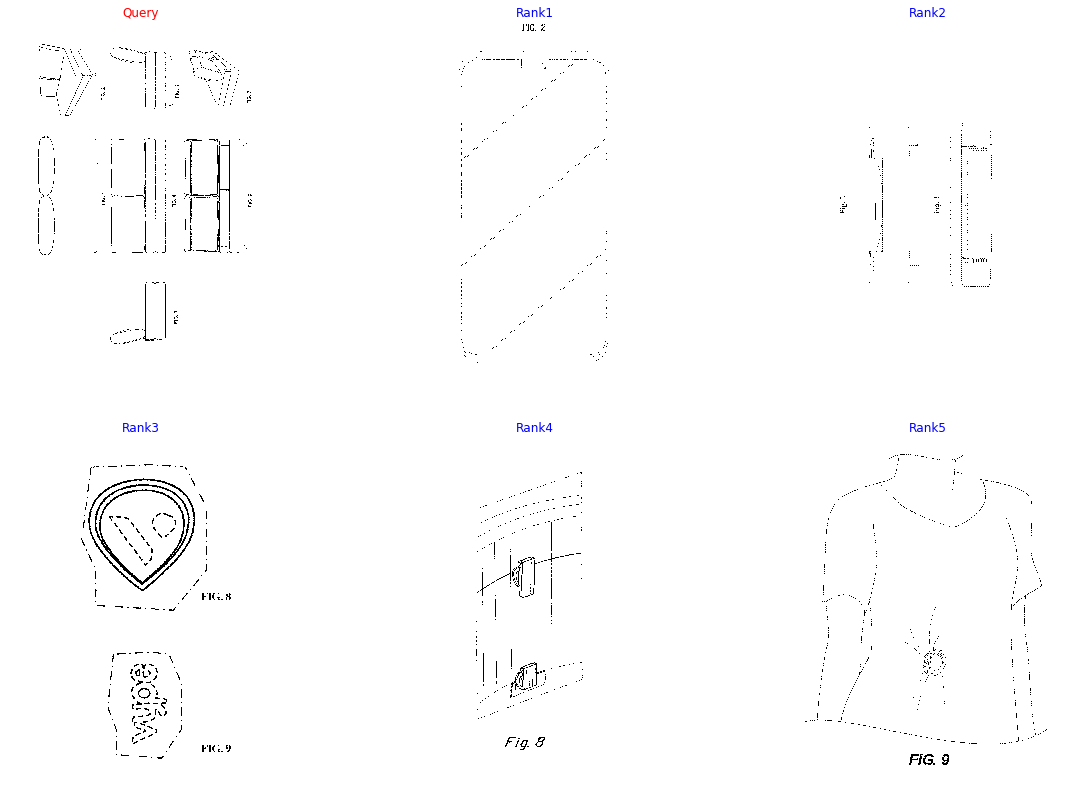

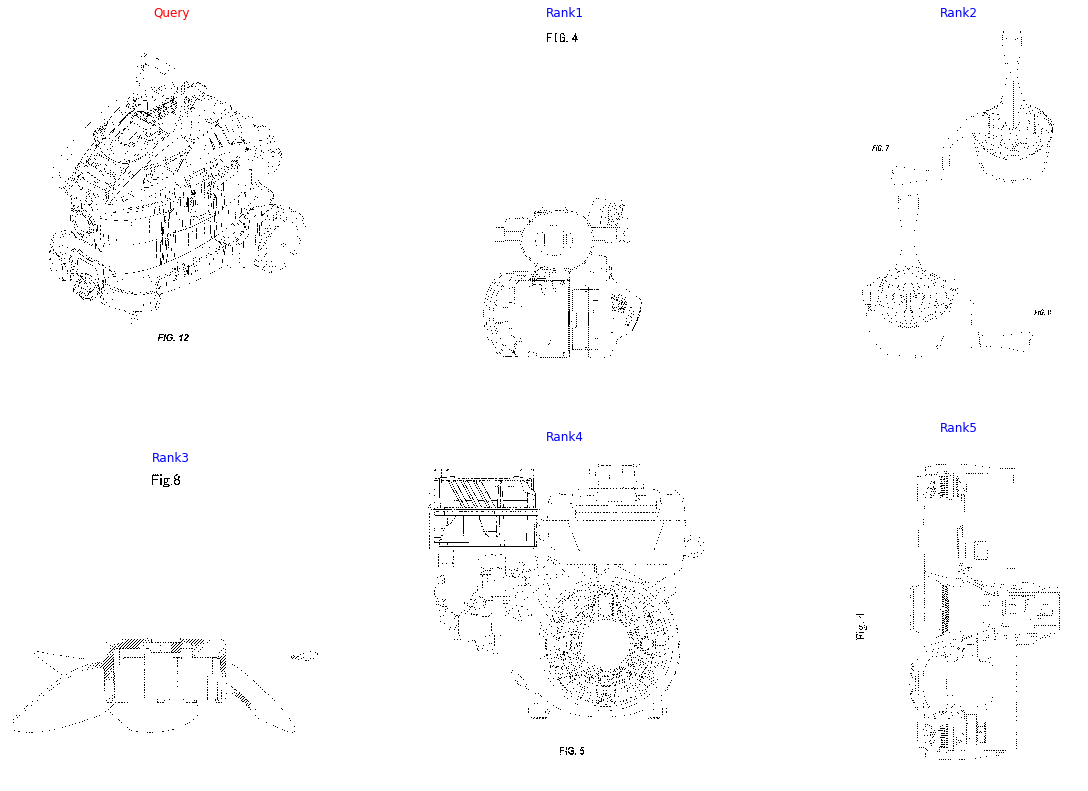

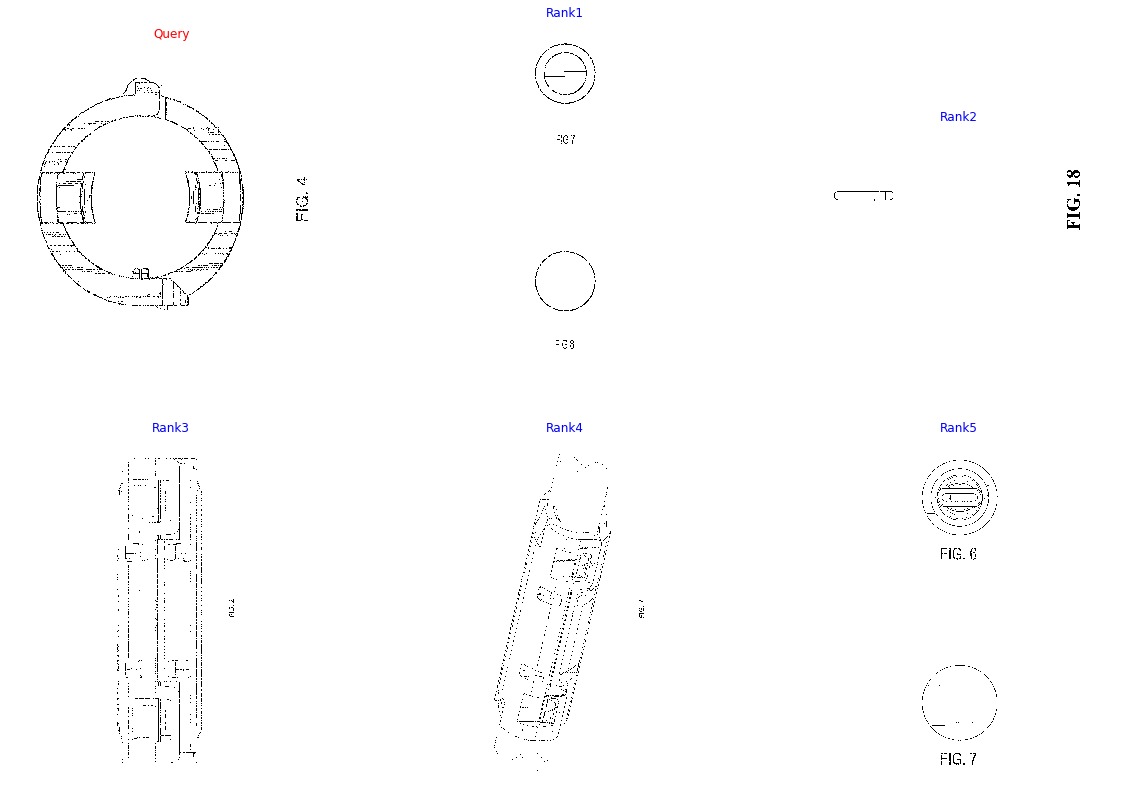

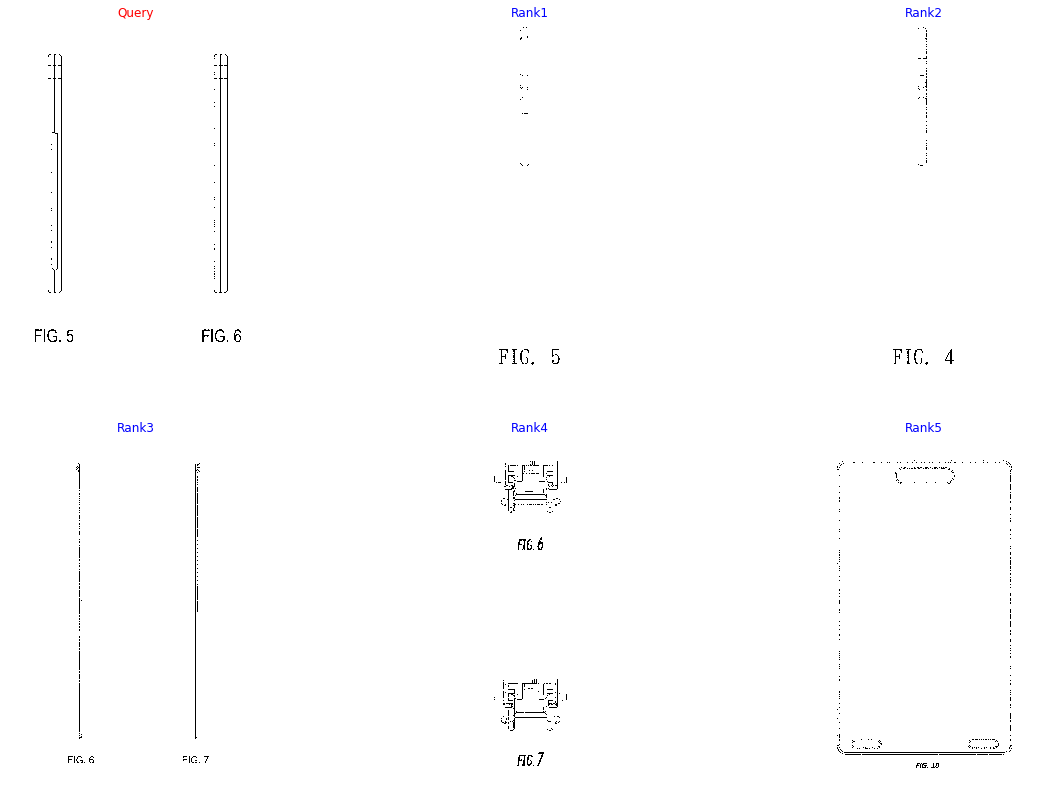

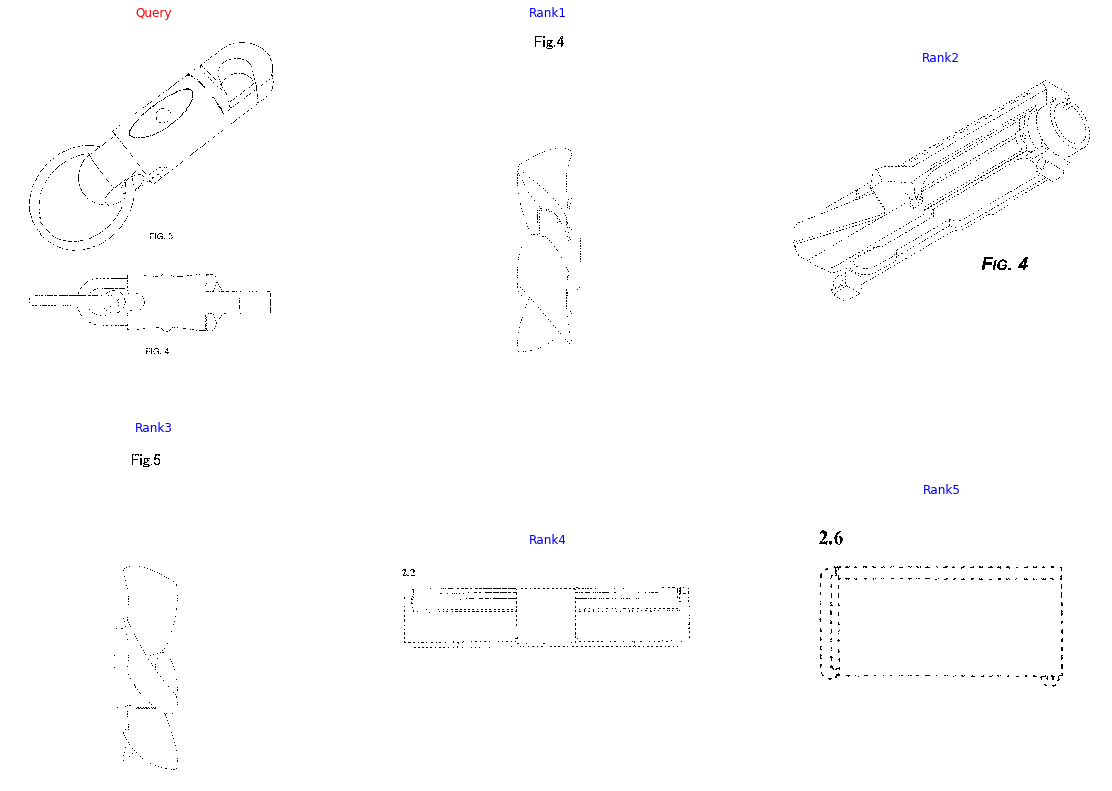

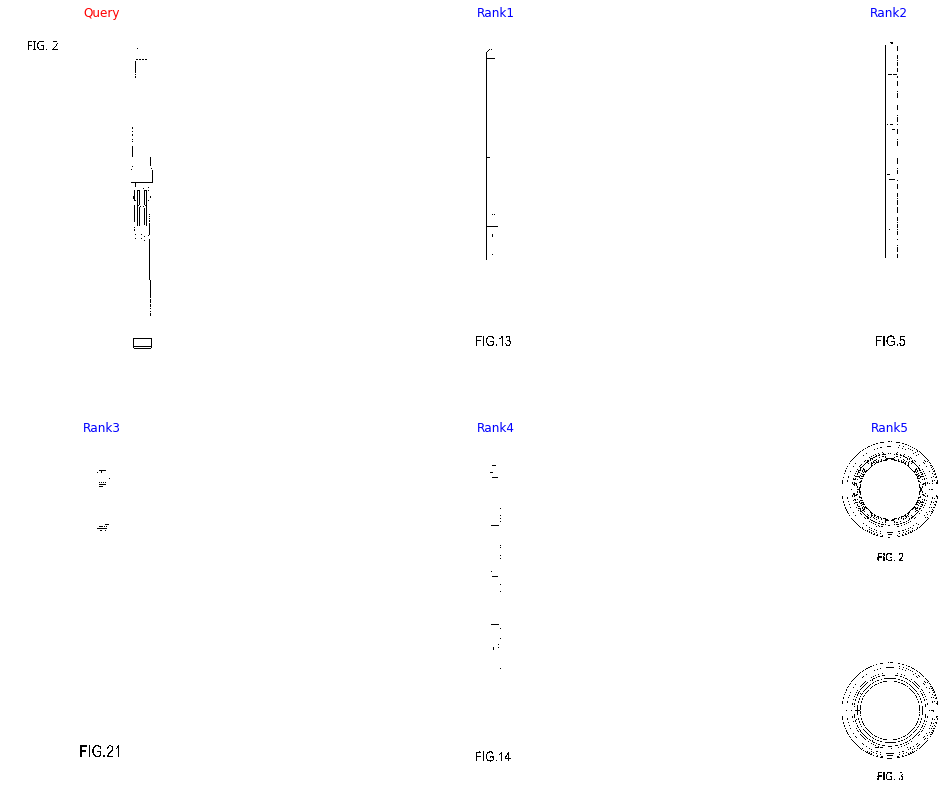

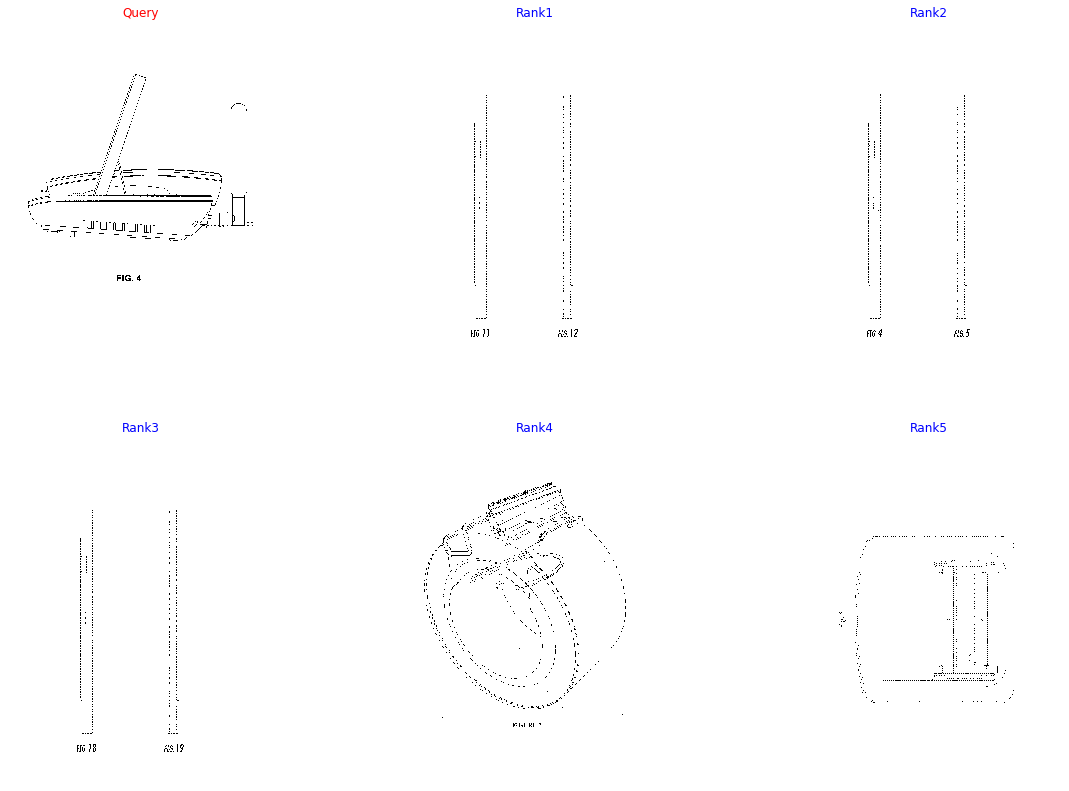

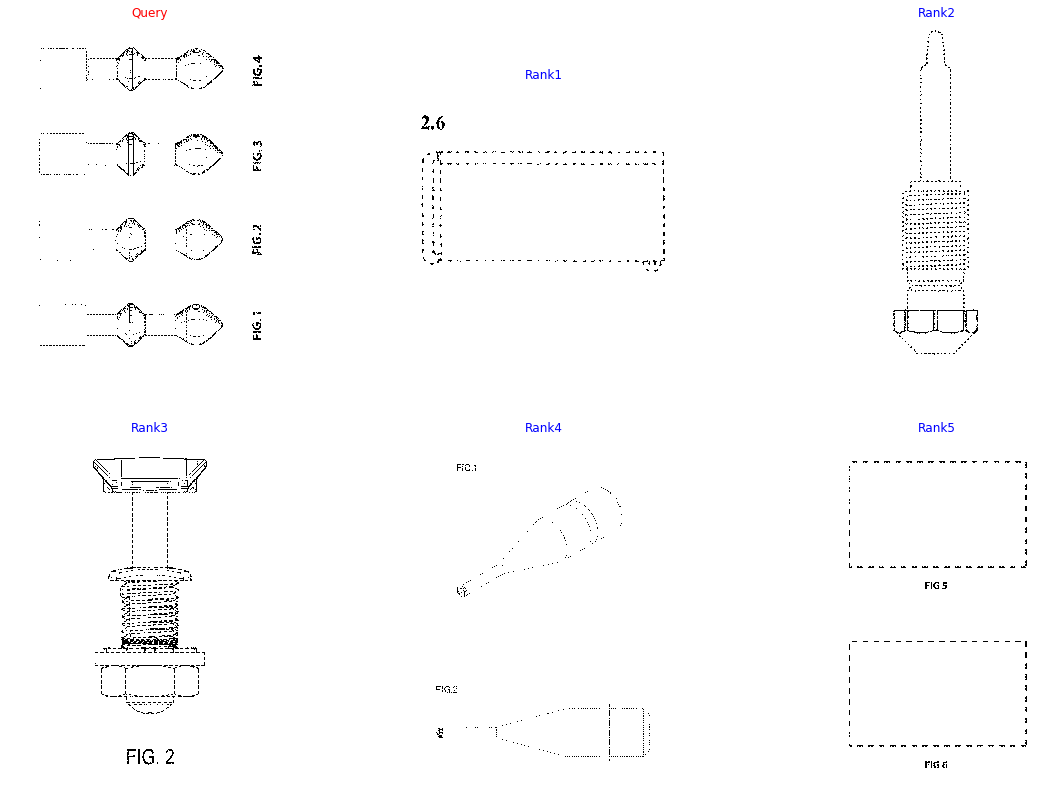

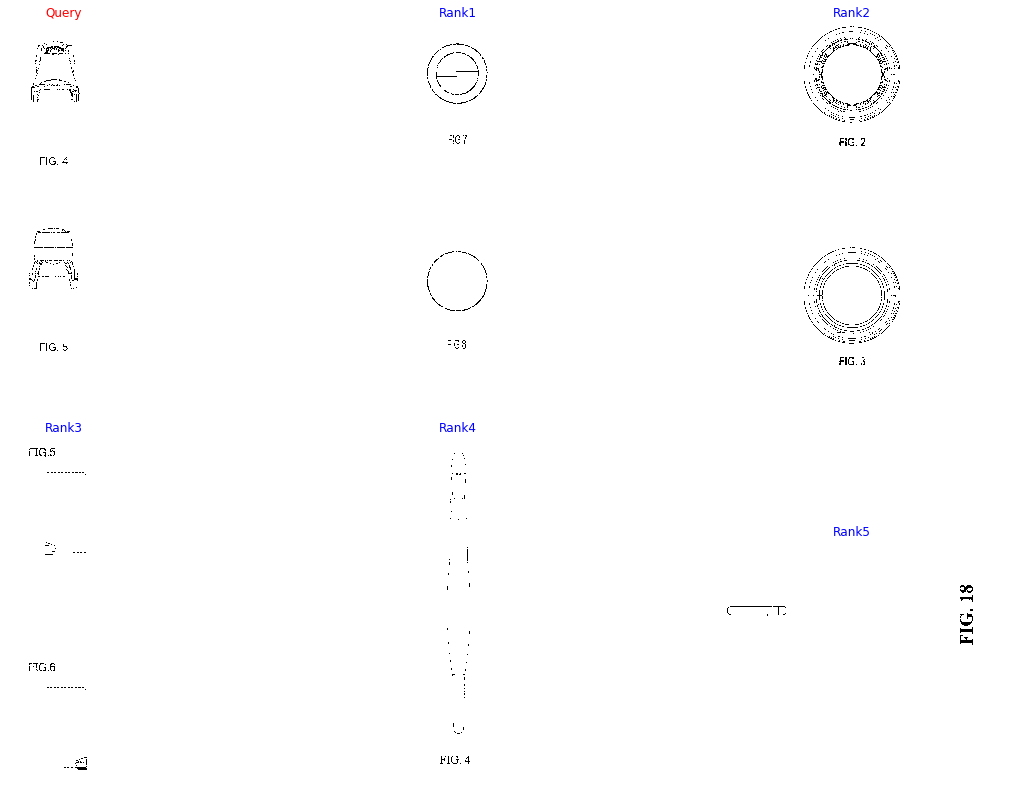

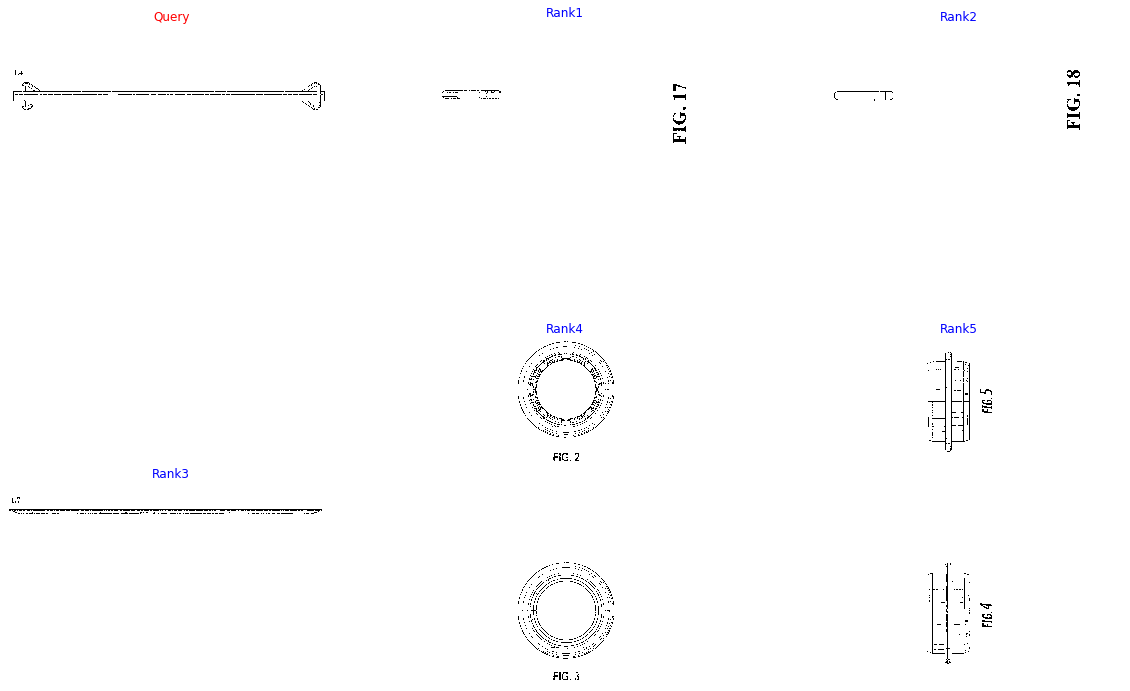

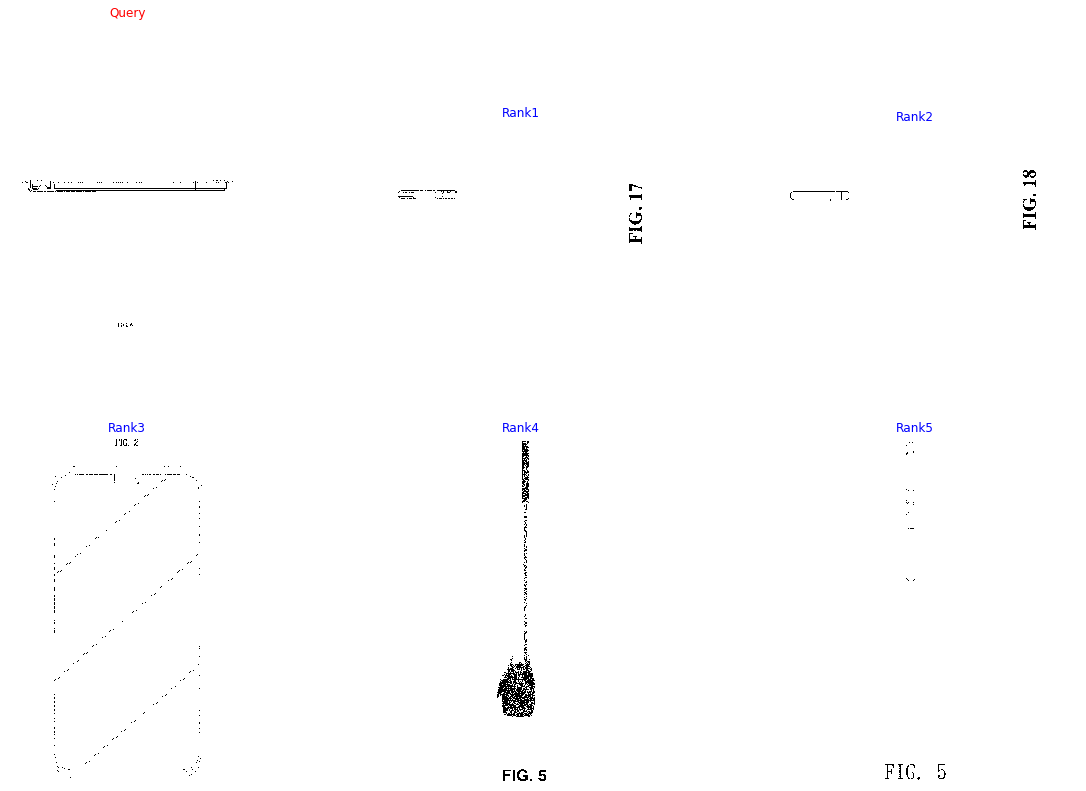

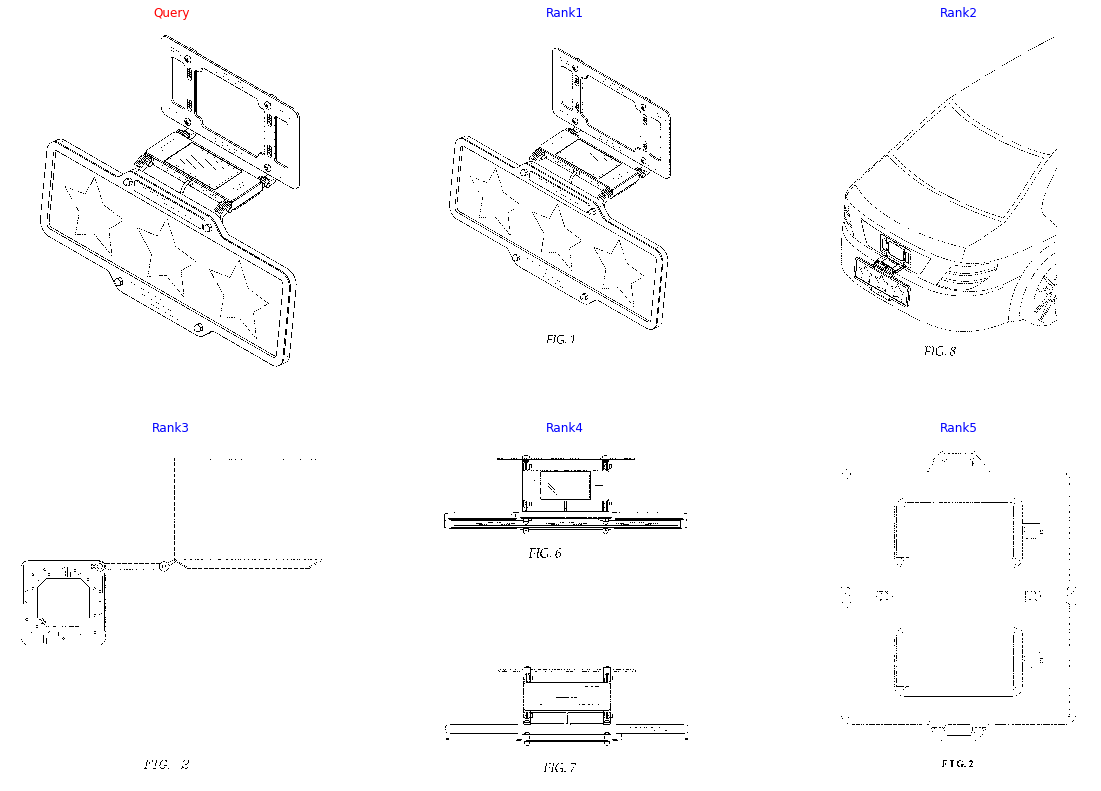

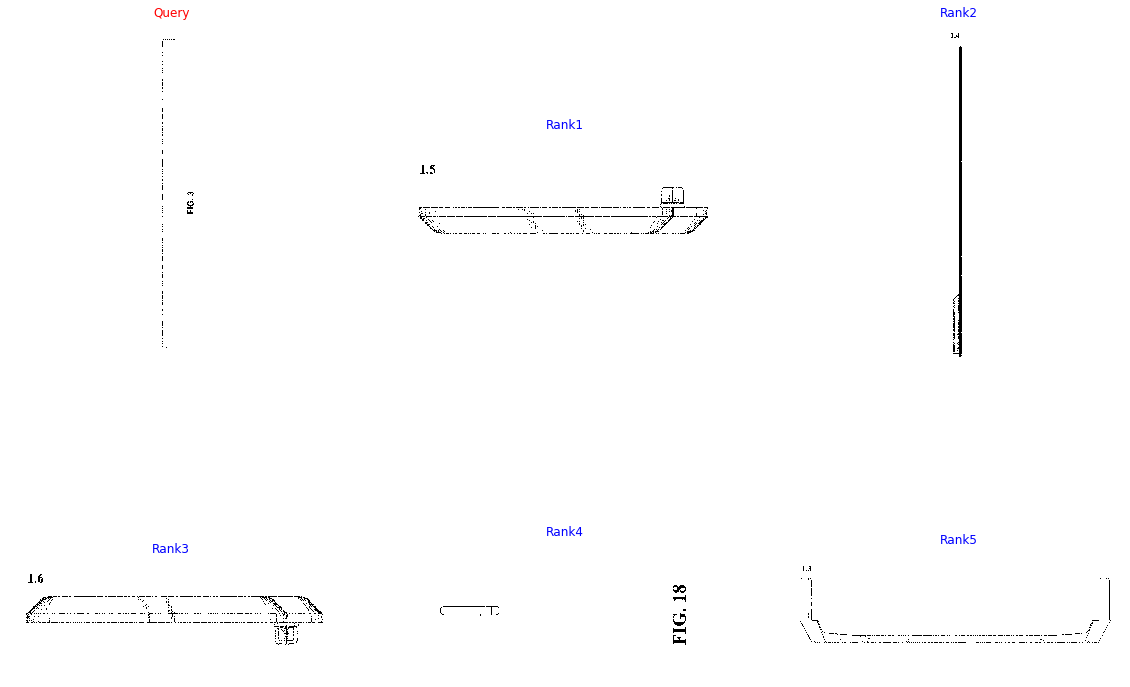

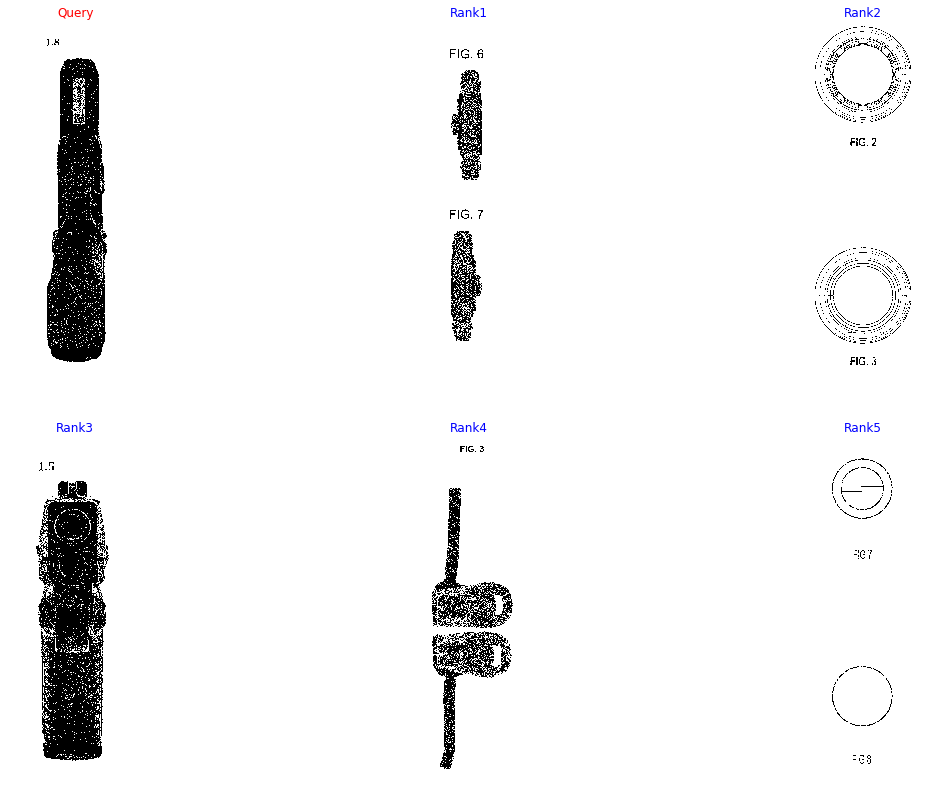

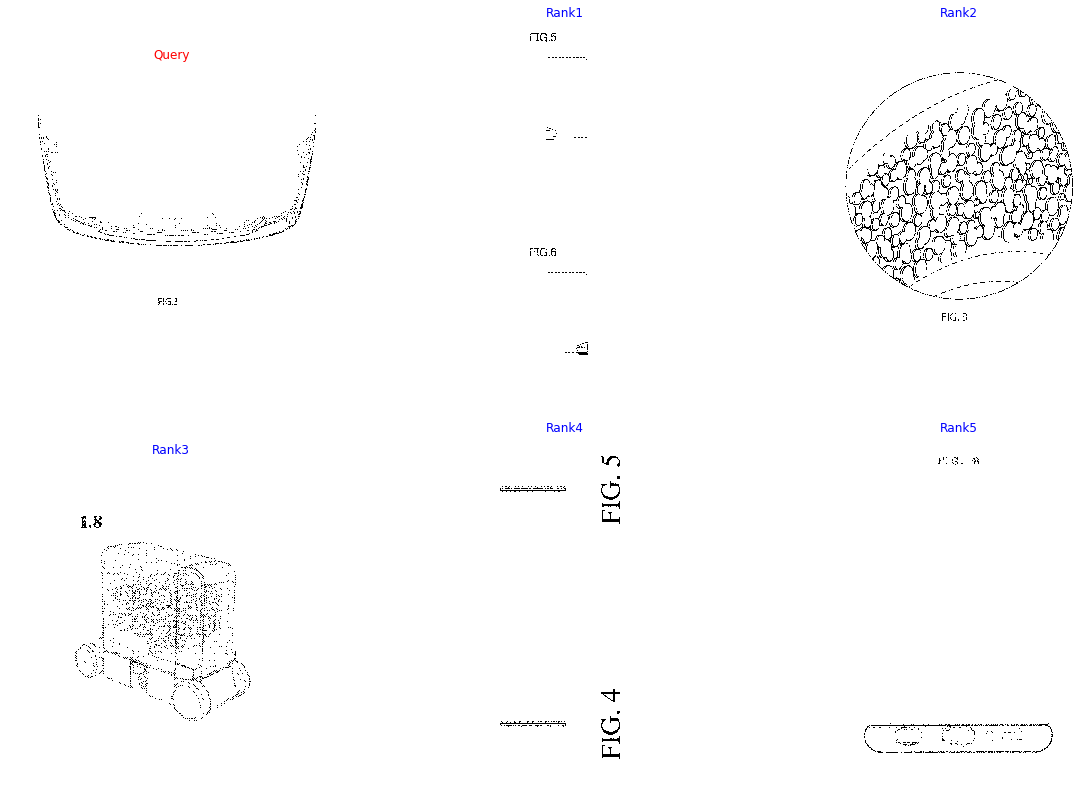

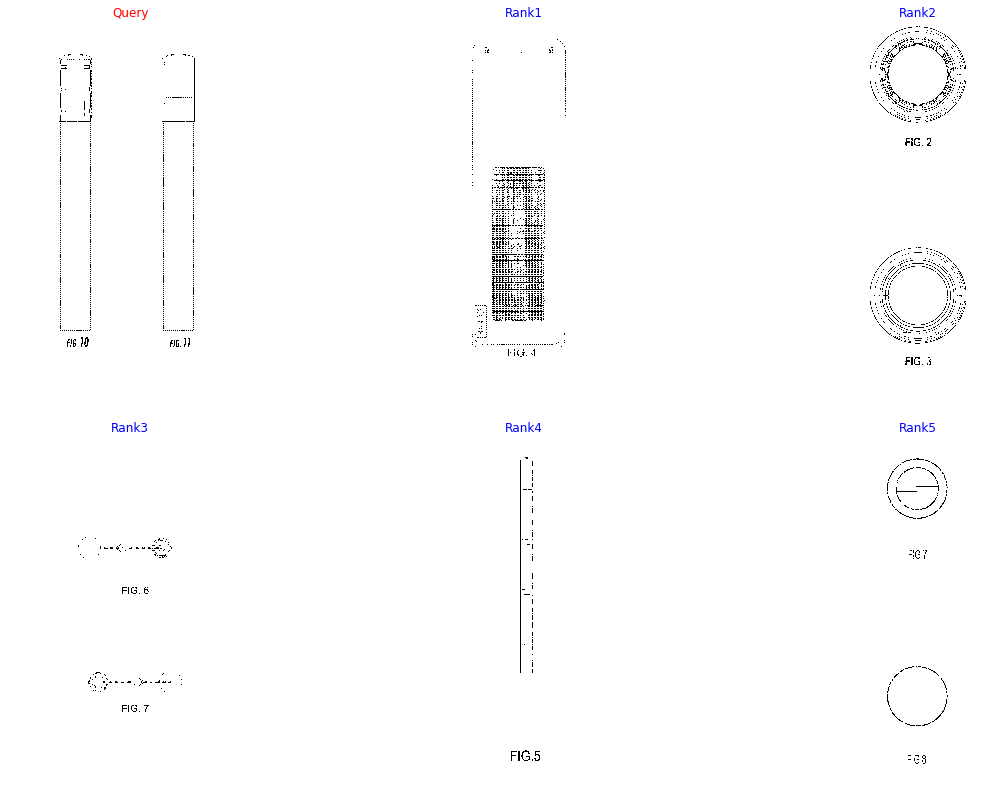

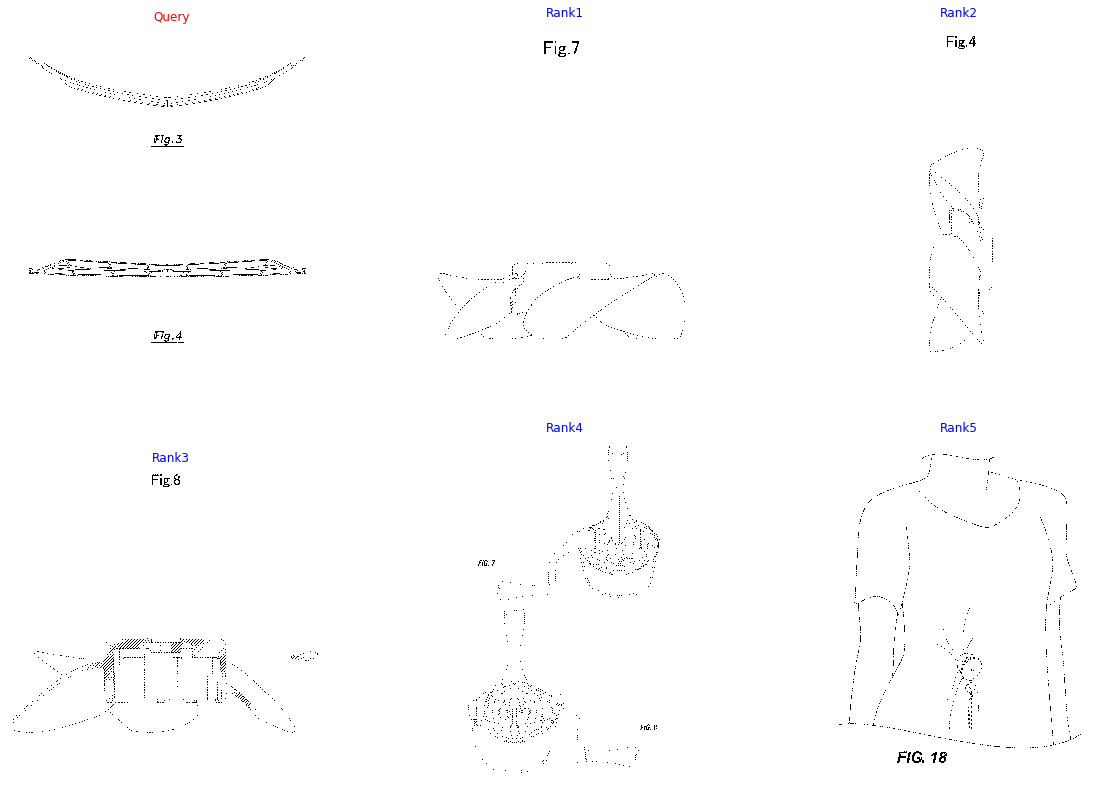

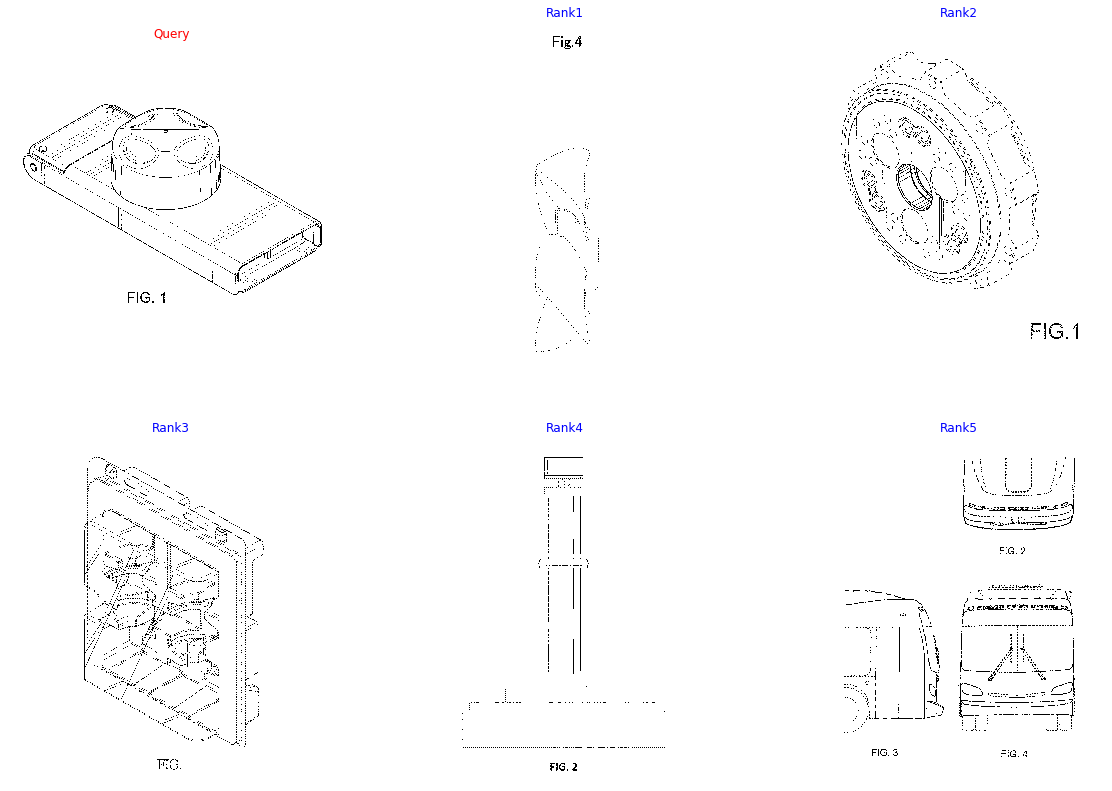

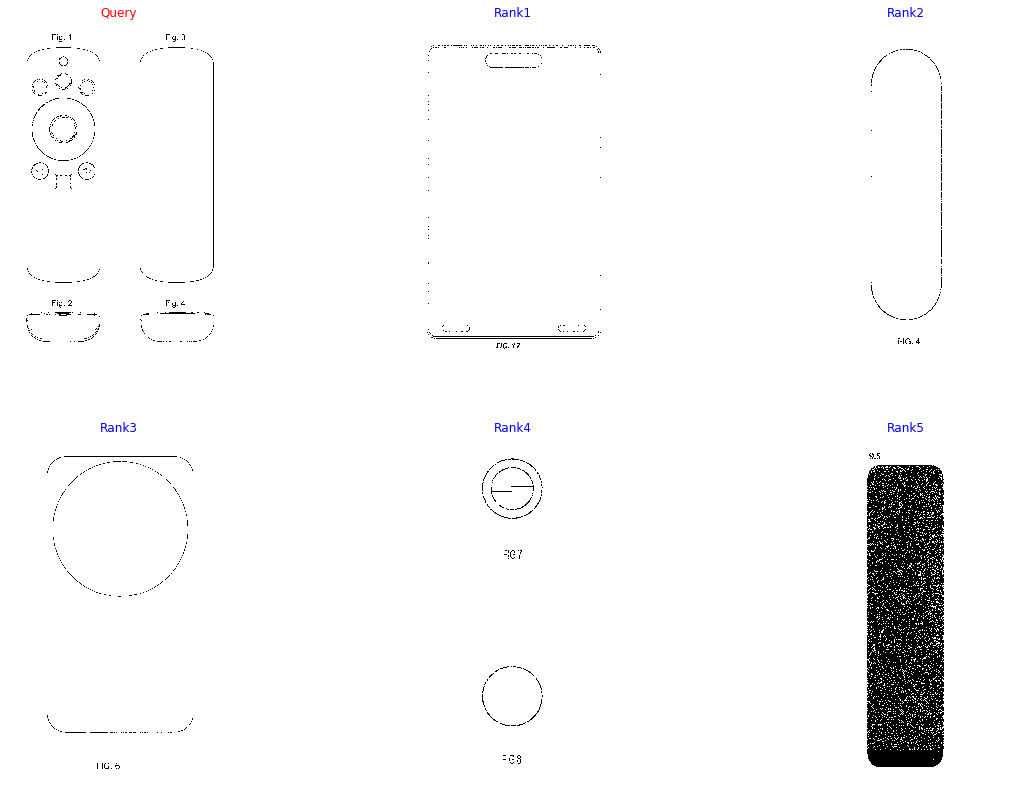

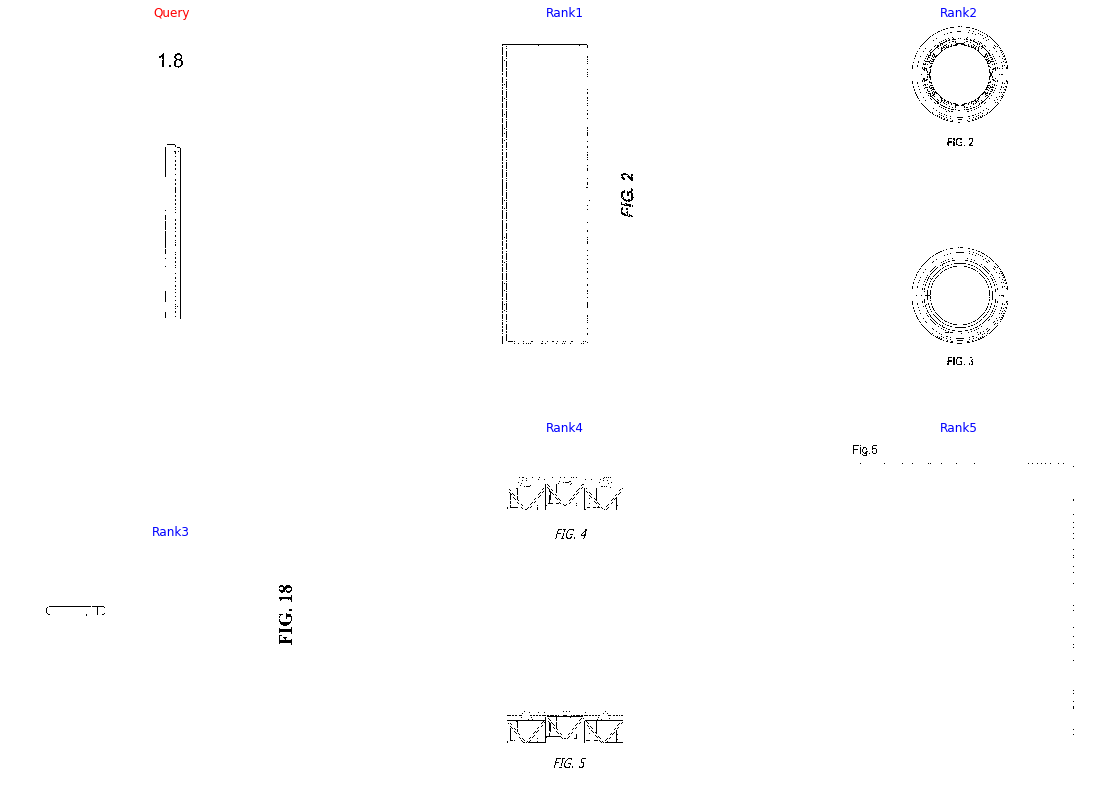

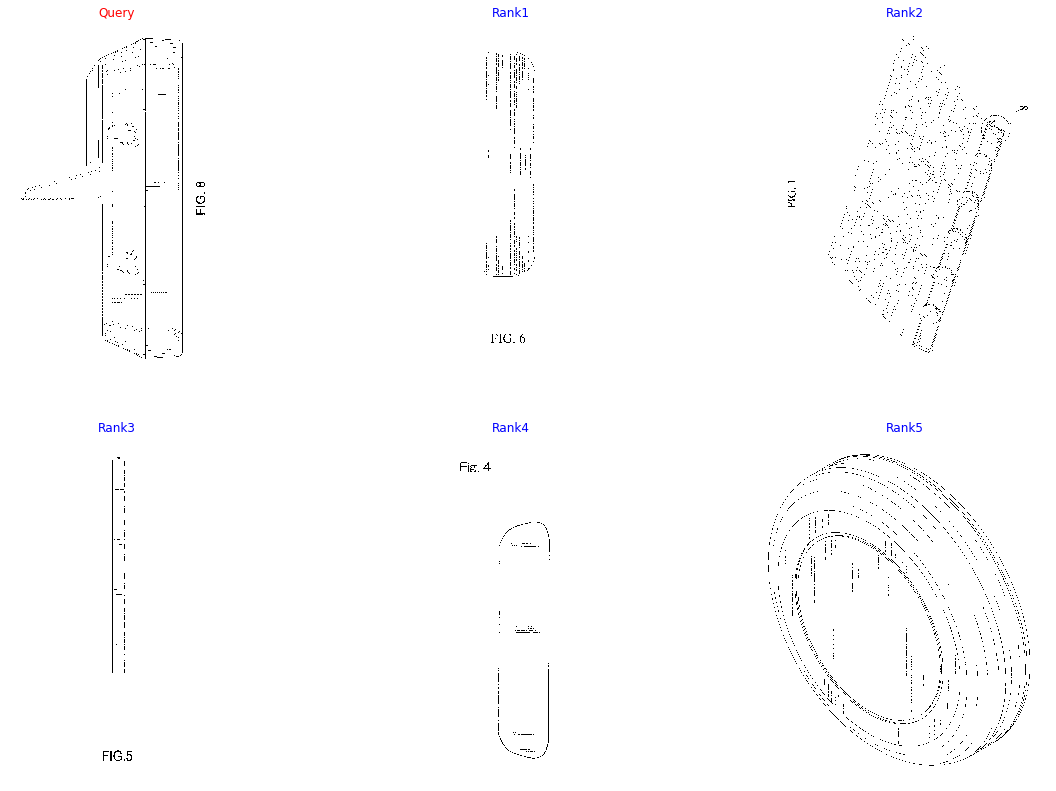

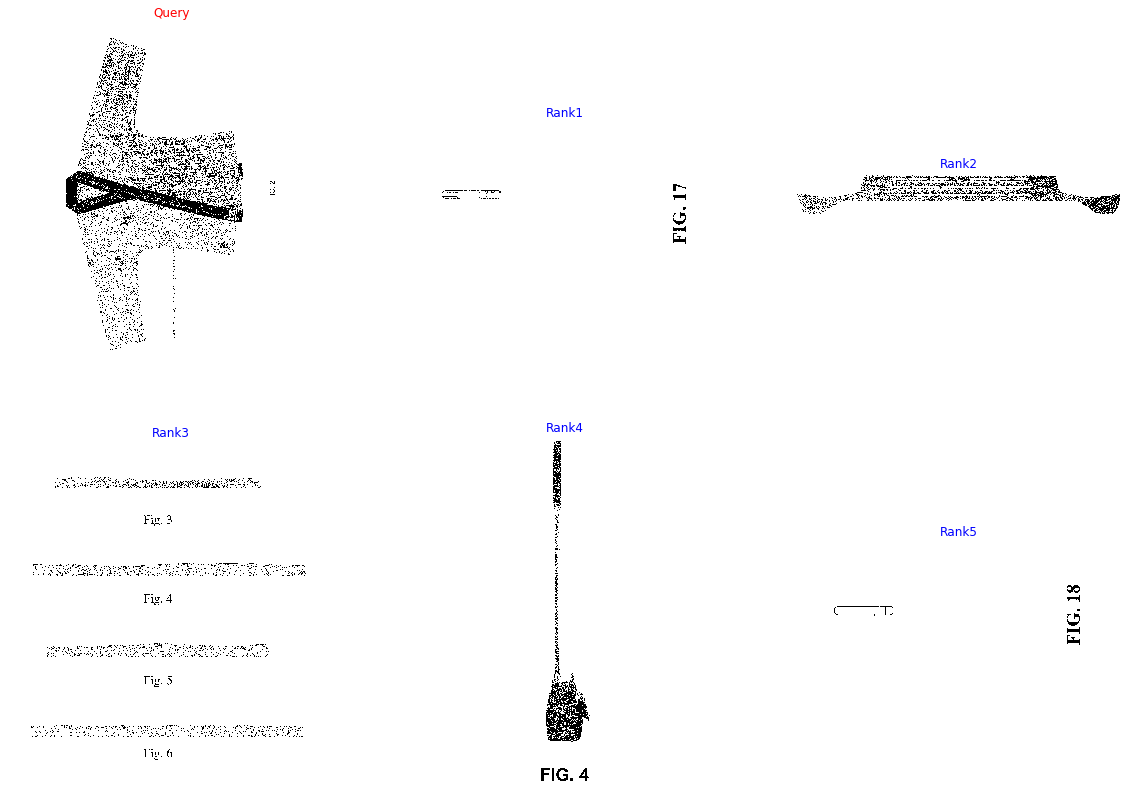

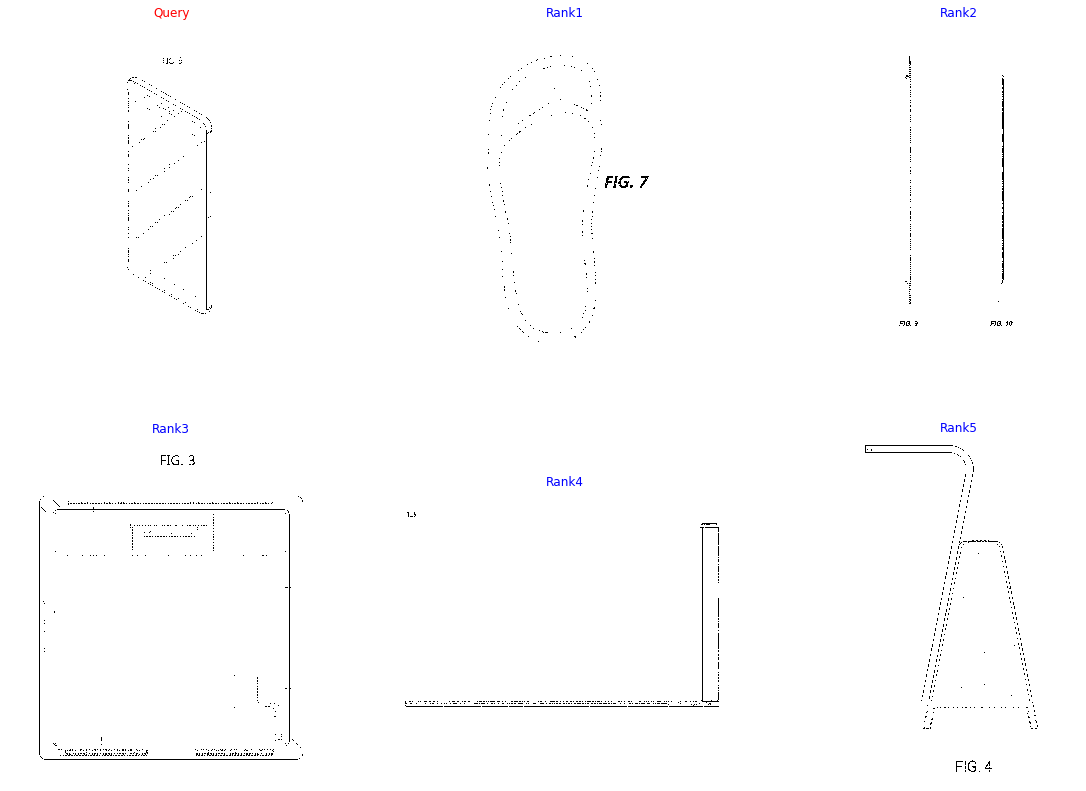

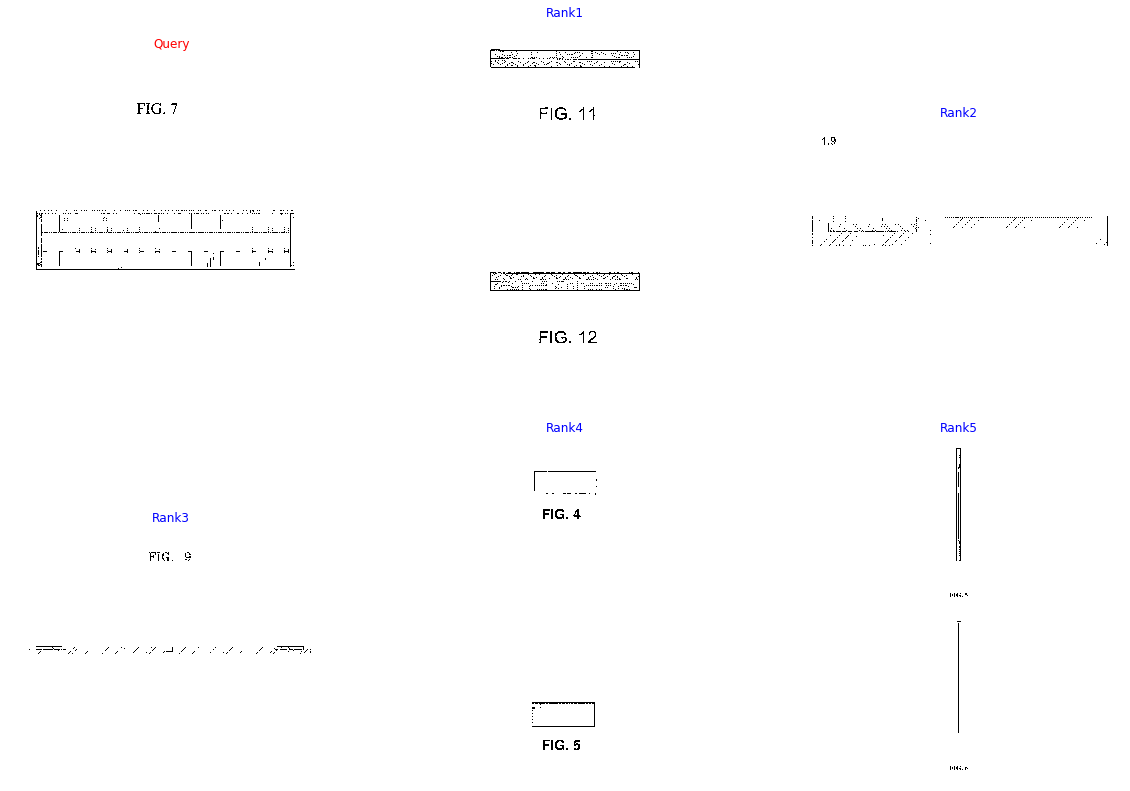

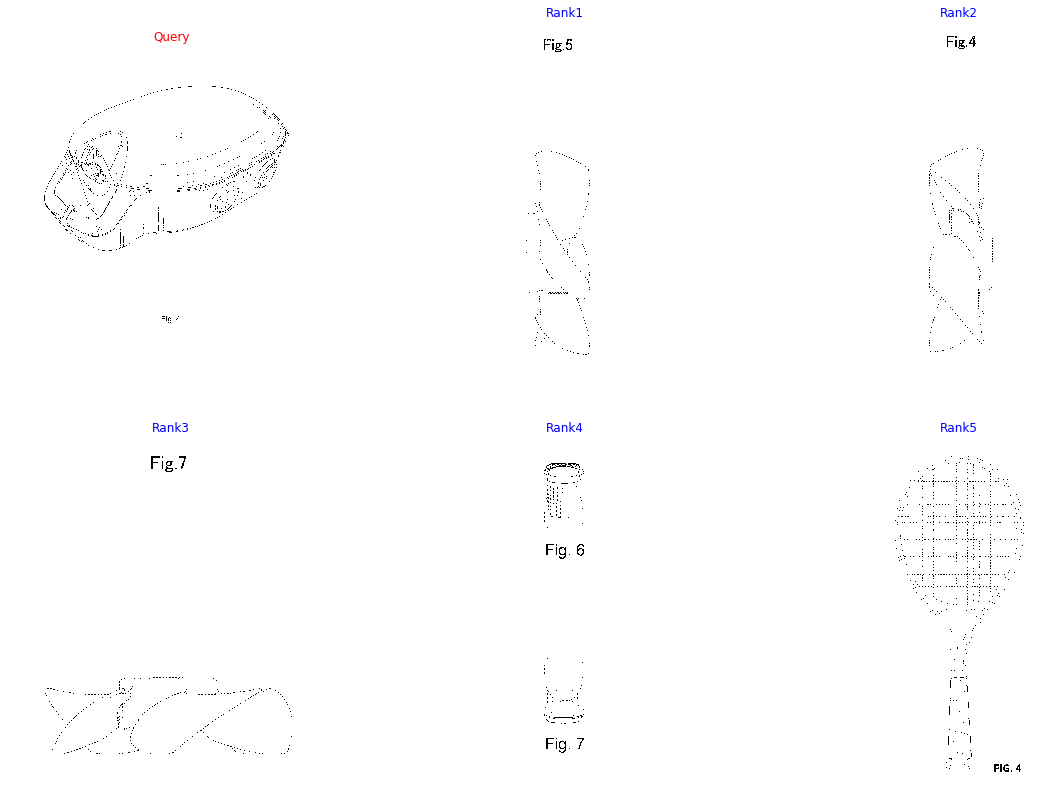

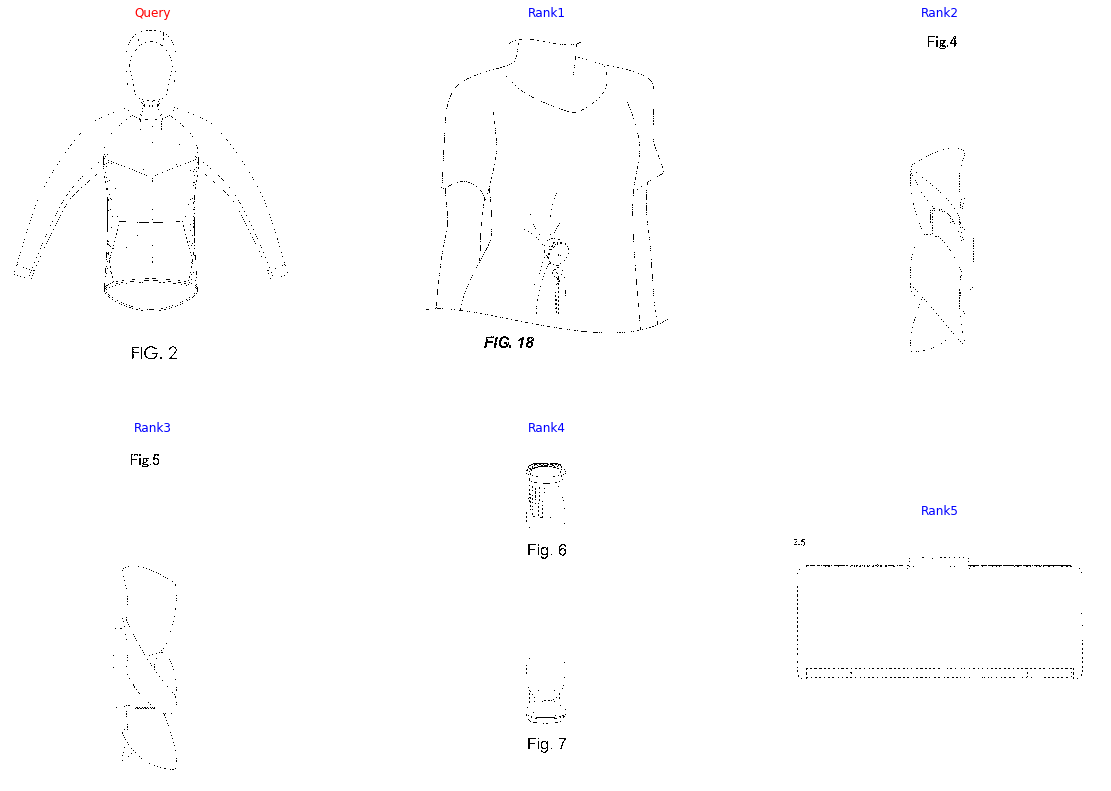

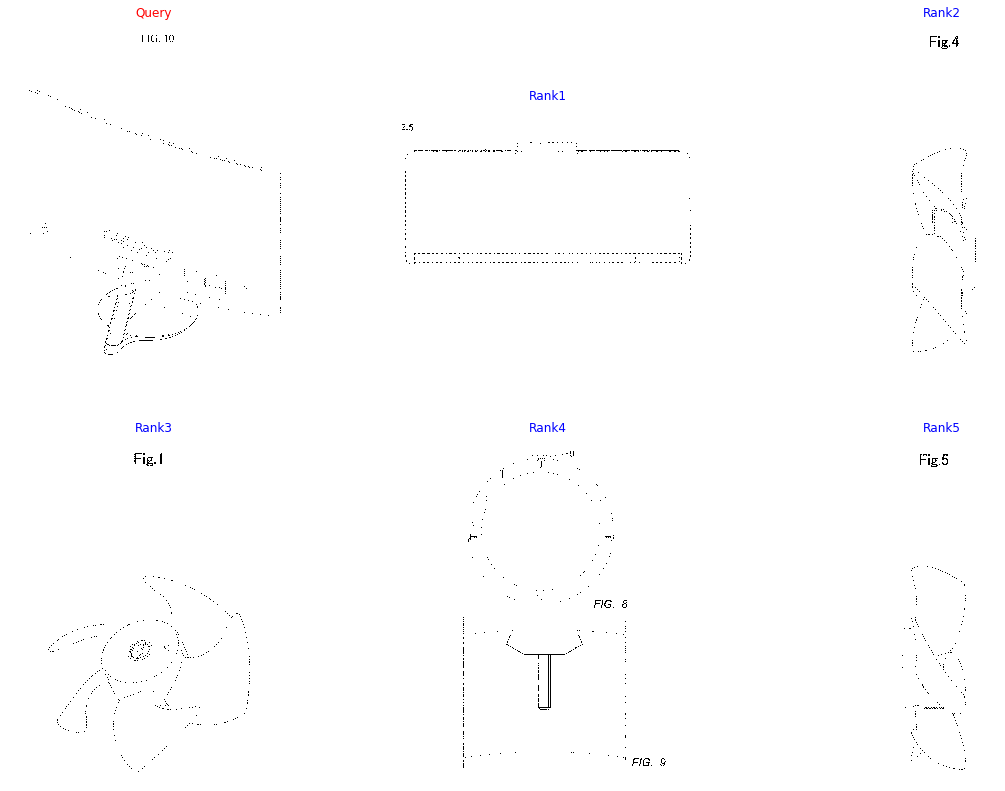

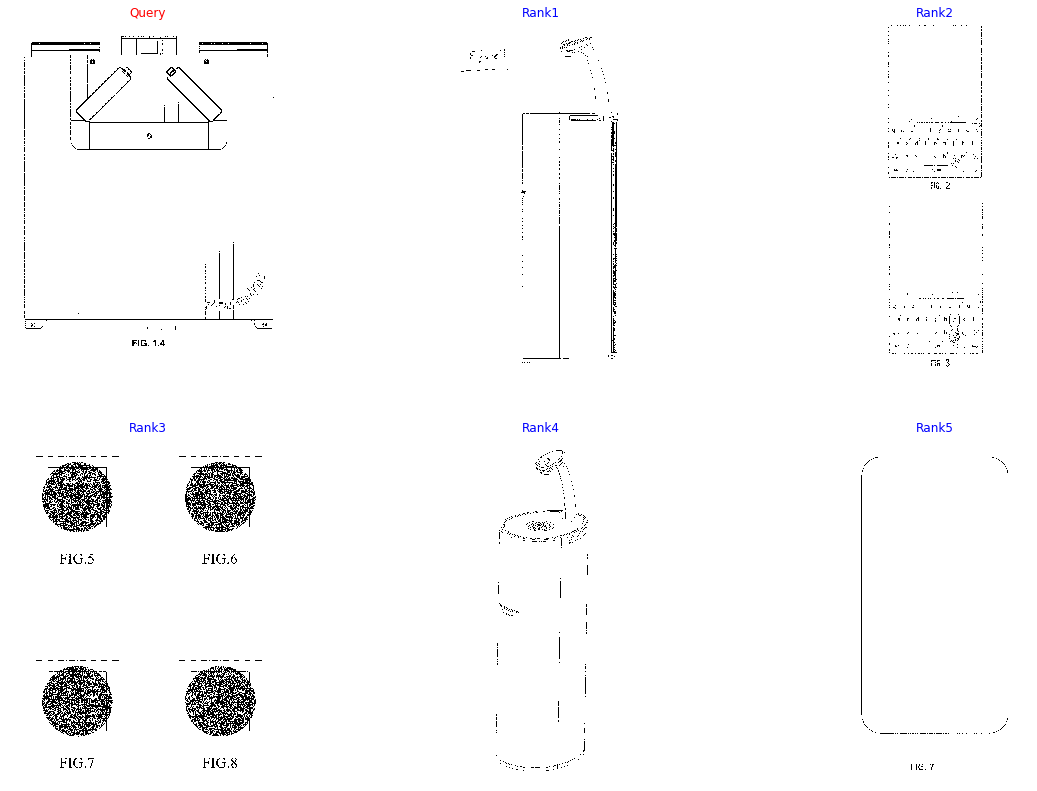

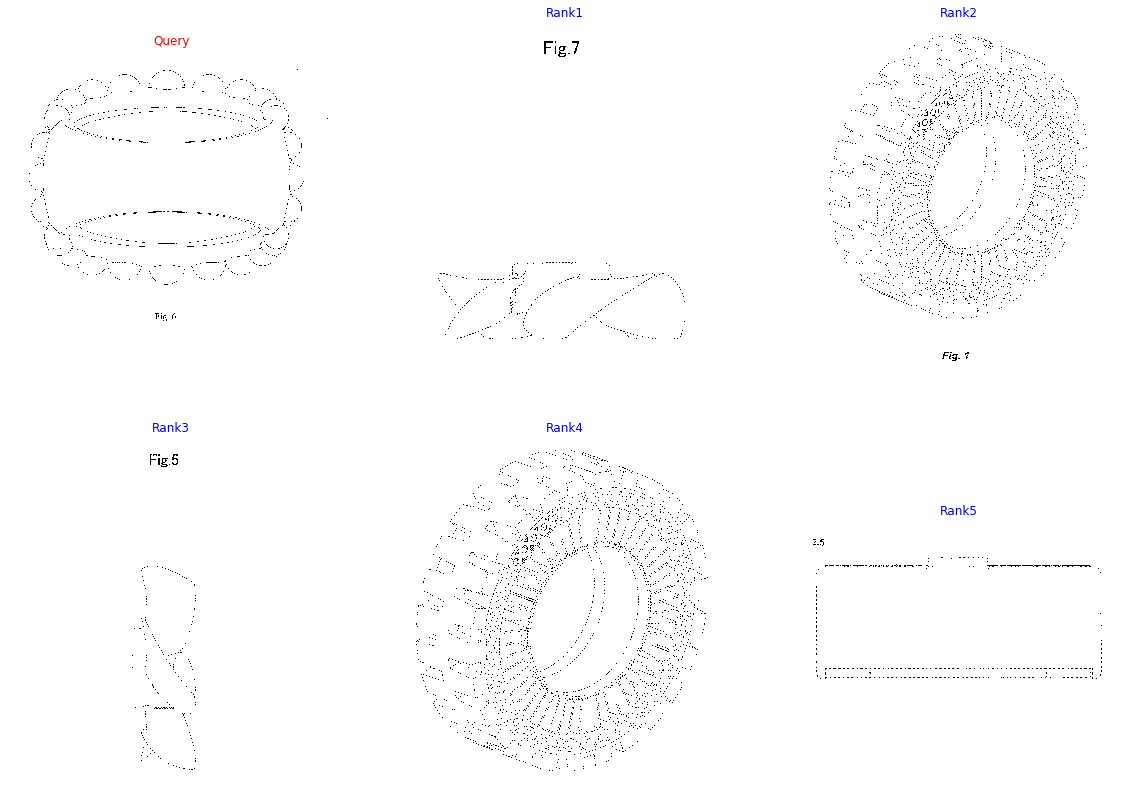

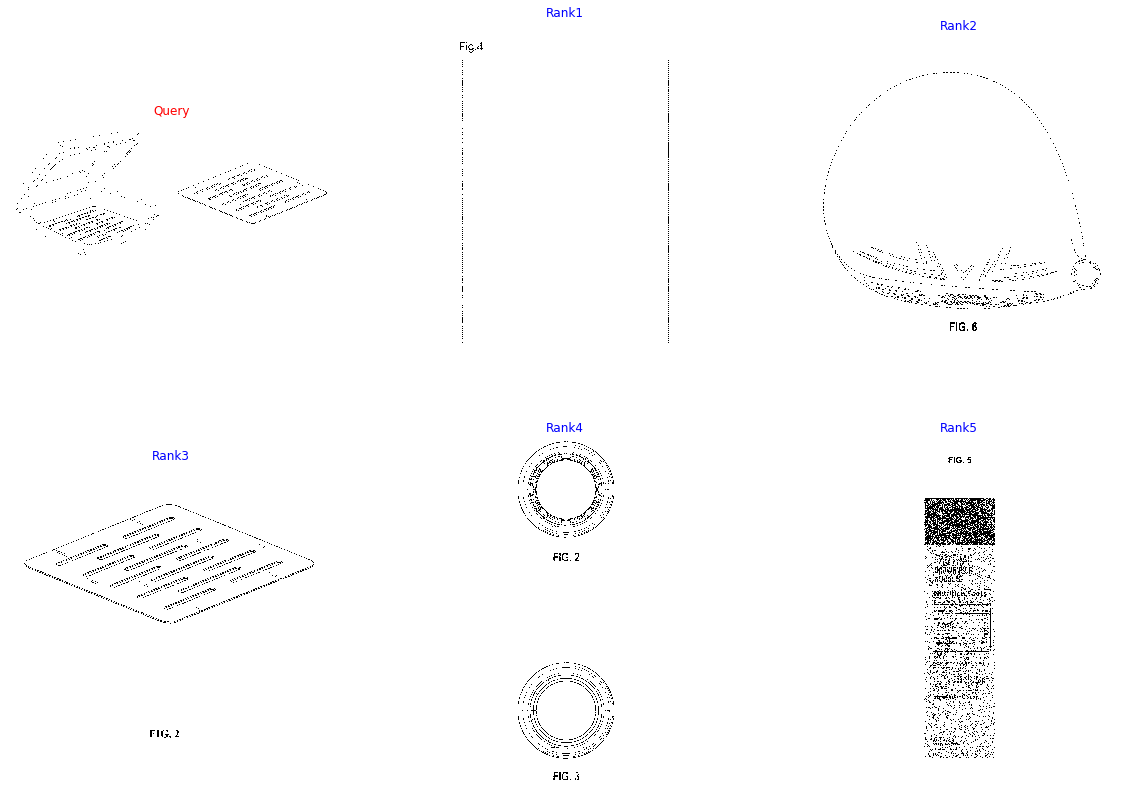

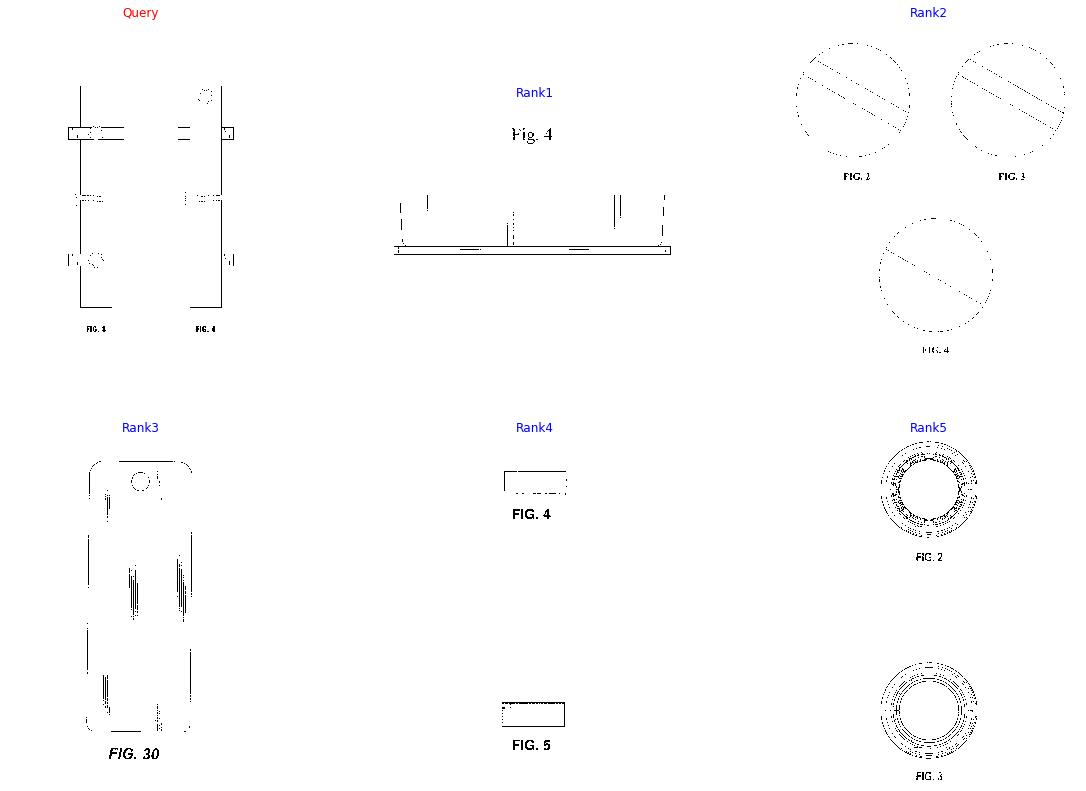

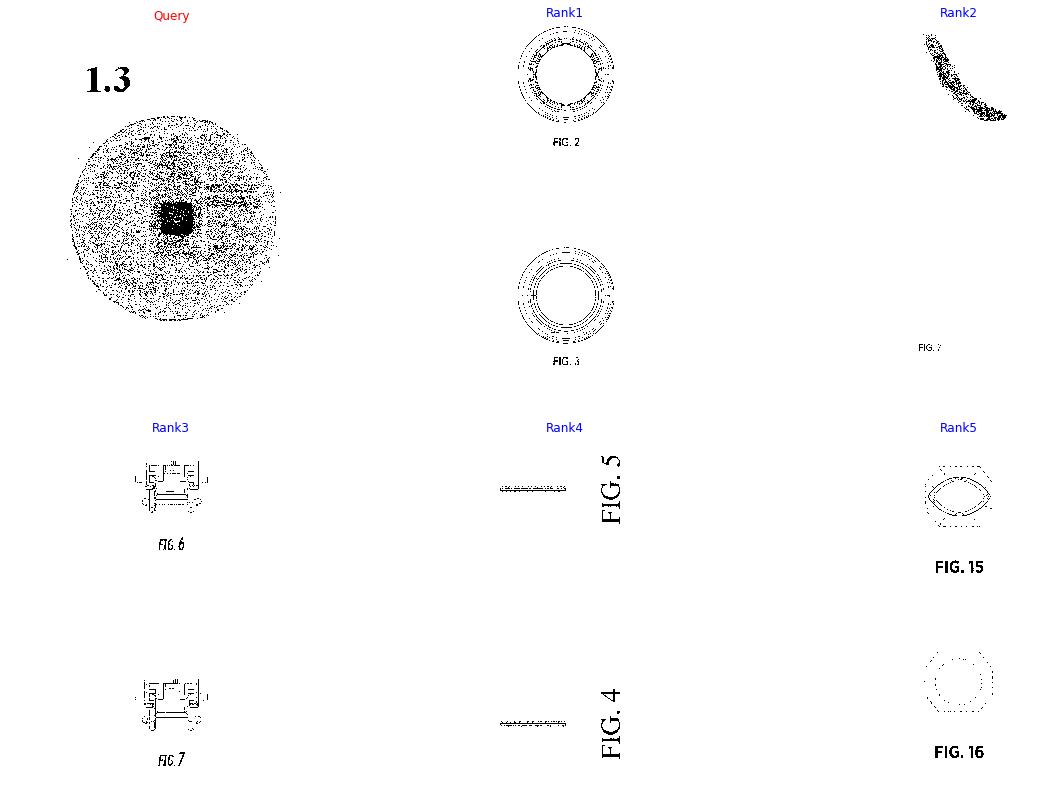

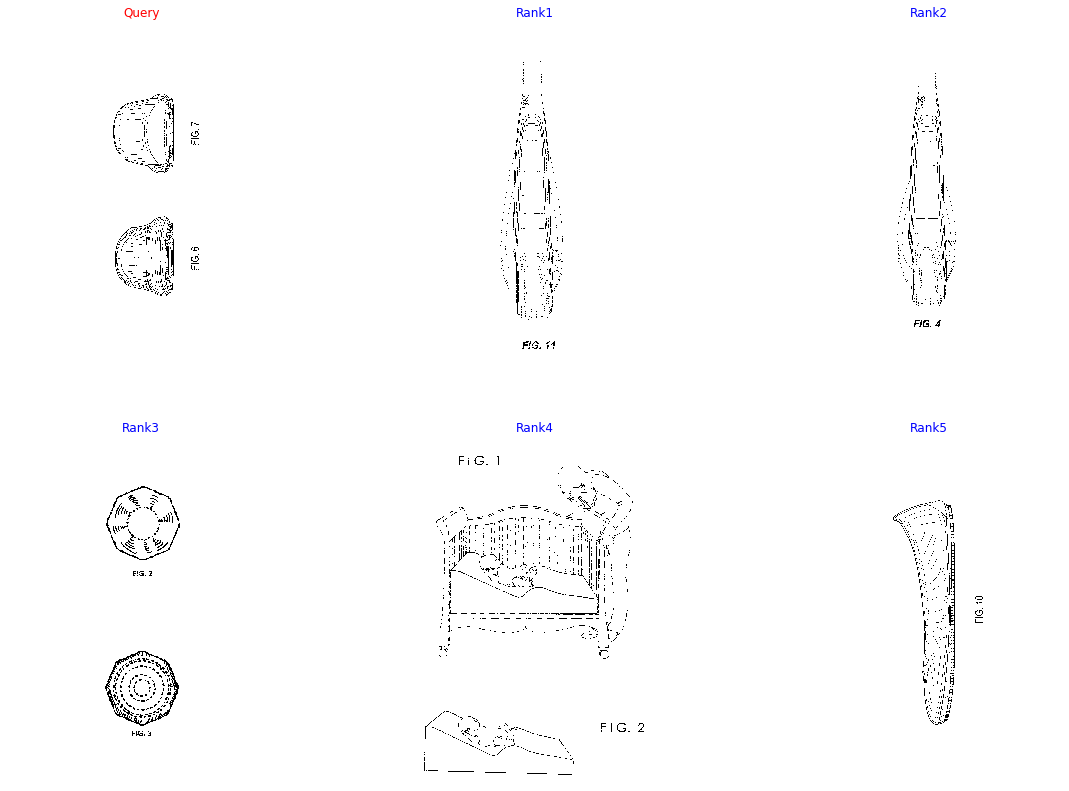

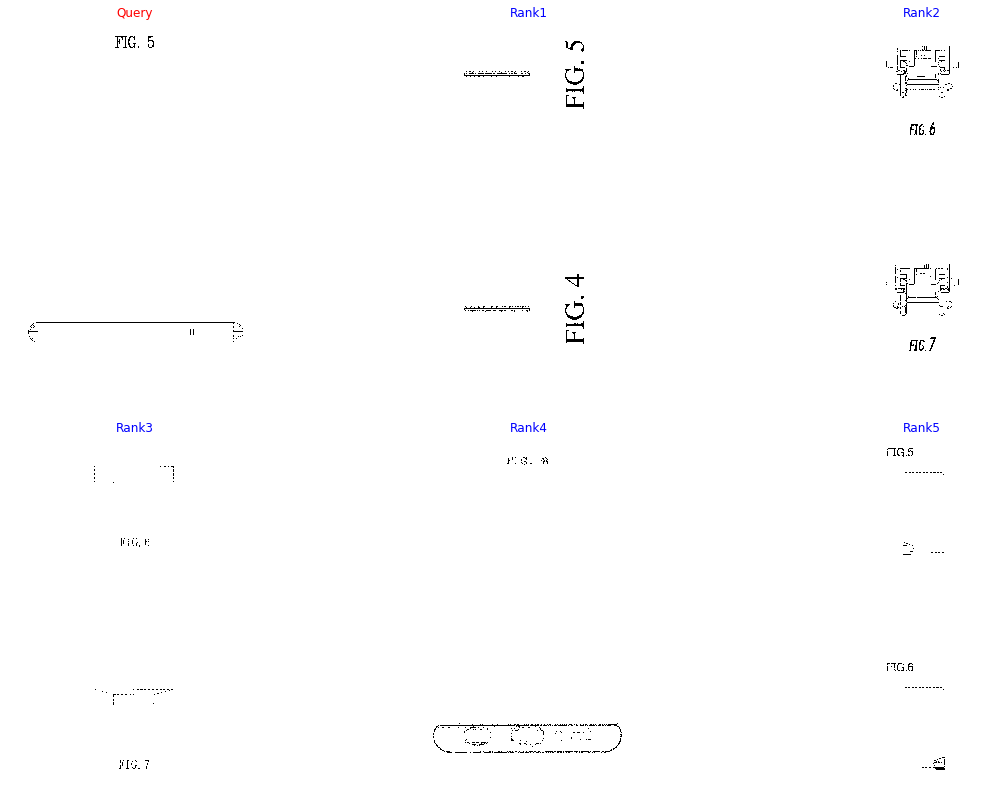

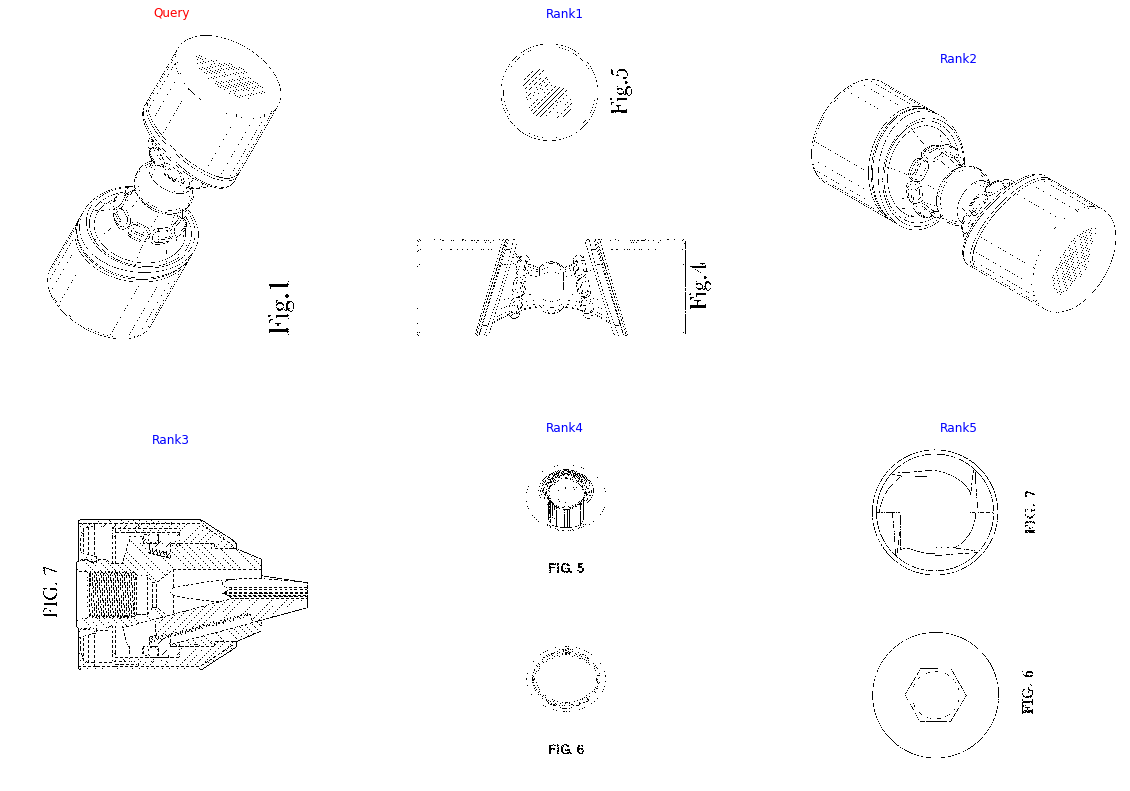

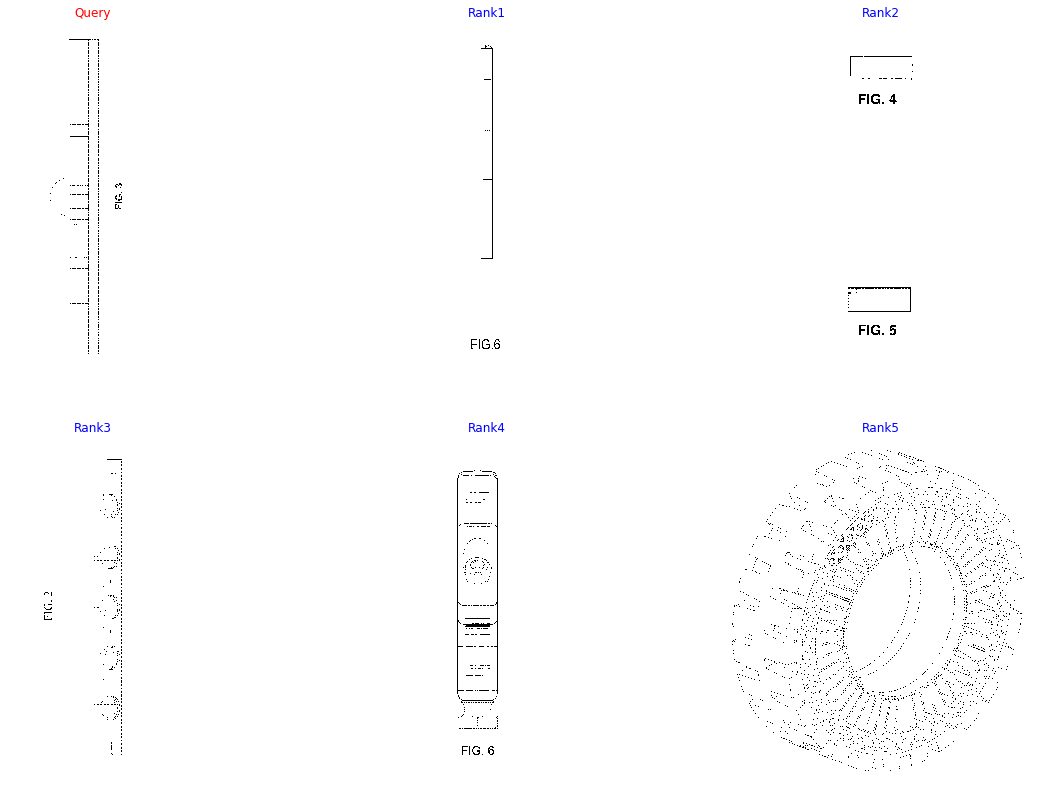

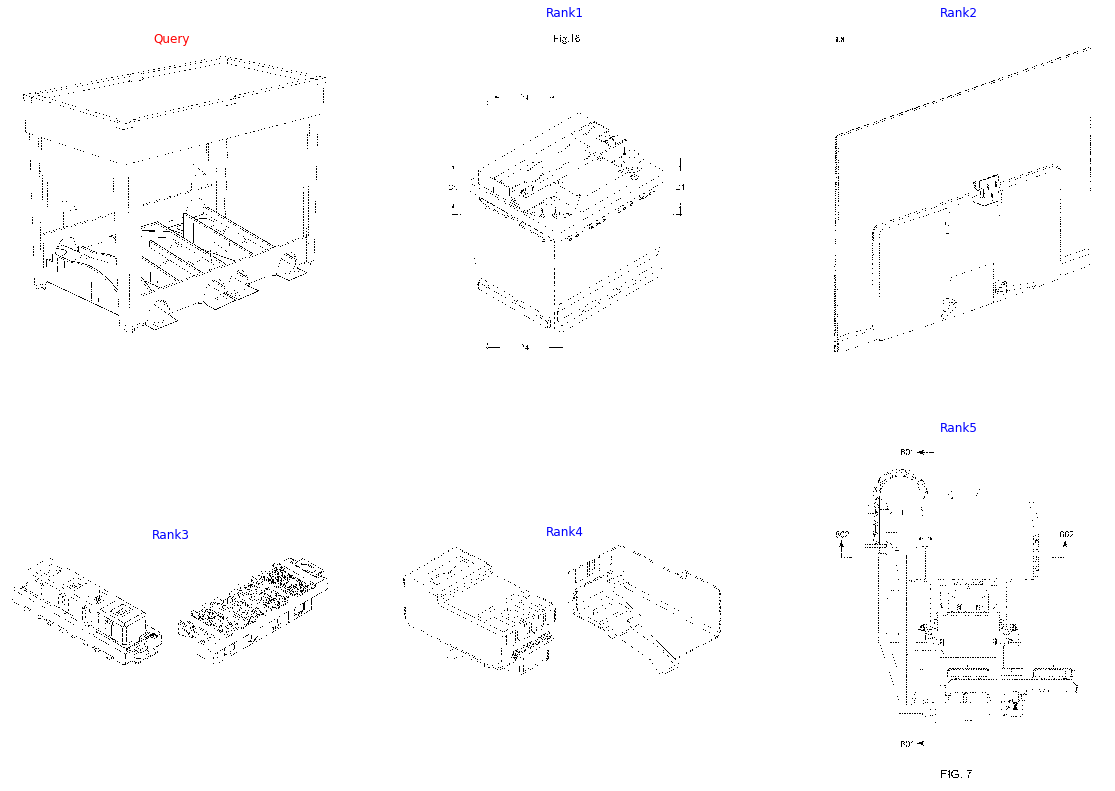

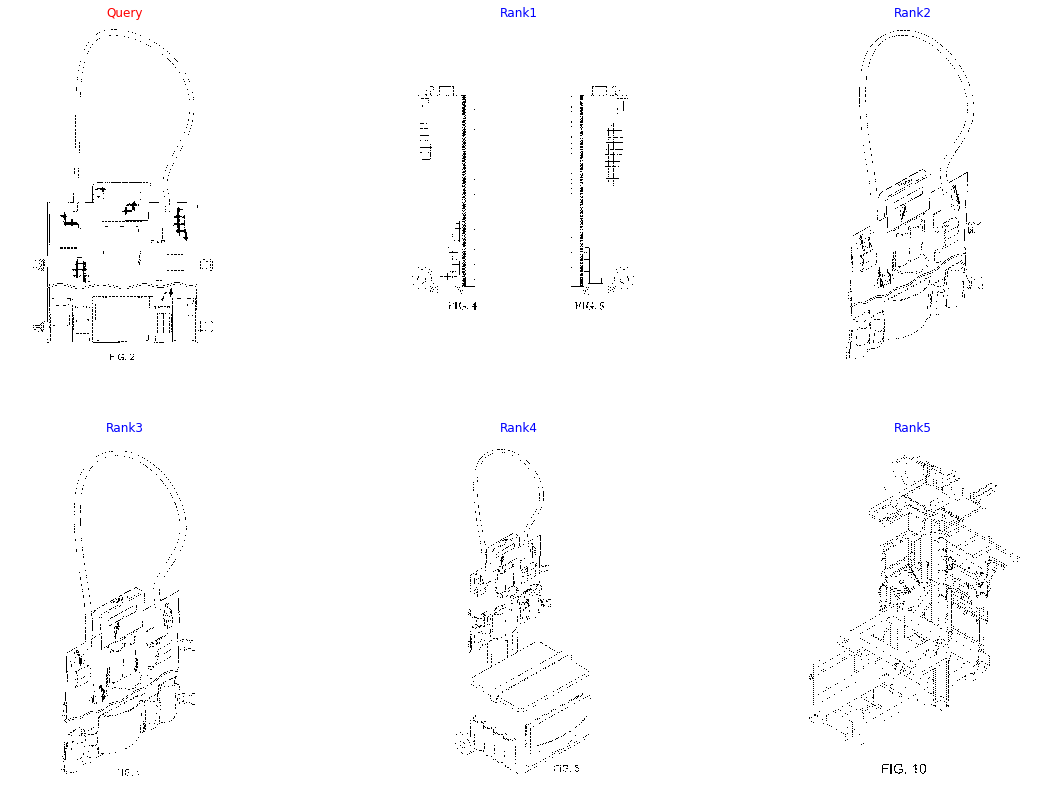

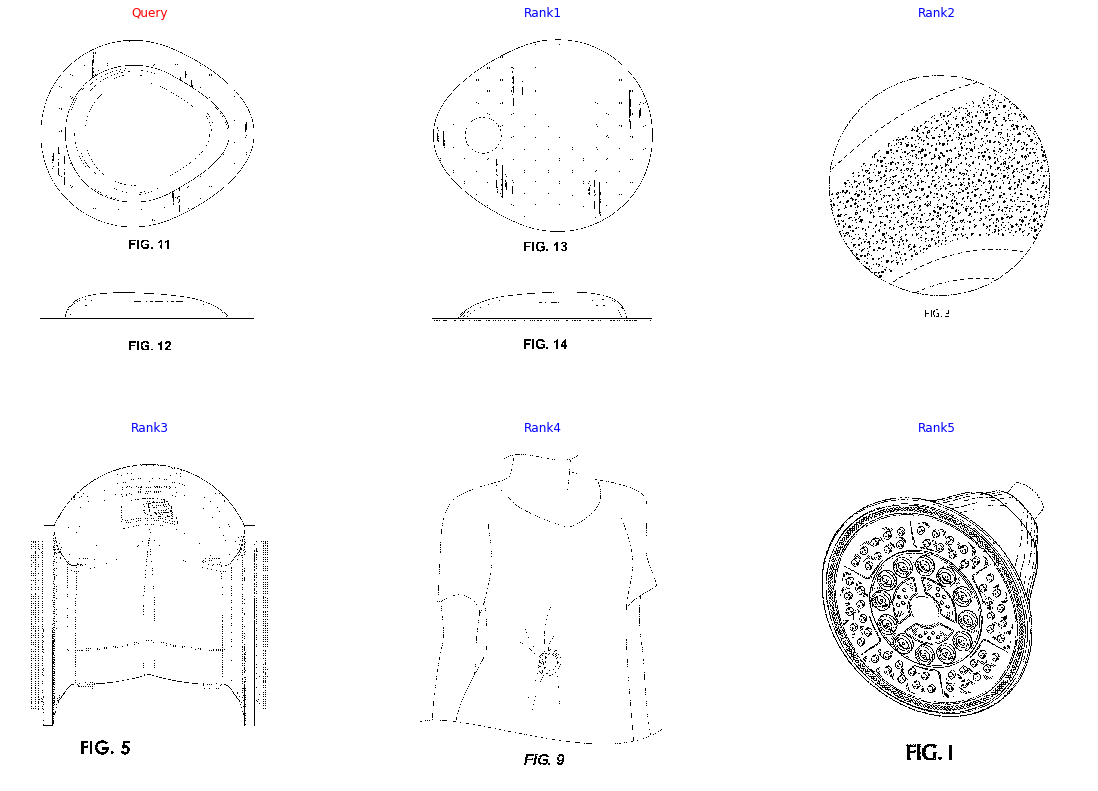

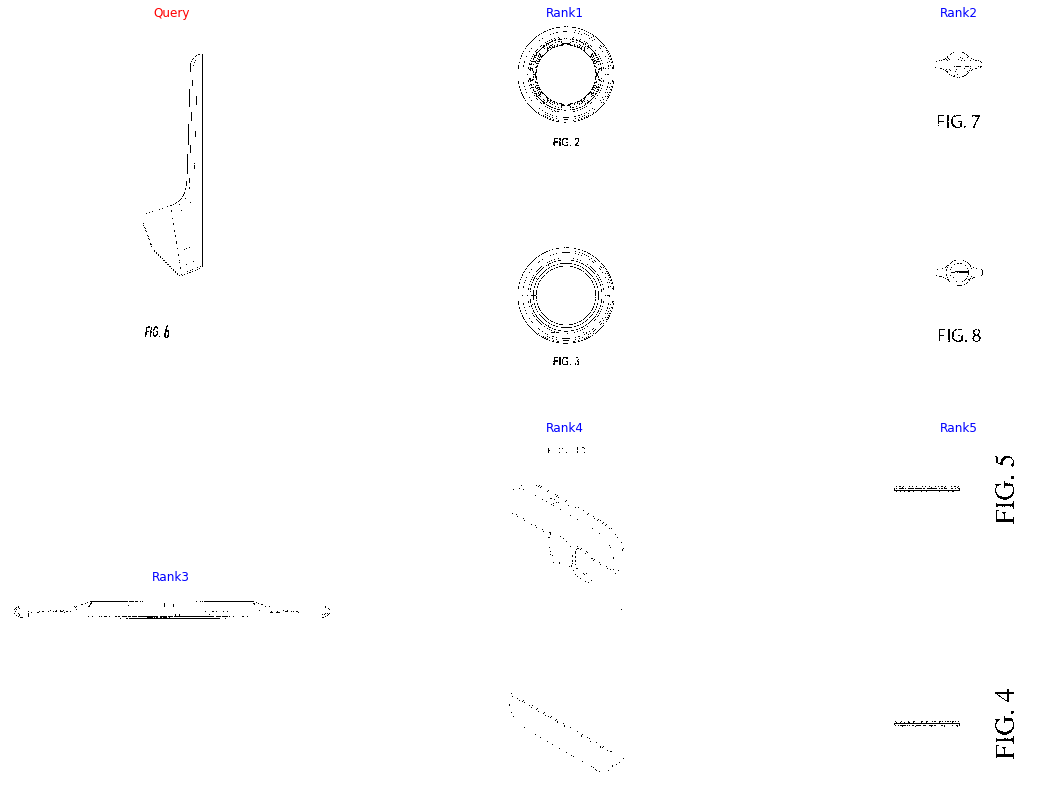

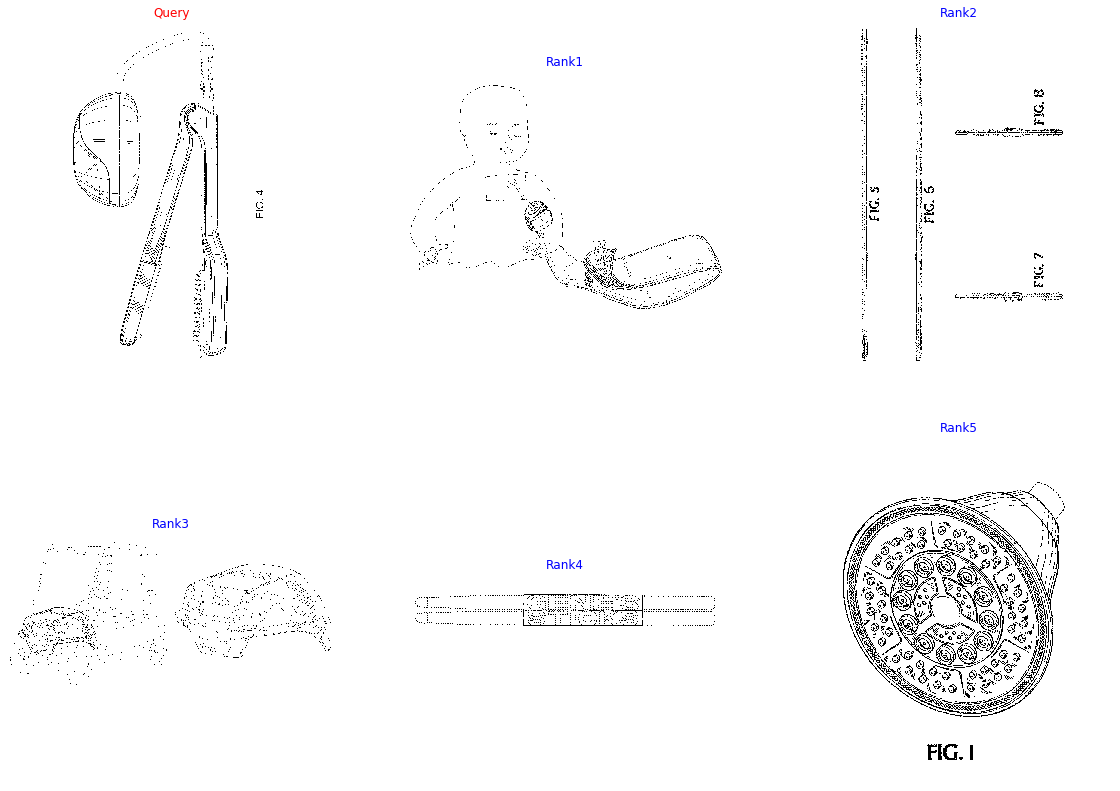

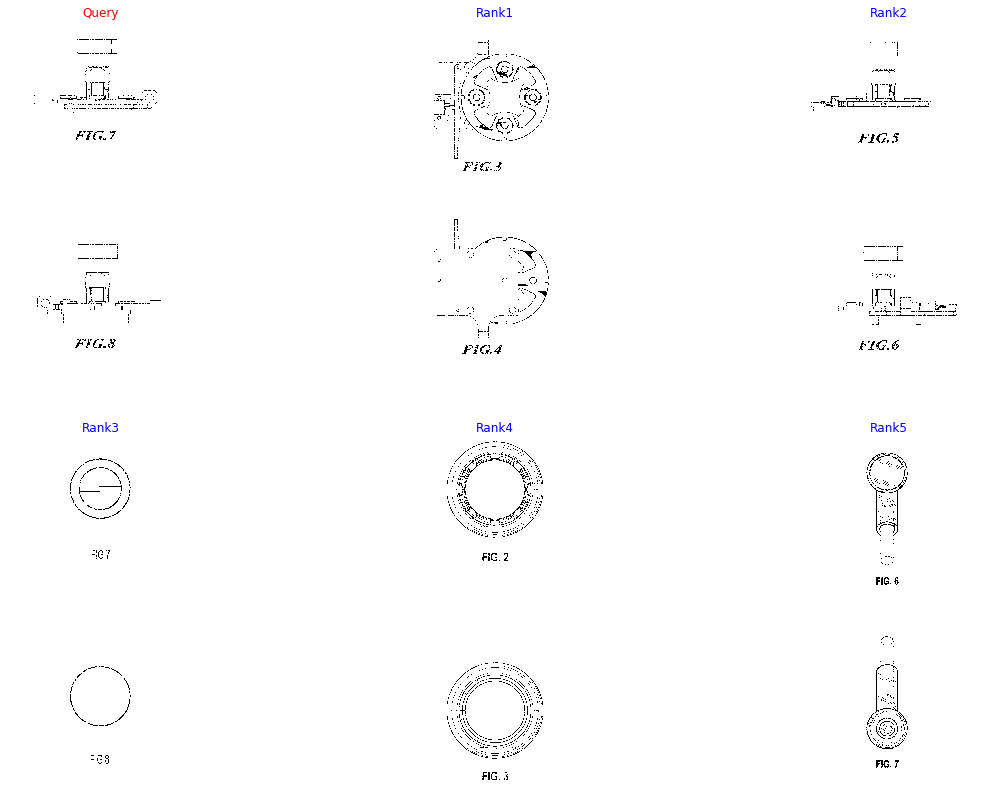

In [53]:
from tqdm.notebook import tqdm as trange
from PIL import Image

cnt = 0
with torch.no_grad():
    model.eval() # これがないと，推論時に，BatchNormが悪さをする．
    
    for f in trange(test_query_list[300:800]):
        cnt += 1
        im = Image.open(f)
        im = resizeImg(im, 384)
        im = torch.tensor([data_transform['val'](im).numpy()]).cuda()
        #print(im.shape) # torch.Size([1, 1, 256, 256])
    
        test_embed = model(im).cpu().numpy()
        _, I = faiss_index.search(test_embed, 5)
        #print("Query: {}\nRetrieved: rank1: {}\n rank2: {}\n rank3: {}\n\n".format(os.path.join(PATH_TEST,f), im_indices[I[0][0]], im_indices[I[0][1]], im_indices[I[0][2]]))
        
        if cnt%5==0:
            showQueryRetrievalImage(f, im_indices[I[0][0]], im_indices[I[0][1]], im_indices[I[0][2]], im_indices[I[0][3]], im_indices[I[0][4]])
            